In [ ]:
"""
Purpose: Applying Condensed Form of GMM pipeline
where just have to specify if want normalization 
or pca run in preprocessing phase

"""

In [1]:
from os import sys
sys.path.append("/meshAfterParty/")
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

import dimensionality_reduction_utils as dr
import clustering_utils as cl
dr = reload(dr)
cl = reload(cl)
import pandas_utils as pu

from sklearn.preprocessing import StandardScaler
import time
from collections import Counter
import copy
np.set_printoptions(suppress=True)

In [3]:
from sklearn import mixture
import gmm

# Importing the Data

In [4]:
df = pd.read_pickle("neuron_dendrite_path_data")
df_filtered = pu.filter_away_nan_rows(df)

In [5]:
for j,c in enumerate(df_filtered.columns[6:]):
    print(f"{j+1}) {c}")

1) n0_width_median_mesh_center
2) n0_width_no_spine_median_mesh_center
3) n0_n_spines
4) n0_total_spine_volume
5) n0_spine_volume_median
6) n0_spine_volume_density
7) n0_skeletal_length
8) n0_parent_angle
9) n0_sibling_angle
10) n1_width_median_mesh_center
11) n1_width_no_spine_median_mesh_center
12) n1_n_spines
13) n1_total_spine_volume
14) n1_spine_volume_median
15) n1_spine_volume_density
16) n1_skeletal_length
17) n1_parent_angle
18) n1_sibling_angle


# Get the distribution of the limb starts

Text(0.5, 1.0, 'Soma Angle Distribution ')

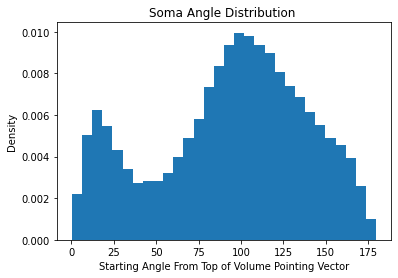

In [6]:
fig,ax = plt.subplots(1,1)
soma_angles =df_filtered[::4]["soma_angle"].to_numpy()

ax.hist(soma_angles,bins=30,density=True)
ax.set_xlabel("Starting Angle From Top of Volume Pointing Vector")
ax.set_ylabel("Density")
ax.set_title("Soma Angle Distribution ")

# Creating Train and Test datasets

In [7]:
def indices_of_soma_angle(df_curr,angle_interval):
    return np.where((df_curr["soma_angle"]>=angle_interval[0]) & 
           (df_curr["soma_angle"]<=angle_interval[-1]))[0]

In [8]:
basal_indices = indices_of_soma_angle(df_filtered,[100,115])
axon_indices = indices_of_soma_angle(df_filtered,[165,180])
apical_indices = indices_of_soma_angle(df_filtered,[0,20])

print(f"# basal paths = {len(basal_indices)}\n",
     f"# axon paths = {len(axon_indices)}\n",
     f"# apical paths = {len(apical_indices)}\n")

# basal paths = 39892
 # axon paths = 8785
 # apical paths = 25478



In [9]:
# picking 10000 of data randomly to test on
random_N = 8000

basal_indices_random =  basal_indices[np.random.choice(np.arange(len(basal_indices)),size=random_N,replace=False)]
axon_indices_random =  axon_indices[np.random.choice(np.arange(len(axon_indices)),size=random_N,replace=False)]
apical_indices_random =  apical_indices[np.random.choice(np.arange(len(apical_indices)),size=random_N,replace=False)]

print(f"After Picking a Random {random_N} subset of paths:\n"
      f"# basal paths = {len(basal_indices_random)}\n",
     f"# axon paths = {len(axon_indices_random)}\n",
     f"# apical paths = {len(apical_indices_random)}\n")

After Picking a Random 8000 subset of paths:
# basal paths = 8000
 # axon paths = 8000
 # apical paths = 8000



array(['n0_width_median_mesh_center',
       'n0_width_no_spine_median_mesh_center', 'n0_n_spines',
       'n0_total_spine_volume', 'n0_spine_volume_median',
       'n0_spine_volume_density', 'n0_skeletal_length', 'n0_parent_angle',
       'n0_sibling_angle', 'n1_width_median_mesh_center',
       'n1_width_no_spine_median_mesh_center', 'n1_n_spines',
       'n1_total_spine_volume', 'n1_spine_volume_median',
       'n1_spine_volume_density', 'n1_skeletal_length', 'n1_parent_angle',
       'n1_sibling_angle'], dtype=object)

# Part 1: Iinspecting 1D Marginals

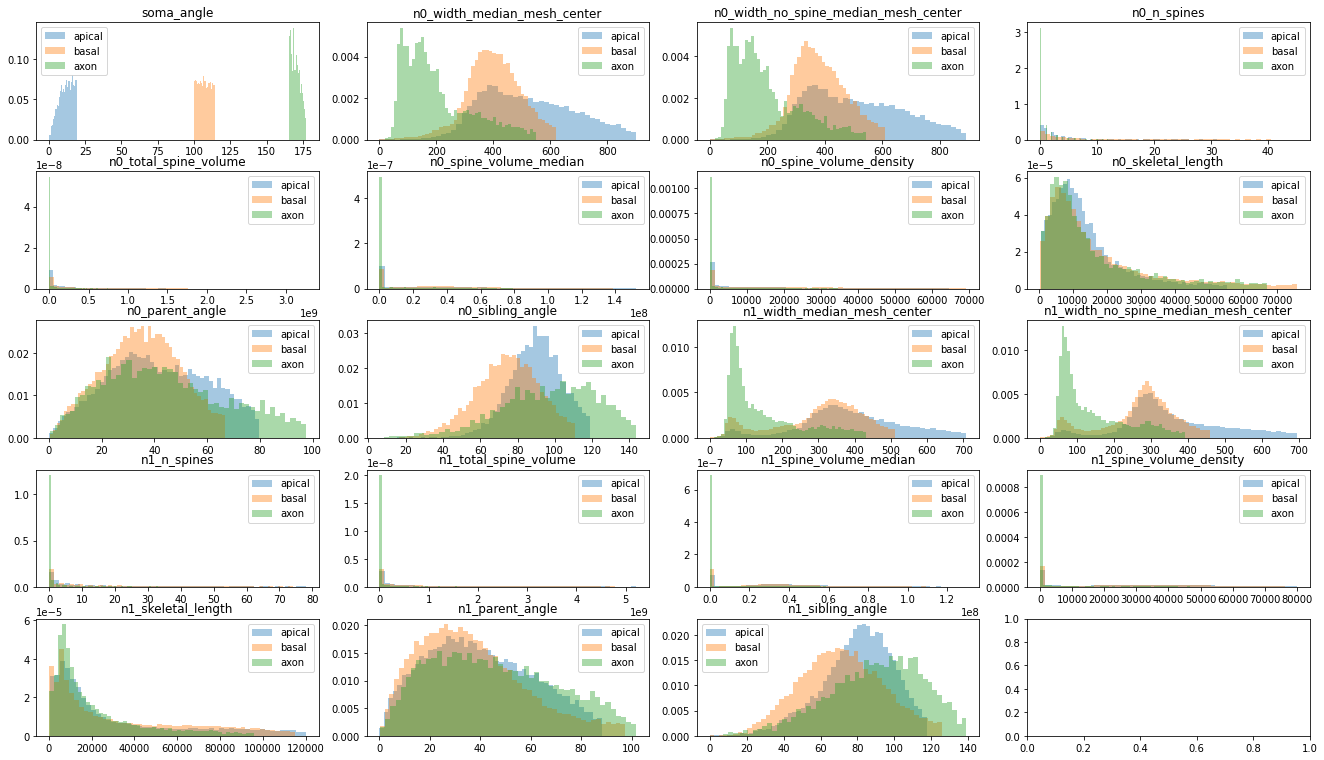

In [13]:
def plot_table_histograms(tables_to_plot,tables_labels,fig_title=None,
                         percentile_to_graph = 95):
    curr_table = apical_table

    fig,axes = plt.subplots(5,4)
    fig.set_size_inches(18.5, 10.5)
    fig.tight_layout()
    
    if not fig_title is None:
        fig.title(fig_title)

    
    for j,col_title in enumerate(curr_table):
        row = np.floor(j/4).astype("int")
        column = j - row*4
        ax = axes[row,column]
        ax.set_title(col_title)
        
        for curr_table,curr_table_name in zip(tables_to_plot,tables_labels):
            curr_data = curr_table[col_title].to_numpy()
            curr_data_below_percentile = curr_data[curr_data<=np.percentile(curr_data,percentile_to_graph)]
            ax.hist(curr_data_below_percentile,bins=50,label=curr_table_name,alpha=0.4,density=True)
            
        ax.legend()

df_col_restricted = df_filtered[df_filtered.columns[5:]]
apical_table = df_col_restricted.iloc[apical_indices]
basal_table = df_col_restricted.iloc[basal_indices]
axon_table = df_col_restricted.iloc[axon_indices]
plot_table_histograms([apical_table,basal_table,axon_table],["apical","basal","axon"])

# -- GMM Analysis ---

In [30]:
labeled_data_indices = dict(
                     Axon=axon_indices_random,
                     Basal=basal_indices_random,
                     Apical=apical_indices_random
    )

possible_K = list(np.arange(2,21))

In [31]:
columns_picked = df_filtered.columns[6:].to_numpy()

df_col_filtered = df_filtered[columns_picked]
df_col_filtered

,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,192.16,192.16,0,0.000000e+00,0.00,0.00,4891.73,28.43,140.83,328.27,327.31,4,1.846222e+08,50054356.20,2612.59,70666.48,13.53,96.80
1,192.16,192.16,0,0.000000e+00,0.00,0.00,4891.73,28.43,140.83,99.67,99.67,0,0.000000e+00,0.00,0.00,12721.84,84.41,96.80
2,83.79,83.79,0,0.000000e+00,0.00,0.00,6600.36,113.07,140.83,86.33,86.33,0,0.000000e+00,0.00,0.00,5910.65,29.57,31.68
3,83.79,83.79,0,0.000000e+00,0.00,0.00,6600.36,113.07,140.83,63.25,63.25,0,0.000000e+00,0.00,0.00,6464.83,4.32,31.68
4,363.80,363.80,0,0.000000e+00,0.00,0.00,9932.58,36.37,54.68,397.66,317.97,44,2.416440e+09,42964302.31,46091.42,52427.12,18.83,52.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278313,461.64,461.64,0,0.000000e+00,0.00,0.00,1461.31,47.00,114.81,288.77,288.77,6,3.020934e+08,49298399.24,13474.30,22419.97,86.21,99.05
278314,396.01,396.01,2,1.380452e+08,69022624.61,9362.18,14744.99,68.47,114.81,333.88,284.49,25,2.068806e+09,50627595.27,37042.28,55849.85,3.90,58.52
278315,396.01,396.01,2,1.380452e+08,69022624.61,9362.18,14744.99,68.47,114.81,320.84,280.30,26,1.225729e+09,19951175.90,16039.65,76418.71,60.77,58.52
278316,327.06,313.81,23,1.596199e+09,33134671.25,30817.91,51794.51,68.98,61.65,87.42,87.42,0,0.000000e+00,0.00,0.00,5459.70,102.40,111.85


# Part 1: GMM on Un-Nomralized Dataset (Original Basis)

In [19]:
# showing that if don't restrict to the columns then can't do higher clusters
gmm.gmm_pipeline(df_col_filtered,
                 labeled_data_indices = labeled_data_indices,
                 title_suffix = "Un-Normalized Original Data",
                 columns_picked = columns_picked,
                 possible_K = possible_K,
                 apply_normalization=False,
                 apply_pca=False,
                 
                )

# -------- Part 0: Preprocessing (Column restriction, Normalization, PCA) ----------- #
Restricting to columns : ['n0_width_median_mesh_center' 'n0_width_no_spine_median_mesh_center'
 'n0_n_spines' 'n0_total_spine_volume' 'n0_spine_volume_median'
 'n0_spine_volume_density' 'n0_skeletal_length' 'n0_parent_angle'
 'n0_sibling_angle' 'n1_width_median_mesh_center'
 'n1_width_no_spine_median_mesh_center' 'n1_n_spines'
 'n1_total_spine_volume' 'n1_spine_volume_median'
 'n1_spine_volume_density' 'n1_skeletal_length' 'n1_parent_angle'
 'n1_sibling_angle']
# -------- Part 1: GMM clustering with different Number of Clusters ----------- # 


------Working on clusters K=2-----
Using mixture model
Convergence status = True
Total time for GMM = 8.56384825706482


------Working on clusters K=3-----
Using mixture model
Exception occured = Fitting the mixture model failed because some components have ill-defined empirical covariance (for instance caused by singleton or collapsed samples). Try to decrea

Exception: No gmm converged and reg_cov was 1.0

# -------- Part 0: Preprocessing (Column restriction, Normalization, PCA) ----------- #
Restricting to columns : ['n0_width_median_mesh_center', 'n0_skeletal_length', 'n0_parent_angle', 'n0_sibling_angle', 'n1_width_median_mesh_center', 'n1_skeletal_length', 'n1_parent_angle', 'n1_sibling_angle']
# -------- Part 1: GMM clustering with different Number of Clusters ----------- # 


------Working on clusters K=2-----
Using mixture model
Convergence status = True
Total time for GMM = 3.337611436843872


------Working on clusters K=3-----
Using mixture model
Convergence status = True
Total time for GMM = 4.150134325027466


------Working on clusters K=4-----
Using mixture model
Convergence status = True
Total time for GMM = 14.744133234024048


------Working on clusters K=5-----
Using mixture model
Convergence status = True
Total time for GMM = 8.45819878578186


------Working on clusters K=6-----
Using mixture model
Convergence status = True
Total time for GMM = 10.959728717803955


------

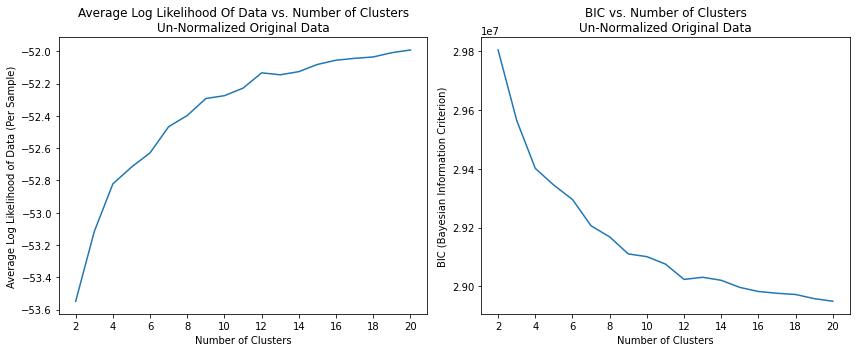

# --------- Part 2: computing the advanced statistics on the clustering ------- # 


----Working on Advanced Statistics for n_clusters = 2----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,373.201601,34635.560297,44.735354,87.467194,239.037827,16439.551440,53.402694,91.291039
1,448.120428,12734.359102,36.942278,79.468594,366.567973,50200.623954,35.585006,70.599446




Clustering Numbers By Neuroscience Category for K = 2


,classification,category,n_clusters,cl_0,cl_1
2,hard,Apical,2,2585.0,5415.0
5,soft,Apical,2,2822.2,5177.8
0,hard,Axon,2,6323.0,1677.0
3,soft,Axon,2,6318.6,1681.4
1,hard,Basal,2,2492.0,5508.0
4,soft,Basal,2,2626.7,5373.3




Clustering Advanced Statistics By Neuroscience Category for K = 2


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,2,1,0.676875,2,0.364165
5,Apical,soft,2,1,0.647230,2,0.358567
0,Axon,hard,2,0,0.790375,2,0.466281
3,Axon,soft,2,0,0.789830,2,0.452994
1,Basal,hard,2,1,0.688500,2,0.369066
4,Basal,soft,2,1,0.671665,2,0.368329




----Working on Advanced Statistics for n_clusters = 3----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,473.115020,9314.625338,42.077887,89.779627,354.239707,9708.311123,43.474483,84.684846
1,323.534484,47852.018291,42.835534,81.525506,202.584069,25493.184379,51.843272,91.334752
2,440.465029,13251.183414,37.096860,78.828269,359.355280,60901.683791,36.715197,67.551117




Clustering Numbers By Neuroscience Category for K = 3


,classification,category,n_clusters,cl_0,cl_1,cl_2
2,hard,Apical,3,3524.0,1089.0,3387.0
5,soft,Apical,3,3355.7,1182.7,3461.6
0,hard,Axon,3,3521.0,3487.0,992.0
3,soft,Axon,3,3275.5,3700.6,1023.9
1,hard,Basal,3,1907.0,1896.0,4197.0
4,soft,Basal,3,1846.0,2026.2,4127.8




Clustering Advanced Statistics By Neuroscience Category for K = 3


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,3,0,0.440500,2,0.363517
5,Apical,soft,3,2,0.432702,2,0.365248
0,Axon,hard,3,0,0.440125,2,0.422295
3,Axon,soft,3,1,0.462573,2,0.421165
1,Basal,hard,3,2,0.524625,3,0.376956
4,Basal,soft,3,2,0.515978,3,0.371795




----Working on Advanced Statistics for n_clusters = 4----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,336.585204,39756.342922,44.270052,84.222335,288.426036,41798.582443,31.330254,84.654221
1,299.622588,38096.016677,43.092824,84.518399,95.165128,6412.056985,77.686558,93.305338
2,539.606049,8946.052019,40.063363,87.553714,428.037889,10643.410286,37.807921,83.497089
3,445.137945,11529.085729,36.536403,78.480065,356.556354,59668.726655,38.074009,67.542960




Clustering Numbers By Neuroscience Category for K = 4


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3
2,hard,Apical,4,1103.0,505.0,3360.0,3032.0
5,soft,Apical,4,1232.9,491.7,3198.0,3077.4
0,hard,Axon,4,2970.0,3130.0,1062.0,838.0
3,soft,Axon,4,3038.3,2888.5,1224.1,849.1
1,hard,Basal,4,1497.0,1115.0,1442.0,3946.0
4,soft,Basal,4,1637.7,1088.3,1475.4,3798.6




Clustering Advanced Statistics By Neuroscience Category for K = 4


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,4,2,0.420000,3,0.421691
5,Apical,soft,4,2,0.399748,3,0.408931
0,Axon,hard,4,1,0.391250,3,0.491041
3,Axon,soft,4,0,0.379794,3,0.472111
1,Basal,hard,4,3,0.493250,3,0.376356
4,Basal,soft,4,3,0.474827,3,0.369490




----Working on Advanced Statistics for n_clusters = 5----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,472.190271,8429.556697,38.781861,86.479252,377.691823,11276.582951,36.043979,81.166571
1,418.675162,14978.575489,37.092407,77.180673,356.329702,62423.947859,35.633252,65.206502
2,293.342866,45119.105414,43.795117,87.586393,236.599771,36140.741715,33.976830,92.230714
3,366.507033,40942.342007,39.460267,76.257901,168.529991,5242.015927,78.226732,90.613452
4,605.138959,8077.216912,51.716125,96.326894,362.209985,70027.316980,51.596648,81.948295




Clustering Numbers By Neuroscience Category for K = 5


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4
2,hard,Apical,5,3270.0,2396.0,611.0,634.0,1089.0
5,soft,Apical,5,3111.7,2337.0,688.2,646.9,1216.1
0,hard,Axon,5,2865.0,683.0,3332.0,764.0,356.0
3,soft,Axon,5,2610.1,680.6,3485.7,792.5,431.1
1,hard,Basal,5,2086.0,3360.0,1026.0,1225.0,303.0
4,soft,Basal,5,1908.2,3350.8,1103.4,1237.8,399.8




Clustering Advanced Statistics By Neuroscience Category for K = 5


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,5,0,0.408750,3,0.387384
5,Apical,soft,5,0,0.388958,3,0.386899
0,Axon,hard,5,2,0.416500,3,0.450028
3,Axon,soft,5,2,0.435710,3,0.449162
1,Basal,hard,5,1,0.420000,3,0.389886
4,Basal,soft,5,1,0.418848,3,0.390167




----Working on Advanced Statistics for n_clusters = 6----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,322.170280,46814.605894,41.338339,81.107858,269.968089,38814.901053,27.151329,88.043402
1,473.986304,11653.547587,35.621116,78.529721,402.734021,20338.845728,30.890349,73.778740
2,494.080725,12214.212027,57.475838,106.171235,277.843838,58960.741818,57.989699,87.931339
3,464.830774,7213.790185,41.524675,91.830601,352.443477,9039.175184,41.307738,84.894068
4,415.838882,13881.817737,37.346190,77.961309,345.027340,77966.206738,39.245777,64.018854
5,357.884338,43248.761928,39.621354,75.702146,157.450780,5298.617141,79.788546,90.869554




Clustering Numbers By Neuroscience Category for K = 6


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5
2,hard,Apical,6,680.0,1872.0,725.0,2285.0,1858.0,580.0
5,soft,Apical,6,747.3,1892.9,815.0,2140.3,1827.2,577.3
0,hard,Axon,6,2299.0,432.0,1144.0,2855.0,494.0,776.0
3,soft,Axon,6,2331.1,434.8,1267.1,2669.3,502.7,795.0
1,hard,Basal,6,1127.0,1878.0,246.0,1110.0,2479.0,1160.0
4,soft,Basal,6,1214.8,1757.2,294.5,1093.1,2476.0,1164.4




Clustering Advanced Statistics By Neuroscience Category for K = 6


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,6,3,0.285625,4,0.360349
5,Apical,soft,6,3,0.267534,4,0.361108
0,Axon,hard,6,3,0.356875,4,0.443084
3,Axon,soft,6,3,0.333667,4,0.437050
1,Basal,hard,6,4,0.309875,4,0.398167
4,Basal,soft,6,4,0.309500,4,0.393583




----Working on Advanced Statistics for n_clusters = 7----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,505.858808,8885.549956,35.327294,80.818118,410.096904,12783.266540,32.591445,76.582288
1,455.826376,24366.532681,55.808098,98.492297,296.502880,70633.427551,60.953979,89.556647
2,278.743278,50027.556838,43.344039,86.224833,223.375718,29477.136327,28.815274,92.830738
3,322.529548,39210.253027,40.196778,79.587442,94.015086,5769.912178,81.388279,92.848070
4,501.682813,8349.107212,53.666463,104.452375,385.317126,8423.682180,49.058147,91.068397
5,397.305100,23892.396850,39.157372,76.496544,359.376423,52374.517079,28.852204,67.072465
6,448.632871,8633.515913,36.015579,79.647417,349.440825,75150.715322,43.636648,68.798758




Clustering Numbers By Neuroscience Category for K = 7


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6
2,hard,Apical,7,2954.0,450.0,350.0,484.0,781.0,1286.0,1695.0
5,soft,Apical,7,2710.8,527.6,399.4,467.9,879.6,1338.3,1676.3
0,hard,Axon,7,699.0,637.0,2686.0,1905.0,1239.0,401.0,433.0
3,soft,Axon,7,655.2,711.2,2723.3,1793.3,1245.4,431.4,440.2
1,hard,Basal,7,2125.0,200.0,693.0,1069.0,300.0,1640.0,1973.0
4,soft,Basal,7,1905.0,246.1,746.5,1038.2,337.9,1791.8,1934.5




Clustering Advanced Statistics By Neuroscience Category for K = 7


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,7,0,0.369250,4,0.403592
5,Apical,soft,7,0,0.338853,4,0.399987
0,Axon,hard,7,2,0.335750,4,0.517471
3,Axon,soft,7,2,0.340410,4,0.505419
1,Basal,hard,7,0,0.265625,4,0.383535
4,Basal,soft,7,6,0.241814,4,0.383949




----Working on Advanced Statistics for n_clusters = 8----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,510.207854,6793.645723,37.733807,86.019690,395.965634,8848.199462,36.685001,81.376571
1,416.938768,12581.941640,37.084416,78.129963,343.834943,78624.121133,40.878954,64.779240
2,187.703000,38221.781263,49.468060,101.006678,120.324095,18245.404235,51.697691,99.066687
3,564.769424,11106.008531,57.531920,102.453802,336.889854,71725.972258,49.720290,82.601748
4,475.817614,21548.245295,43.501495,95.166242,448.712189,4596.746524,61.507759,95.355817
5,354.624908,42741.600770,39.305034,74.050748,94.148555,5118.455069,83.930668,91.646522
6,472.218521,11844.202710,36.021422,79.179896,395.557676,21377.660629,32.133023,72.583163
7,375.347071,41123.921842,39.610496,75.493514,332.272858,45762.410220,23.257389,79.595764




Clustering Numbers By Neuroscience Category for K = 8


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7
2,hard,Apical,8,2208.0,1680.0,104.0,750.0,263.0,444.0,1764.0,787.0
5,soft,Apical,8,2052.9,1660.6,117.6,844.9,315.1,427.1,1719.9,861.8
0,hard,Axon,8,1113.0,471.0,4247.0,587.0,95.0,545.0,376.0,566.0
3,soft,Axon,8,1136.2,465.6,4019.2,632.1,178.4,547.1,395.9,625.6
1,hard,Basal,8,1293.0,2251.0,297.0,229.0,186.0,972.0,1565.0,1207.0
4,soft,Basal,8,1167.8,2252.1,313.2,279.6,220.5,934.8,1524.8,1307.2




Clustering Advanced Statistics By Neuroscience Category for K = 8


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,8,0,0.276000,4,0.421099
5,Apical,soft,8,0,0.256617,5,0.414946
0,Axon,hard,8,2,0.530875,4,0.593857
3,Axon,soft,8,2,0.502397,4,0.573466
1,Basal,hard,8,1,0.281375,5,0.417675
4,Basal,soft,8,1,0.281510,5,0.414239




----Working on Advanced Statistics for n_clusters = 9----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,567.034793,6508.650472,37.266055,87.285135,427.798093,8259.710406,38.720459,81.954060
1,390.052817,19964.299346,40.093646,77.721764,334.546487,66135.860267,35.210375,60.373301
2,337.307625,47866.213772,39.906518,74.905952,76.347554,6479.028529,84.396245,91.443815
3,526.883181,15570.547702,62.886384,107.079848,357.587039,59378.919650,50.450763,86.933448
4,469.139370,11792.546270,36.163549,79.398149,405.414727,15972.385160,28.890259,74.460219
5,406.988603,29619.164784,38.507067,77.076265,250.760634,1889.398059,79.596557,93.902418
6,472.807154,7546.276821,34.367380,80.029050,351.730452,74596.275554,44.910617,71.959017
7,357.696830,54250.007289,40.142820,76.026566,310.116183,37173.700698,22.463168,88.755265
8,146.165447,17391.358953,51.767706,107.444524,100.339446,16106.585876,54.057549,99.345650




Clustering Numbers By Neuroscience Category for K = 9


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8
2,hard,Apical,9,1943.0,1263.0,320.0,522.0,1797.0,199.0,1343.0,585.0,28.0
5,soft,Apical,9,1800.6,1243.0,327.4,607.7,1758.3,188.7,1408.6,635.5,30.3
0,hard,Axon,9,444.0,348.0,575.0,609.0,429.0,99.0,378.0,758.0,4360.0
3,soft,Axon,9,487.7,377.2,618.8,644.9,415.8,90.4,371.0,800.4,4193.8
1,hard,Basal,9,865.0,1547.0,715.0,204.0,1690.0,407.0,1525.0,910.0,137.0
4,soft,Basal,9,831.9,1657.4,727.5,235.6,1531.2,381.5,1493.1,1001.3,140.2




Clustering Advanced Statistics By Neuroscience Category for K = 9


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,9,0,0.242875,5,0.440281
5,Apical,soft,9,0,0.225074,5,0.435381
0,Axon,hard,9,8,0.545000,5,0.642887
3,Axon,soft,9,8,0.524221,5,0.627718
1,Basal,hard,9,4,0.211250,5,0.423634
4,Basal,soft,9,1,0.207178,5,0.420468




----Working on Advanced Statistics for n_clusters = 10----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,507.676100,6802.268785,32.935911,81.487432,353.499971,72141.101139,47.960593,74.542836
1,483.555451,10235.915945,35.512846,79.243012,409.590563,13813.373049,30.114786,75.180026
2,361.150287,56103.816844,40.388903,74.657024,316.861972,38576.748445,20.786993,90.463513
3,560.570607,6364.374706,41.541529,92.987087,413.148925,7827.548620,41.825826,84.836539
4,396.343309,13523.968224,39.916187,77.436653,349.131109,77330.527165,35.879849,60.525695
5,521.643048,16647.462781,67.550173,107.210788,359.960803,65955.161372,51.074054,88.648689
6,396.831547,25127.347548,38.712386,80.599030,327.303638,44864.764878,34.419735,66.701353
7,403.195658,31958.164942,38.397857,76.457710,233.448600,1877.153075,81.224850,93.886774
8,157.750752,22080.758199,51.111227,105.446684,106.883738,16487.735635,53.565066,100.328072
9,331.932976,47022.387410,39.711017,74.923312,72.275449,6599.539016,84.536094,91.356423




Clustering Numbers By Neuroscience Category for K = 10


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9
2,hard,Apical,10,1135.0,2160.0,468.0,1408.0,1104.0,356.0,839.0,192.0,44.0,294.0
5,soft,Apical,10,1219.0,1970.8,531.0,1398.7,1029.1,416.3,904.6,182.8,47.4,300.4
0,hard,Axon,10,286.0,483.0,512.0,514.0,237.0,489.0,468.0,89.0,4315.0,607.0
3,soft,Axon,10,291.8,447.3,550.5,663.4,252.0,509.0,506.9,84.3,4050.4,644.3
1,hard,Basal,10,904.0,1958.0,829.0,483.0,1545.0,143.0,882.0,408.0,169.0,679.0
4,soft,Basal,10,1029.0,1670.8,881.8,553.4,1433.1,167.8,1018.6,388.1,181.5,676.1




Clustering Advanced Statistics By Neuroscience Category for K = 10


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,10,1,0.270000,5,0.436788
5,Apical,soft,10,1,0.246350,5,0.427398
0,Axon,hard,10,8,0.539375,5,0.632363
3,Axon,soft,10,8,0.506301,5,0.609004
1,Basal,hard,10,1,0.244750,6,0.425566
4,Basal,soft,10,1,0.208851,6,0.417703




----Working on Advanced Statistics for n_clusters = 11----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,552.073521,6495.262838,35.687365,84.109826,427.308973,8370.529786,35.987780,80.087666
1,396.059824,10446.950364,39.486058,77.761383,350.144058,79890.113759,37.218877,63.107758
2,360.070627,43932.222094,39.465894,75.581233,334.036238,43253.664805,19.198237,88.350149
3,399.271671,24101.656147,38.685553,77.126042,326.351983,55386.921016,36.693891,61.319357
4,468.592865,11792.950233,36.717677,79.750495,402.172327,17981.175348,30.157002,73.971543
5,127.276958,10382.856748,54.045690,110.643439,92.038972,15908.396082,53.116802,97.529937
6,300.208788,69274.413804,43.105097,84.684212,176.773806,15550.051012,52.488170,96.108431
7,351.520988,41365.101496,39.471873,74.839954,88.907129,5237.120068,83.980680,91.652763
8,523.981516,14674.157204,67.587655,108.421047,345.899810,65033.495265,46.479493,83.145718
9,504.758933,17991.842667,42.096899,91.578885,459.758591,2913.190167,62.068988,96.212936




Clustering Numbers By Neuroscience Category for K = 11


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10
2,hard,Apical,11,1918.0,959.0,517.0,699.0,1653.0,8.0,152.0,429.0,399.0,248.0,1018.0
5,soft,Apical,11,1762.3,875.1,562.9,800.2,1588.1,7.1,173.6,404.0,469.9,291.9,1065.0
0,hard,Axon,11,397.0,265.0,593.0,257.0,385.0,3786.0,896.0,591.0,539.0,98.0,193.0
3,soft,Axon,11,395.7,247.6,611.5,289.5,366.9,3629.1,970.3,584.5,565.5,131.1,208.5
1,hard,Basal,11,1124.0,1512.0,807.0,911.0,1476.0,69.0,299.0,936.0,172.0,186.0,508.0
4,soft,Basal,11,991.1,1317.3,867.1,1071.6,1379.1,70.1,349.7,887.3,193.1,213.5,660.0




Clustering Advanced Statistics By Neuroscience Category for K = 11


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,11,0,0.239750,6,0.444715
5,Apical,soft,11,0,0.220293,6,0.439422
0,Axon,hard,11,5,0.473250,5,0.639881
3,Axon,soft,11,5,0.453634,6,0.626598
1,Basal,hard,11,1,0.189000,6,0.420559
4,Basal,soft,11,4,0.172382,6,0.415427




----Working on Advanced Statistics for n_clusters = 12----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,552.132517,6743.366560,34.944587,83.336806,426.277358,8631.511664,36.210765,79.608962
1,368.983554,41438.073670,39.587988,74.869756,346.047181,39378.435862,19.223258,85.659824
2,393.194257,19427.695865,39.707431,77.588096,337.579017,68578.509539,36.022504,60.226164
3,566.030288,11115.140938,59.579250,102.710303,356.077723,74425.362458,45.494804,77.794092
4,301.111340,64184.059999,40.799884,75.544720,154.959381,11566.593377,52.347189,95.137052
5,463.256726,12493.681284,36.905876,80.076904,401.116152,18131.527303,29.120723,73.801719
6,400.735540,30963.222156,38.085300,76.815620,171.158787,1872.319278,83.106555,94.256582
7,126.289349,9722.564179,55.034645,111.276053,93.299435,15377.483372,51.518556,97.081727
8,461.890480,7280.850033,34.150486,78.981187,350.468332,74223.517293,45.239000,71.842912
9,324.477194,43209.507419,40.002822,76.426853,67.749249,6682.648452,84.522792,91.226547




Clustering Numbers By Neuroscience Category for K = 12


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11
2,hard,Apical,12,2043.0,550.0,1128.0,497.0,140.0,1600.0,197.0,6.0,1140.0,263.0,101.0,335.0
5,soft,Apical,12,1884.4,576.9,1116.1,619.4,144.2,1536.9,182.7,5.4,1155.9,260.0,146.6,371.5
0,hard,Axon,12,402.0,388.0,287.0,228.0,714.0,369.0,91.0,3543.0,347.0,662.0,874.0,95.0
3,soft,Axon,12,385.4,430.8,318.2,259.6,723.4,370.0,85.6,3376.5,328.7,664.5,924.4,132.8
1,hard,Basal,12,1235.0,819.0,1348.0,175.0,329.0,1372.0,407.0,61.0,1446.0,587.0,118.0,103.0
4,soft,Basal,12,1077.3,876.5,1489.6,216.7,335.9,1294.2,385.6,62.5,1388.3,584.0,165.5,123.9




Clustering Advanced Statistics By Neuroscience Category for K = 12


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,12,0,0.255375,5,0.448589
5,Apical,soft,12,0,0.235549,6,0.445865
0,Axon,hard,12,7,0.442875,6,0.653091
3,Axon,soft,12,7,0.422066,6,0.635914
1,Basal,hard,12,8,0.180750,6,0.419454
4,Basal,soft,12,2,0.186201,6,0.418161




----Working on Advanced Statistics for n_clusters = 13----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,596.302117,6266.985077,37.698882,89.313092,439.894046,7516.225364,41.240037,83.180459
1,426.068665,8023.242223,35.524416,78.252098,343.376213,86750.448806,42.498711,66.476008
2,392.285950,26178.355289,36.110280,80.574603,381.227951,17855.798436,20.545552,84.381362
3,330.728825,44344.496774,39.792221,75.361367,71.743988,6480.758983,84.177631,91.213270
4,506.870442,6798.205008,35.611416,80.669907,381.130937,30442.172235,40.981248,77.318684
5,561.978095,9652.977528,72.626690,111.229333,399.275825,46092.668858,48.339161,85.744781
6,281.932583,66058.144903,45.579543,89.286408,154.568099,16143.169811,60.224077,99.295792
7,475.692798,10555.110251,36.227786,79.403332,403.882872,11404.955043,29.199094,73.807503
8,554.054668,21278.738468,33.507150,87.665751,331.650870,100319.556851,53.850664,78.145230
9,403.154404,29747.446412,38.310396,76.422946,232.034842,1866.758118,81.381041,93.709135




Clustering Numbers By Neuroscience Category for K = 13


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12
2,hard,Apical,13,1372.0,762.0,481.0,292.0,855.0,355.0,113.0,1607.0,655.0,187.0,957.0,4.0,360.0
5,soft,Apical,13,1308.5,767.5,517.9,290.8,896.8,414.5,135.8,1450.7,686.1,176.0,949.7,4.4,401.2
0,hard,Axon,13,263.0,268.0,506.0,654.0,231.0,433.0,821.0,361.0,138.0,81.0,238.0,3498.0,508.0
3,soft,Axon,13,289.7,261.2,516.8,663.3,228.6,451.3,921.8,321.7,148.4,78.4,268.0,3320.3,530.6
1,hard,Basal,13,484.0,1321.0,589.0,662.0,744.0,140.0,217.0,1437.0,176.0,401.0,1162.0,61.0,606.0
4,soft,Basal,13,515.0,1237.6,611.6,657.2,771.7,157.5,261.5,1215.4,232.1,374.5,1260.0,60.5,645.4




Clustering Advanced Statistics By Neuroscience Category for K = 13


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,13,7,0.200875,7,0.451431
5,Apical,soft,13,7,0.181337,7,0.444063
0,Axon,hard,13,11,0.437250,6,0.626185
3,Axon,soft,13,11,0.415039,6,0.613127
1,Basal,hard,13,7,0.179625,7,0.426477
4,Basal,soft,13,10,0.157497,8,0.420060




----Working on Advanced Statistics for n_clusters = 14----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,475.065199,10459.810213,36.120407,79.206959,403.028210,12417.280742,29.902110,73.426359
1,347.028785,53588.283453,41.114859,75.148883,296.016207,52368.871266,19.793909,85.136990
2,278.704697,68605.107016,46.064138,87.865647,152.707302,16513.291478,56.726956,99.363319
3,352.722881,17087.231125,33.252815,86.777431,110.034696,4479.301317,81.311726,92.716759
4,429.767165,7662.502630,35.069593,78.259265,343.672188,90226.886405,43.107185,66.714586
5,322.540549,50678.874092,41.763517,72.715565,65.560519,7129.392473,84.369264,90.576267
6,508.825029,7054.971229,35.655065,81.307985,374.229293,34001.443487,43.052385,77.834874
7,395.544918,26073.001830,36.423021,80.547923,382.489539,19182.549554,21.382531,82.944668
8,122.270722,9670.769539,56.852992,111.120027,92.093336,16665.514444,50.535413,97.115784
9,569.991290,9853.408817,73.031254,110.953206,408.199245,47234.689147,48.772572,86.177908




Clustering Numbers By Neuroscience Category for K = 14


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13
2,hard,Apical,14,1614.0,362.0,107.0,107.0,649.0,233.0,898.0,511.0,4.0,356.0,606.0,985.0,157.0,1411.0
5,soft,Apical,14,1482.5,399.6,124.1,126.8,660.8,224.5,936.0,557.2,3.6,411.7,649.1,959.9,144.5,1319.7
0,hard,Axon,14,360.0,476.0,829.0,475.0,238.0,435.0,219.0,492.0,3344.0,409.0,131.0,245.0,63.0,284.0
3,soft,Axon,14,328.1,501.5,911.8,500.6,225.1,438.1,231.5,493.3,3170.0,428.2,144.1,265.8,60.1,301.9
1,hard,Basal,14,1488.0,606.0,215.0,219.0,1152.0,523.0,704.0,626.0,57.0,133.0,175.0,1220.0,349.0,533.0
4,soft,Basal,14,1278.6,638.6,255.8,256.9,1074.2,500.6,737.7,651.4,54.8,152.3,239.7,1287.7,319.2,552.5




Clustering Advanced Statistics By Neuroscience Category for K = 14


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,14,0,0.201750,7,0.449932
5,Apical,soft,14,0,0.185315,7,0.442490
0,Axon,hard,14,8,0.418000,7,0.623946
3,Axon,soft,14,8,0.396244,7,0.610192
1,Basal,hard,14,0,0.186000,8,0.423810
4,Basal,soft,14,11,0.160957,8,0.416636




----Working on Advanced Statistics for n_clusters = 15----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,603.467823,5556.716862,39.361675,89.807943,458.321571,7639.329046,38.434362,82.454384
1,402.452514,10978.614857,38.005666,77.613220,342.859520,79837.594642,39.208080,61.626416
2,271.120321,69040.185015,46.381412,85.419219,139.154599,13847.974158,57.382076,99.416970
3,517.207551,5878.481196,32.969240,83.045116,345.553771,89840.650055,50.841005,75.437461
4,478.201454,9960.440157,35.941805,79.070721,405.853884,11399.380217,29.262872,73.597784
5,395.991534,34368.070553,38.780342,75.999626,180.264732,1847.592020,83.451430,94.278907
6,324.803010,50348.354335,41.688011,71.983680,64.695405,6983.351690,84.165009,89.969023
7,394.961250,22813.505380,35.605864,82.192656,392.508954,15104.256035,19.502886,85.823029
8,118.834760,9046.266157,58.714771,110.929739,88.327567,16952.769663,51.254997,96.845504
9,372.999299,28425.960993,39.275952,99.213242,273.104247,88629.191439,46.339523,84.294384




Clustering Numbers By Neuroscience Category for K = 15


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14
2,hard,Apical,15,1158.0,867.0,96.0,643.0,1560.0,178.0,224.0,437.0,2.0,254.0,749.0,343.0,99.0,1136.0,254.0
5,soft,Apical,15,1132.9,811.6,107.3,696.8,1398.7,166.7,214.3,483.1,2.4,314.9,783.4,376.4,110.1,1113.1,288.4
0,hard,Axon,15,253.0,261.0,793.0,131.0,351.0,82.0,356.0,523.0,3111.0,662.0,221.0,292.0,610.0,216.0,138.0
3,soft,Axon,15,263.9,246.2,853.5,155.6,315.6,73.1,353.8,507.9,2929.6,735.6,238.7,323.1,636.3,211.1,156.0
1,hard,Basal,15,457.0,1450.0,227.0,384.0,1459.0,386.0,513.0,505.0,52.0,172.0,918.0,558.0,171.0,655.0,93.0
4,soft,Basal,15,479.8,1290.2,246.0,523.1,1228.8,360.2,484.5,530.9,48.6,224.5,1007.6,604.5,205.3,665.6,100.3




Clustering Advanced Statistics By Neuroscience Category for K = 15


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,15,4,0.195000,7,0.445549
5,Apical,soft,15,4,0.174836,7,0.438976
0,Axon,hard,15,8,0.388875,7,0.629004
3,Axon,soft,15,8,0.366202,8,0.614971
1,Basal,hard,15,4,0.182375,8,0.422281
4,Basal,soft,15,1,0.161272,9,0.415546




----Working on Advanced Statistics for n_clusters = 16----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,286.614395,61439.135346,41.543317,79.225660,135.448659,10933.973039,62.216377,97.560573
1,500.456142,7241.715834,35.356604,80.112055,385.335614,28817.070099,39.730149,77.000946
2,400.267710,31824.170331,38.102985,76.744391,172.929794,1863.291295,83.429028,94.399918
3,313.873589,56782.569690,63.514283,98.950721,230.144187,77432.849793,53.512804,89.683588
4,316.729866,34506.730638,39.061166,84.581777,277.626835,65423.352681,22.109065,83.057861
5,381.509724,17483.237409,33.971623,91.448618,363.988133,14536.640967,22.106186,88.139448
6,468.733835,10278.117404,36.303337,78.831971,400.061974,10917.356515,28.304076,73.246727
7,603.411910,6790.510128,37.150608,88.128900,445.588003,7360.340496,41.629127,83.272121
8,372.222446,55268.936503,41.549947,72.532315,346.319255,27480.199925,18.473929,88.704470
9,119.343542,9341.143842,58.906954,111.476109,82.025833,15674.589144,55.889197,97.084073




Clustering Numbers By Neuroscience Category for K = 16


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15
2,hard,Apical,16,121.0,874.0,190.0,96.0,171.0,362.0,1322.0,1462.0,305.0,1.0,842.0,251.0,255.0,663.0,537.0,548.0
5,soft,Apical,16,120.0,869.3,180.6,120.5,210.4,416.9,1168.0,1382.5,320.2,2.1,794.6,246.9,298.9,691.8,591.6,585.7
0,hard,Axon,16,736.0,217.0,88.0,485.0,640.0,756.0,309.0,246.0,123.0,3042.0,283.0,581.0,126.0,179.0,63.0,126.0
3,soft,Axon,16,770.7,219.4,83.5,530.4,693.9,734.4,278.6,253.3,143.3,2893.5,257.4,577.4,136.3,198.8,79.2,150.1
1,hard,Basal,16,263.0,743.0,411.0,93.0,311.0,313.0,1329.0,508.0,471.0,55.0,1494.0,570.0,97.0,801.0,211.0,330.0
4,soft,Basal,16,279.1,753.9,386.4,112.1,365.6,351.7,1112.4,519.2,496.3,47.5,1321.3,560.9,103.9,869.8,285.9,434.1




Clustering Advanced Statistics By Neuroscience Category for K = 16


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,16,7,0.182750,8,0.455705
5,Apical,soft,16,7,0.172812,8,0.446959
0,Axon,hard,16,9,0.380250,7,0.630276
3,Axon,soft,16,9,0.361694,7,0.616103
1,Basal,hard,16,10,0.186750,9,0.424234
4,Basal,soft,16,10,0.165157,9,0.416708




----Working on Advanced Statistics for n_clusters = 17----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,375.312752,17927.804429,33.702907,92.158970,355.938857,15835.784850,22.716287,88.556980
1,399.830134,9731.994319,38.073077,76.933088,349.194493,89734.093861,39.823500,62.370735
2,325.496150,43110.690955,40.060136,75.713865,66.970390,6628.393054,84.357588,90.855144
3,608.484367,6397.042900,38.267341,89.692032,444.798680,7471.635049,42.517164,83.717547
4,287.747335,64792.760194,41.707141,78.707848,135.581176,11155.784430,62.081247,96.809786
5,544.851528,4296.112876,37.540162,87.726065,350.221588,75325.368525,51.599031,77.149747
6,676.897721,10932.543234,75.601221,107.714805,556.112211,12852.398660,54.548017,91.476421
7,315.712505,48711.882551,62.318345,102.057858,237.150892,75497.631185,49.905308,88.738702
8,119.425248,9403.980127,58.903412,111.561658,82.193428,15376.936714,55.889342,97.311200
9,400.134855,31907.003991,38.095605,76.722485,171.782497,1863.846785,83.469641,94.421466




Clustering Numbers By Neuroscience Category for K = 17


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16
2,hard,Apical,17,351.0,625.0,252.0,1273.0,123.0,535.0,238.0,106.0,1.0,191.0,270.0,839.0,299.0,1467.0,573.0,684.0,173.0
5,soft,Apical,17,403.0,563.2,247.4,1229.4,121.2,544.5,271.5,144.2,2.2,179.9,352.6,827.5,310.1,1302.8,621.6,674.8,204.3
0,hard,Axon,17,836.0,179.0,584.0,242.0,710.0,127.0,113.0,549.0,3029.0,90.0,313.0,191.0,115.0,315.0,72.0,165.0,370.0
3,soft,Axon,17,816.8,157.0,587.6,246.8,735.6,140.7,121.1,608.4,2884.6,83.5,325.7,195.9,138.4,280.0,83.1,175.7,419.0
1,hard,Basal,17,317.0,1083.0,569.0,437.0,265.0,299.0,88.0,101.0,54.0,410.0,444.0,821.0,453.0,1269.0,212.0,864.0,314.0
4,soft,Basal,17,351.4,922.1,563.5,449.9,279.8,354.3,95.2,125.6,47.5,385.2,555.9,805.8,478.7,1060.0,281.9,878.0,365.3




Clustering Advanced Statistics By Neuroscience Category for K = 17


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,17,13,0.183375,9,0.452942
5,Apical,soft,17,13,0.162856,9,0.445754
0,Axon,hard,17,8,0.378625,8,0.623668
3,Axon,soft,17,8,0.360580,8,0.608893
1,Basal,hard,17,13,0.158625,10,0.421608
4,Basal,soft,17,13,0.132498,10,0.415414




----Working on Advanced Statistics for n_clusters = 18----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,517.015078,10692.875577,37.486047,82.448357,394.079887,21528.000834,42.190820,78.350137
1,401.601119,8309.955403,39.794409,77.594314,348.746278,97044.478171,37.946680,63.531206
2,323.722798,48561.069364,41.796054,72.556456,64.701850,6901.100720,84.334882,90.170627
3,339.821590,17627.732148,31.960008,92.494741,117.208050,5170.822883,75.774570,93.460849
4,407.579999,10124.677065,36.580290,77.418061,337.009736,44717.385815,35.293569,69.236947
5,120.677169,9218.119733,57.907828,111.177541,88.667113,16012.986699,51.930910,97.310714
6,356.947784,54630.804684,40.478618,73.090709,318.378490,43187.901876,18.401765,88.325970
7,691.957749,12683.257900,79.464769,106.724983,602.016901,14416.458985,57.812161,93.201994
8,406.883821,21100.543844,35.979874,80.812198,396.087767,13928.326128,19.683303,82.506118
9,497.354989,8184.641889,35.052837,79.738144,416.941346,9019.942897,29.618644,75.546225




Clustering Numbers By Neuroscience Category for K = 18


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17
2,hard,Apical,18,1282.0,497.0,229.0,97.0,380.0,3.0,309.0,...,522.0,1440.0,164.0,94.0,639.0,178.0,142.0,566.0,450.0,843.0
5,soft,Apical,18,1206.9,436.0,219.7,108.0,426.3,2.6,338.9,...,554.0,1279.3,210.6,98.2,641.9,166.8,187.6,605.5,496.8,830.1
0,hard,Axon,18,175.0,136.0,391.0,542.0,272.0,3186.0,238.0,...,432.0,331.0,808.0,718.0,153.0,77.0,72.0,137.0,59.0,202.0
3,soft,Axon,18,177.7,119.5,382.7,584.6,280.1,2999.0,270.1,...,421.1,292.5,870.6,752.6,170.5,72.9,76.9,146.7,75.7,219.2
1,hard,Basal,18,706.0,783.0,526.0,164.0,663.0,54.0,524.0,...,614.0,1232.0,137.0,232.0,764.0,382.0,383.0,305.0,195.0,269.0
4,soft,Basal,18,667.8,659.0,497.2,190.9,678.3,50.0,572.3,...,595.9,1047.0,178.1,254.1,801.5,356.2,429.1,386.8,264.5,301.7




Clustering Advanced Statistics By Neuroscience Category for K = 18


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,18,9,0.180000,9,0.458724
5,Apical,soft,18,9,0.159913,9,0.450031
0,Axon,hard,18,5,0.398250,7,0.638487
3,Axon,soft,18,5,0.374878,8,0.623976
1,Basal,hard,18,9,0.154000,10,0.426291
4,Basal,soft,18,9,0.130869,11,0.419031




----Working on Advanced Statistics for n_clusters = 19----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,732.964435,16683.964914,66.611503,111.307339,739.806659,7168.910052,62.522413,100.814689
1,395.624296,11108.706986,36.529249,77.247066,347.945259,79999.566213,42.445955,61.349969
2,396.261677,34869.588845,38.480728,76.455423,152.770247,1835.485670,83.800896,94.451216
3,496.878950,6381.040549,34.699672,79.857461,379.016849,28599.363567,41.684652,76.633783
4,581.702676,12786.331280,32.583925,86.067344,336.360554,95629.436965,56.975560,78.852168
5,620.561067,5084.289921,37.593367,90.399675,460.144993,8258.343680,40.003567,83.120032
6,392.114208,27732.962374,40.736560,77.280156,346.281488,70037.360699,32.261855,57.390694
7,275.345866,58664.943138,41.543556,80.214257,135.260930,11675.337169,56.467240,98.510257
8,320.105507,44751.082636,40.261704,75.894538,65.759339,6793.833120,84.639067,91.075974
9,572.432461,7430.751020,72.179865,109.024194,375.059357,43212.771147,44.081869,75.435738




Clustering Numbers By Neuroscience Category for K = 19


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17,cl_18
2,hard,Apical,19,106.0,273.0,165.0,683.0,814.0,999.0,521.0,...,283.0,376.0,580.0,460.0,114.0,239.0,1676.0,299.0,3.0,59.0
5,soft,Apical,19,122.6,286.8,157.1,722.9,805.5,991.6,540.1,...,334.3,343.7,593.1,482.9,158.9,264.9,1453.4,327.5,3.0,73.9
0,hard,Axon,19,40.0,101.0,74.0,187.0,77.0,196.0,120.0,...,207.0,132.0,229.0,296.0,754.0,73.0,340.0,224.0,3260.0,253.0
3,soft,Axon,19,46.7,95.3,69.2,191.6,88.1,207.4,131.4,...,221.9,123.1,239.6,320.1,791.8,92.2,300.7,247.8,3080.1,291.0
1,hard,Basal,19,29.0,570.0,356.0,758.0,181.0,357.0,625.0,...,122.0,679.0,696.0,548.0,141.0,252.0,1250.0,507.0,56.0,51.0
4,soft,Basal,19,35.0,532.1,334.1,747.3,237.8,364.9,682.0,...,147.2,618.5,737.3,554.2,179.3,289.5,1068.8,544.6,53.5,67.7




Clustering Advanced Statistics By Neuroscience Category for K = 19


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,19,15,0.209500,9,0.463604
5,Apical,soft,19,15,0.181679,10,0.455001
0,Axon,hard,19,17,0.407500,8,0.644074
3,Axon,soft,19,17,0.385017,8,0.629730
1,Basal,hard,19,15,0.156250,10,0.431324
4,Basal,soft,19,15,0.133594,11,0.424457




----Working on Advanced Statistics for n_clusters = 20----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,455.278023,13154.562513,40.231693,91.143895,395.900734,27465.995490,29.874463,77.500489
1,405.470144,9024.201258,37.714800,78.139553,341.169338,85167.163695,40.601785,65.078719
2,265.725233,52345.751722,39.479080,83.041105,132.866844,11048.875786,57.841460,99.355070
3,323.301334,45597.816607,40.590745,74.727835,65.503794,6756.979905,84.598908,90.759963
4,642.898637,3568.581295,43.425374,99.846093,479.678991,9427.122583,39.747780,83.959848
5,508.345496,20680.654200,33.454292,84.277555,331.173579,100135.679183,49.899072,72.059995
6,404.694027,22544.425946,37.926388,75.472631,393.589636,13406.712726,19.412673,79.418900
7,471.318969,14149.207155,35.487897,79.848237,343.216712,3749.114811,53.963154,84.630017
8,527.032304,7245.070501,34.348712,80.404924,378.268084,26228.118550,44.084122,78.166848
9,663.303939,8984.052297,80.742353,106.164758,377.454343,52796.852036,48.163787,78.367176




Clustering Numbers By Neuroscience Category for K = 20


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17,cl_18,cl_19
2,hard,Apical,20,691.0,619.0,91.0,246.0,562.0,481.0,378.0,...,218.0,379.0,1560.0,626.0,1.0,317.0,50.0,169.0,59.0,47.0
5,soft,Apical,20,765.2,581.4,90.6,235.9,586.8,521.1,383.7,...,242.4,378.8,1344.0,628.7,2.7,328.1,83.0,160.2,76.2,62.0
0,hard,Axon,20,391.0,219.0,1022.0,500.0,189.0,55.0,153.0,...,171.0,85.0,358.0,165.0,3096.0,146.0,789.0,75.0,34.0,212.0
3,soft,Axon,20,421.8,198.2,1041.6,495.2,203.6,70.7,159.2,...,190.7,100.7,302.3,177.0,2910.9,156.2,836.2,71.3,47.5,238.6
1,hard,Basal,20,290.0,1131.0,231.0,562.0,185.0,182.0,563.0,...,382.0,305.0,1248.0,863.0,54.0,399.0,102.0,364.0,33.0,50.0
4,soft,Basal,20,385.2,965.7,243.3,538.5,200.4,251.0,539.9,...,414.1,381.7,1046.7,915.2,49.8,429.9,137.3,339.5,39.4,60.6




Clustering Advanced Statistics By Neuroscience Category for K = 20


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,20,12,0.195000,10,0.453145
5,Apical,soft,20,12,0.168005,10,0.445780
0,Axon,hard,20,14,0.387000,8,0.651661
3,Axon,soft,20,14,0.363862,8,0.635120
1,Basal,hard,20,12,0.156000,10,0.430822
4,Basal,soft,20,12,0.130840,11,0.423483


# -------- Part 3: Plotting the Advanced Cluster Statistics -------------- # 


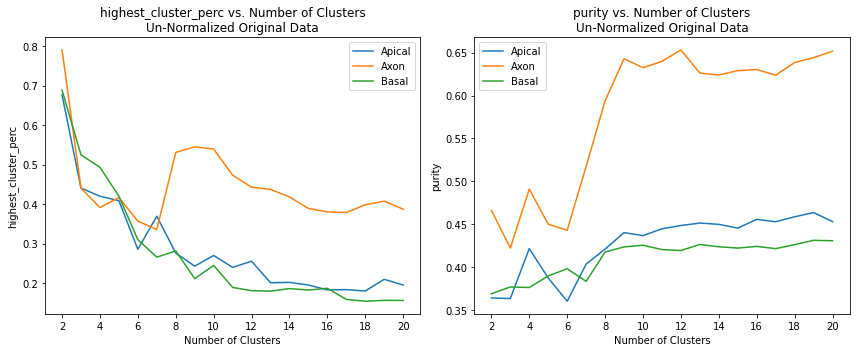

In [32]:
unscaled_columns_picked =[k for k in df_col_filtered.columns if "spine" not in k]


gmm.gmm_pipeline(df_col_filtered,
                 labeled_data_indices = labeled_data_indices,
                 title_suffix = "Un-Normalized Original Data",
                 columns_picked = unscaled_columns_picked,
                 possible_K = possible_K,
                 apply_normalization=False,
                 apply_pca=False,
                 classification_types = ["hard","soft"]
                 
                )

# -------- Part 0: Preprocessing (Column restriction, Normalization, PCA) ----------- #
Restricting to columns : ['n0_width_median_mesh_center', 'n0_skeletal_length', 'n0_parent_angle', 'n0_sibling_angle', 'n1_width_median_mesh_center', 'n1_skeletal_length', 'n1_parent_angle', 'n1_sibling_angle']
# -------- Part 1: GMM clustering with different Number of Clusters ----------- # 


------Working on clusters K=2-----
Using mixture model
Convergence status = True
Total time for GMM = 3.38175368309021


------Working on clusters K=3-----
Using mixture model
Convergence status = True
Total time for GMM = 4.094671249389648


------Working on clusters K=4-----
Using mixture model
Convergence status = True
Total time for GMM = 15.686140537261963


------Working on clusters K=5-----
Using mixture model
Convergence status = True
Total time for GMM = 8.142635345458984


------Working on clusters K=6-----
Using mixture model
Convergence status = True
Total time for GMM = 9.732555866241455


------W

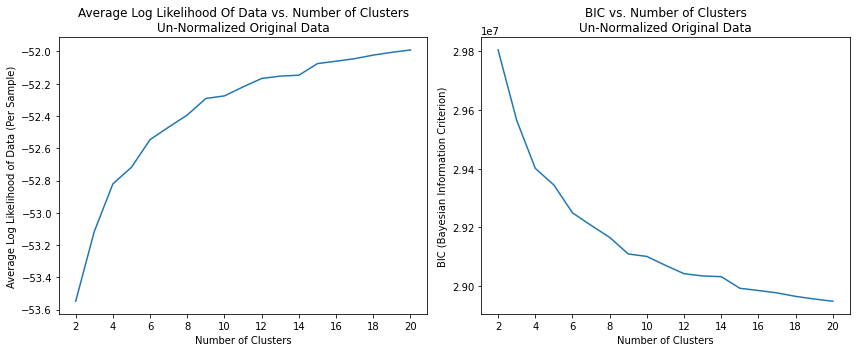

# --------- Part 2: computing the advanced statistics on the clustering ------- # 


----Working on Advanced Statistics for n_clusters = 2----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,373.202192,34635.503017,44.735340,87.467226,239.037981,16439.317065,53.402779,91.291091
1,448.119873,12734.443074,36.942303,79.468589,366.567606,50200.713667,35.584984,70.599453




Clustering Numbers By Neuroscience Category for K = 2


,classification,category,n_clusters,cl_0,cl_1
2,hard,Apical,2,2585,5415
0,hard,Axon,2,6323,1677
1,hard,Basal,2,2492,5508




Clustering Advanced Statistics By Neuroscience Category for K = 2


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,2,1,0.676875,2,0.364165
0,Axon,hard,2,0,0.790375,2,0.466281
1,Basal,hard,2,1,0.688500,2,0.369066




----Working on Advanced Statistics for n_clusters = 3----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,473.103047,9315.557635,42.078263,89.780465,354.223464,9707.484633,43.477681,84.686766
1,323.538745,47853.010250,42.835773,81.525001,202.596816,25496.378643,51.840021,91.332941
2,440.469881,13250.120140,37.096567,78.828195,359.356901,60899.357374,36.715317,67.551360




Clustering Numbers By Neuroscience Category for K = 3


,classification,category,n_clusters,cl_0,cl_1,cl_2
2,hard,Apical,3,3524,1089,3387
0,hard,Axon,3,3521,3487,992
1,hard,Basal,3,1908,1895,4197




Clustering Advanced Statistics By Neuroscience Category for K = 3


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,3,0,0.440500,2,0.363502
0,Axon,hard,3,0,0.440125,2,0.422312
1,Basal,hard,3,2,0.524625,3,0.376941




----Working on Advanced Statistics for n_clusters = 4----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,300.044229,38085.597933,43.057717,84.460300,95.111815,6390.371079,77.781659,93.289928
1,539.118578,8928.161504,40.061391,87.568507,427.726619,10667.866375,37.783193,83.502306
2,445.009481,11559.973965,36.540932,78.475541,356.506869,59706.690069,38.064364,67.522222
3,336.294357,39829.092617,44.304728,84.254799,288.069074,41718.068450,31.367595,84.732712




Clustering Numbers By Neuroscience Category for K = 4


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3
2,hard,Apical,4,505,3365,3032,1098
0,hard,Axon,4,3107,1082,841,2970
1,hard,Basal,4,1114,1447,3944,1495




Clustering Advanced Statistics By Neuroscience Category for K = 4


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,4,1,0.420625,3,0.420982
0,Axon,hard,4,0,0.388375,3,0.489672
1,Basal,hard,4,2,0.493000,3,0.376189




----Working on Advanced Statistics for n_clusters = 5----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,366.625249,40960.934332,39.478466,76.257923,168.422407,5238.405919,78.285128,90.621380
1,603.885061,8061.916468,51.258298,95.909530,362.171675,70532.288463,51.504513,81.692222
2,292.664160,45187.678294,43.872549,87.665826,235.664898,36131.192200,34.105884,92.336372
3,418.297429,15056.261382,37.088248,77.139726,356.544358,62162.134986,35.509048,65.206281
4,471.979087,8425.131609,38.794862,86.523913,377.518200,11252.301079,36.072036,81.188464




Clustering Numbers By Neuroscience Category for K = 5


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4
2,hard,Apical,5,635,1105,607,2386,3267
0,hard,Axon,5,758,347,3333,683,2879
1,hard,Basal,5,1224,310,1016,3363,2087




Clustering Advanced Statistics By Neuroscience Category for K = 5


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,5,4,0.408375,3,0.387864
0,Axon,hard,5,2,0.416625,3,0.451084
1,Basal,hard,5,3,0.420375,3,0.390338




----Working on Advanced Statistics for n_clusters = 6----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,421.079951,13754.939825,37.435240,78.215319,347.756387,71565.395130,38.911977,64.826747
1,500.544020,8127.129544,35.034133,80.094192,403.120704,15186.183139,33.387398,76.093801
2,436.535108,10115.170055,49.334864,101.593348,354.482758,9070.420446,44.970378,91.131598
3,328.974486,41667.885176,39.702753,78.045922,95.817075,5686.577003,81.788460,92.511350
4,346.101738,46049.038249,40.071874,77.661452,302.654502,37068.664687,23.795460,84.901596
5,444.701805,20809.871739,55.148302,102.099451,266.178600,66436.133126,58.810770,88.652017




Clustering Numbers By Neuroscience Category for K = 6


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5
2,hard,Apical,6,2183,2778,1195,487,774,583
0,hard,Axon,6,582,668,2581,1508,1488,1173
1,hard,Basal,6,2855,2172,444,1084,1201,244




Clustering Advanced Statistics By Neuroscience Category for K = 6


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,6,1,0.347250,4,0.372498
0,Axon,hard,6,2,0.322625,4,0.473022
1,Basal,hard,6,0,0.356875,4,0.395590




----Working on Advanced Statistics for n_clusters = 7----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,451.771258,8444.629279,35.829822,79.711039,349.364760,75180.862243,43.897789,69.103025
1,494.091215,8166.332805,53.315230,104.444984,377.525939,8724.678467,48.894649,91.179282
2,503.639020,8992.446976,35.331081,80.674666,410.141204,12851.040087,32.323886,76.542130
3,287.722524,50137.440703,42.774368,84.882173,235.272209,30188.799114,27.395981,93.006784
4,442.929463,24476.745551,55.992360,99.136922,290.625370,69161.814761,60.808387,89.762953
5,397.260012,23388.015117,39.251810,76.579325,357.372252,53943.032103,29.673581,65.718625
6,322.741521,39365.595829,40.158096,79.544158,94.334821,5765.093951,81.334095,92.830287




Clustering Numbers By Neuroscience Category for K = 7


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6
2,hard,Apical,7,1667,820,2934,381,431,1283,484
0,hard,Axon,7,429,1433,694,2476,704,378,1886
1,hard,Basal,7,1904,313,2141,731,202,1633,1076




Clustering Advanced Statistics By Neuroscience Category for K = 7


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,7,2,0.366750,4,0.399505
0,Axon,hard,7,3,0.309500,4,0.510585
1,Basal,hard,7,2,0.267625,4,0.383005




----Working on Advanced Statistics for n_clusters = 8----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,475.095248,11201.900613,35.991069,79.393066,406.492984,15224.636642,29.841682,74.601810
1,468.107085,16086.043866,62.464440,107.076651,300.005270,58567.998121,54.784832,88.618794
2,263.390266,37421.038601,45.073401,87.103117,76.968222,8492.699845,76.431446,93.963642
3,392.337164,20357.233680,39.902355,77.245717,338.936333,65559.809987,34.329538,60.233086
4,326.830146,49859.225626,40.579464,80.249072,282.948023,34896.423363,24.103281,90.868195
5,555.253040,6418.208457,39.236718,90.538535,415.566431,7885.627369,39.825928,84.719058
6,406.716796,30894.951016,38.582163,76.732531,244.734957,1945.271884,79.869423,93.566098
7,473.597111,7543.835010,34.354262,79.862966,351.869130,74251.039243,44.810039,71.878167




Clustering Numbers By Neuroscience Category for K = 8


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7
2,hard,Apical,8,2093,495,323,1276,578,1664,210,1361
0,hard,Axon,8,491,928,3306,333,1814,662,104,362
1,hard,Basal,8,1930,212,748,1550,959,620,443,1538




Clustering Advanced Statistics By Neuroscience Category for K = 8


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,8,0,0.261625,5,0.415678
0,Axon,hard,8,2,0.413250,4,0.537187
1,Basal,hard,8,0,0.241250,5,0.391323




----Working on Advanced Statistics for n_clusters = 9----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,566.854692,6532.907319,37.047633,86.954123,428.129121,8285.449876,38.577871,81.738685
1,390.048174,19966.398424,40.102327,77.714314,334.585168,66227.787441,35.218214,60.396634
2,356.499509,54291.408310,40.178854,76.145569,308.514441,37124.885712,22.634030,88.829481
3,406.759488,29597.481418,38.481778,77.049640,249.109672,1886.409255,79.732971,93.923210
4,472.790066,7549.305946,34.370226,80.030751,351.675403,74645.374942,44.913933,71.951800
5,528.892425,15520.765783,62.959183,107.130455,360.116441,58802.904562,50.556498,87.024503
6,468.154586,11886.859807,36.241616,79.435273,405.187503,16083.202213,28.785654,74.496108
7,144.201010,16744.349760,51.900227,107.820687,99.578040,16062.795830,53.956037,99.256436
8,336.784905,47885.965017,39.936796,75.005051,76.502015,6515.043457,84.360416,91.499405




Clustering Numbers By Neuroscience Category for K = 9


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8
2,hard,Apical,9,1978,1263,585,199,1336,525,1767,27,320
0,hard,Axon,9,442,346,795,97,377,608,428,4324,583
1,hard,Basal,9,905,1543,900,408,1523,207,1664,133,717




Clustering Advanced Statistics By Neuroscience Category for K = 9


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,9,0,0.24725,5,0.439856
0,Axon,hard,9,7,0.54050,5,0.641760
1,Basal,hard,9,6,0.20800,5,0.422619




----Working on Advanced Statistics for n_clusters = 10----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,396.815693,25224.549843,38.728453,80.344224,326.626670,45754.254062,34.536430,66.253580
1,396.549897,13308.615650,39.910378,77.436566,349.255932,77445.243253,35.949361,60.658087
2,557.276753,6380.733357,41.596444,92.952621,411.115651,7808.517852,41.785780,84.885189
3,403.069040,32062.811242,38.384188,76.439400,232.165955,1876.474063,81.355576,93.895290
4,159.751780,22651.422596,51.024860,105.117319,108.014013,16633.981727,53.419849,100.228753
5,522.309775,16491.755696,67.442734,107.301907,362.061215,65648.303804,50.799469,88.598006
6,361.618244,55953.671272,40.348739,74.689394,318.189758,38404.943073,20.678903,90.600977
7,483.428307,10282.166368,35.497242,79.239634,409.616136,13875.651099,30.095446,75.153024
8,330.917733,46831.599177,39.692429,75.051098,71.937535,6614.579039,84.527221,91.372606
9,509.276830,6783.057101,32.881769,81.622033,353.643214,72067.875512,48.085879,74.646146




Clustering Numbers By Neuroscience Category for K = 10


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9
2,hard,Apical,10,834,1106,1416,195,46,360,465,2159,291,1128
0,hard,Axon,10,447,241,548,87,4288,492,508,487,624,278
1,hard,Basal,10,903,1549,495,406,177,143,815,1959,675,878




Clustering Advanced Statistics By Neuroscience Category for K = 10


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,10,7,0.269875,5,0.435718
0,Axon,hard,10,4,0.536000,5,0.629817
1,Basal,hard,10,7,0.244875,6,0.424693




----Working on Advanced Statistics for n_clusters = 11----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,625.754020,9834.316159,33.182630,89.001861,346.608709,80794.784615,57.015407,81.272990
1,524.709269,7334.357374,35.211372,81.764672,418.030656,9743.334949,33.942790,78.126033
2,129.280341,9998.308026,53.708166,109.737370,90.381183,11725.383233,54.508543,97.735894
3,393.313629,22649.269961,39.483447,77.255932,342.017816,67929.899159,35.327253,58.529598
4,358.927018,41014.329427,39.402164,74.723030,98.281465,4969.267352,83.349777,91.373859
5,362.835995,47900.549103,40.149243,73.503514,326.473018,39980.199660,18.894615,88.118969
6,458.427162,15318.363992,37.209842,80.438137,401.979249,20778.163428,28.022878,73.273465
7,415.748215,7714.863452,36.947166,77.947181,343.545805,71213.604257,40.817127,68.416494
8,241.668780,58860.450872,43.258192,90.586438,146.387332,22720.545241,51.568715,97.220261
9,628.696337,9011.629804,55.055158,103.191917,506.842168,7039.915328,54.091645,91.662991




Clustering Numbers By Neuroscience Category for K = 11


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10
2,hard,Apical,11,1056,2284,9,770,459,461,1226,974,99,413,249
0,hard,Axon,11,123,499,3342,206,544,383,300,371,1550,158,524
1,hard,Basal,11,206,1560,72,1024,1014,760,1040,1731,240,186,167




Clustering Advanced Statistics By Neuroscience Category for K = 11


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,11,1,0.285500,6,0.466298
0,Axon,hard,11,2,0.417750,5,0.658413
1,Basal,hard,11,7,0.216375,6,0.436018




----Working on Advanced Statistics for n_clusters = 12----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,373.877532,35493.928786,37.441260,79.807765,354.975936,20313.616922,18.899599,86.671151
1,595.475967,6425.005439,40.531434,91.898136,437.096493,7354.990243,42.473934,84.137660
2,431.647373,8174.268590,35.485921,78.474616,344.860127,84824.520599,42.717327,66.447567
3,322.017222,45662.279804,40.048523,76.455442,71.362817,7039.366324,84.377366,92.092323
4,517.526828,6734.634603,35.504686,81.097454,385.590896,27810.011923,40.940881,77.830435
5,602.320948,11290.120296,80.411689,109.536227,479.161563,36715.724698,51.619046,85.936856
6,399.665623,32766.936696,38.300483,76.497892,179.566819,1869.582156,83.265738,94.596320
7,317.833222,63170.235568,43.970441,80.044752,242.419364,47394.412460,32.919637,90.829617
8,478.641051,10802.656010,35.874205,79.530618,407.705818,10910.395082,28.802279,74.397677
9,126.250332,10253.012100,54.766370,111.488902,92.762813,15530.393570,52.422407,97.528064




Clustering Numbers By Neuroscience Category for K = 12


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11
2,hard,Apical,12,481,1251,892,292,938,264,194,317,1759,6,1038,568
0,hard,Axon,12,685,263,292,808,221,205,93,886,385,3641,288,233
1,hard,Basal,12,663,427,1404,661,757,104,411,494,1519,68,1313,179




Clustering Advanced Statistics By Neuroscience Category for K = 12


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,12,8,0.219875,6,0.445600
0,Axon,hard,12,9,0.455125,5,0.620679
1,Basal,hard,12,8,0.189875,7,0.420618




----Working on Advanced Statistics for n_clusters = 13----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,587.136850,6018.039207,38.304947,88.603045,446.831218,7867.725558,37.829451,82.681934
1,400.627553,20264.644282,39.217853,77.771695,352.060399,80742.925473,37.189592,58.635441
2,322.926020,50903.802323,41.817783,72.606764,65.411985,7057.892657,84.343534,90.439973
3,400.434683,11745.537547,39.720718,77.982818,336.122646,53227.021245,36.421993,67.329365
4,512.469005,7036.445340,33.122695,82.640095,345.682066,80561.455726,49.293012,74.696206
5,398.521328,25263.294923,36.538123,80.739305,380.597094,19050.778277,22.326104,81.069013
6,280.604207,68098.842506,43.887101,86.371879,154.755285,15300.562816,54.827935,99.419398
7,485.754547,9554.693567,35.653941,79.307019,404.418284,14668.686096,31.859219,74.462847
8,353.980565,53822.885984,40.911676,74.696174,303.711816,52620.793980,19.890014,84.842852
9,346.930668,16432.952248,33.441800,88.233122,108.056516,4750.136321,80.767713,92.642904




Clustering Numbers By Neuroscience Category for K = 13


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12
2,hard,Apical,13,1554,859,231,780,1116,582,108,1743,351,109,402,4,161
0,hard,Axon,13,318,181,412,309,245,482,884,390,398,541,465,3313,62
1,hard,Basal,13,609,1084,523,1097,814,685,237,1593,592,213,138,58,357




Clustering Advanced Statistics By Neuroscience Category for K = 13


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,13,7,0.217875,6,0.443391
0,Axon,hard,13,11,0.414125,7,0.626715
1,Basal,hard,13,7,0.199125,7,0.417638




----Working on Advanced Statistics for n_clusters = 14----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,536.483353,14761.918235,46.629483,96.881572,508.041031,3066.869979,62.062791,96.920210
1,345.634970,51089.759758,40.888976,74.185689,295.426491,52732.257693,18.612647,85.177183
2,573.287500,6309.521783,35.462665,85.525705,433.160167,7662.688266,38.450575,81.340276
3,426.386398,7584.614951,35.302521,77.980124,344.115598,90214.873849,42.763791,66.657573
4,349.402678,65333.868013,41.128427,73.119129,195.033039,9289.973887,63.209805,93.262828
5,499.791508,7025.295679,35.280925,80.586964,372.244766,34604.985033,42.668254,77.338894
6,547.431219,20927.787223,33.523546,85.564002,333.436121,98340.892271,52.643363,74.904220
7,467.695342,11053.516118,36.732654,79.307103,400.464092,13317.398595,29.246470,72.763465
8,386.393140,18524.974172,40.378075,77.192734,343.194998,64373.349914,34.880972,60.009524
9,385.342895,26822.881165,37.015471,80.517981,372.002891,20500.924233,21.736832,84.282975




Clustering Numbers By Neuroscience Category for K = 14


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13
2,hard,Apical,14,197,313,1602,595,143,769,677,1454,901,486,400,10,84,369
0,hard,Axon,14,65,373,308,226,279,220,81,310,228,594,629,3621,789,277
1,hard,Basal,14,105,549,737,1135,335,689,180,1335,1144,599,882,68,98,144




Clustering Advanced Statistics By Neuroscience Category for K = 14


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,14,2,0.200250,7,0.455884
0,Axon,hard,14,11,0.452625,7,0.634841
1,Basal,hard,14,7,0.166875,7,0.426579




----Working on Advanced Statistics for n_clusters = 15----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,403.156792,23227.075953,36.423667,79.923483,392.812031,15118.253194,20.004790,83.141397
1,618.692912,5349.195341,43.533256,94.725014,463.311056,8014.370867,39.508536,83.605866
2,380.229296,26846.800079,38.396719,99.169506,277.587833,86757.504780,44.943560,82.405479
3,270.452766,68495.977054,45.581374,85.879054,142.350137,14127.245420,56.808210,100.203316
4,412.881808,9473.800143,36.504604,77.461114,343.829144,84044.964530,40.098808,64.092051
5,396.502921,34208.765983,38.790624,76.056138,177.321818,1850.910463,83.393141,94.414747
6,490.318047,9550.486380,35.419034,79.577056,415.354087,9749.801085,29.203911,74.478188
7,120.101880,9157.165069,58.179147,110.866408,90.692387,16867.525742,50.462850,97.024532
8,355.670288,54782.669726,41.029307,73.760764,308.350835,46369.389411,19.706499,85.557953
9,389.856496,21601.796596,40.650137,77.107073,341.200174,58635.846512,34.071060,60.665868




Clustering Numbers By Neuroscience Category for K = 15


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14
2,hard,Apical,15,494,927,294,99,797,177,1630,3,371,854,1229,619,212,191,103
0,hard,Axon,15,399,237,709,855,273,82,366,3150,311,223,245,98,316,111,625
1,hard,Basal,15,576,310,187,233,1428,389,1373,54,600,1023,853,217,494,87,176




Clustering Advanced Statistics By Neuroscience Category for K = 15


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,15,6,0.20375,7,0.448095
0,Axon,hard,15,7,0.39375,7,0.631930
1,Basal,hard,15,4,0.17850,8,0.426405




----Working on Advanced Statistics for n_clusters = 16----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,519.384708,5986.662342,34.781164,80.426033,387.832019,23428.749898,40.865055,77.562157
1,394.075363,10714.363884,39.944082,77.907699,349.060197,85361.966198,40.897699,61.424530
2,293.417890,68588.100932,41.177033,77.173017,143.473341,11975.942899,59.396276,97.796292
3,400.075079,32005.214013,38.144191,76.564089,174.038861,1865.217913,83.408848,94.407926
4,676.810261,12102.689102,78.485885,104.999946,569.987345,23850.896404,60.026607,92.243229
5,409.383144,13945.873770,39.605855,78.689694,341.711756,43180.521254,35.407034,68.884223
6,614.777391,14768.785331,33.964540,88.713195,337.879494,93815.019109,58.337697,80.928989
7,609.747982,6021.085890,45.945236,97.699489,442.256560,7528.249731,43.983800,84.852988
8,325.111137,43396.109790,39.961144,75.936179,67.644751,6673.148068,84.500221,91.125905
9,408.853452,20768.327001,36.238667,80.681392,395.894443,14030.929291,20.187929,81.453806




Clustering Numbers By Neuroscience Category for K = 16


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15
2,hard,Apical,16,847,572,112,193,157,696,729,804,261,527,381,305,187,3,504,1722
0,hard,Axon,16,202,141,674,90,85,261,73,233,642,388,158,248,981,3338,135,351
1,hard,Basal,16,736,797,265,405,63,773,122,279,588,639,651,521,174,57,692,1238




Clustering Advanced Statistics By Neuroscience Category for K = 16


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,16,15,0.21525,8,0.457167
0,Axon,hard,16,13,0.41725,7,0.636093
1,Basal,hard,16,15,0.15475,9,0.426592




----Working on Advanced Statistics for n_clusters = 17----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,399.592595,32102.691010,38.089159,76.707268,163.538582,1868.674082,83.544754,94.474114
1,388.728615,28351.582095,40.689915,77.141716,349.401304,66931.724469,31.253571,59.004085
2,500.501734,5367.300604,31.628858,81.100543,340.643335,92740.117475,47.454555,72.319149
3,491.559324,9422.743940,35.759557,79.764549,411.914853,10267.823987,30.247693,74.743582
4,124.416935,9519.572480,55.877480,111.270375,89.388423,14529.176329,53.096424,97.530991
5,324.324231,43939.061563,40.037394,75.651921,67.565364,6738.789308,84.467892,91.044499
6,610.913498,5962.685208,38.850816,91.770301,452.254983,7191.690836,41.632028,84.026767
7,514.745182,6271.399562,34.822643,80.692111,383.033644,26761.920246,42.166305,77.377779
8,642.437226,8207.603911,75.567755,108.473187,383.250041,45113.125674,46.876696,78.273949
9,399.458023,9863.883510,39.021637,77.854145,348.736646,89097.114761,40.772114,61.597523




Clustering Numbers By Neuroscience Category for K = 17


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16
2,hard,Apical,17,186,518,434,1687,4,257,1045,803,275,548,291,111,550,487,119,593,92
0,hard,Axon,17,87,128,109,357,3338,620,228,176,149,147,233,572,394,62,1053,266,81
1,hard,Basal,17,398,655,389,1324,60,589,346,690,108,884,493,250,642,141,149,812,70




Clustering Advanced Statistics By Neuroscience Category for K = 17


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,17,3,0.210875,9,0.453759
0,Axon,hard,17,4,0.417250,7,0.641773
1,Basal,hard,17,3,0.165500,9,0.423579




----Working on Advanced Statistics for n_clusters = 18----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,400.559058,8519.336959,36.419511,76.228838,321.567204,67563.353494,38.395390,67.712136
1,618.226449,4898.930654,39.889715,91.800414,464.039210,8227.432390,38.662097,82.463315
2,272.458299,57804.159895,41.665150,81.086361,136.520165,11709.763848,55.217828,98.453826
3,550.405896,4666.625050,37.410260,87.279255,343.249809,80175.061794,53.003914,76.802402
4,407.706034,20094.778167,35.361825,80.540731,396.492057,15965.829260,19.778098,83.328216
5,391.446636,12327.477265,39.112382,77.752857,354.986119,89967.425410,38.654777,59.578297
6,396.384869,34532.409935,38.643467,76.228915,152.902472,1836.786371,83.655244,94.339289
7,359.527002,53399.699941,40.423235,73.265800,320.736569,43532.893181,18.661677,87.298427
8,122.173918,9134.986537,56.812917,111.656160,87.774664,15245.336898,52.990467,97.060884
9,522.239236,8260.027114,35.864423,82.086855,389.138031,26909.055959,43.238477,79.680706




Clustering Numbers By Neuroscience Category for K = 18


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17
2,hard,Apical,18,364,892,101,531,493,546,168,...,1,1074,247,169,439,625,56,226,1562,179
0,hard,Axon,18,251,192,891,116,389,118,72,...,3226,182,590,73,59,164,190,81,343,830
1,hard,Basal,18,854,343,253,259,550,768,356,...,54,651,569,50,197,794,59,251,1292,154




Clustering Advanced Statistics By Neuroscience Category for K = 18


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,18,16,0.19525,9,0.456473
0,Axon,hard,18,8,0.40325,7,0.641349
1,Basal,hard,18,16,0.16150,10,0.424073




----Working on Advanced Statistics for n_clusters = 19----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,303.338023,22778.222156,54.317199,107.799882,259.202502,54090.338542,34.382328,83.561350
1,405.864269,55652.778582,39.265303,76.160700,438.291863,1911.831306,73.534621,94.594034
2,508.163937,8856.133399,35.303585,80.556310,424.734638,8329.310075,30.299760,75.945148
3,548.770831,3991.788423,38.044114,87.202456,348.146631,77555.176624,52.147803,77.742779
4,275.152301,53797.971185,40.513269,81.505841,136.663768,11275.029018,58.862687,99.166905
5,429.197781,13029.626276,39.004427,78.396615,362.104450,33013.559190,34.179468,69.287830
6,389.737652,13352.531801,40.112764,78.301125,353.309515,87583.217466,38.246127,58.672320
7,400.380717,26674.610110,37.746038,77.035918,148.985203,1871.782021,83.656682,94.218764
8,709.281505,10264.140967,82.187350,108.754513,479.614184,18639.904644,56.583953,92.298359
9,416.421639,20305.272915,36.588892,78.789845,402.163862,12913.250257,19.581871,81.381644




Clustering Numbers By Neuroscience Category for K = 19


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17,cl_18
2,hard,Apical,19,192,40,1634,445,109,704,532,...,510,2,57,418,262,303,569,312,535,993
0,hard,Axon,19,985,23,335,99,938,205,107,...,243,3113,287,130,523,221,75,177,190,176
1,hard,Basal,19,178,105,1186,234,259,734,665,...,557,52,59,612,578,518,187,848,202,619




Clustering Advanced Statistics By Neuroscience Category for K = 19


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,19,2,0.204250,10,0.456870
0,Axon,hard,19,10,0.389125,7,0.646048
1,Basal,hard,19,2,0.148250,10,0.430730




----Working on Advanced Statistics for n_clusters = 20----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,334.019014,45670.376773,40.513729,73.672660,66.379451,6613.938927,84.624833,90.396548
1,456.751337,25241.364041,37.707214,78.778418,507.992074,2096.212131,66.244161,95.850941
2,384.743017,16866.785182,39.092877,76.589392,357.863686,80320.308719,36.089333,57.358657
3,415.616343,19595.527137,41.686808,79.045577,360.262825,30056.523439,34.915901,65.738130
4,568.302183,3249.864153,40.487436,90.297708,355.270321,67514.849638,52.414600,78.875625
5,323.991669,61986.567378,60.991648,98.971497,246.305737,78834.985923,49.119915,90.892222
6,509.772795,6874.982933,34.564433,79.967351,388.284457,22426.281740,40.222162,78.637845
7,274.016121,56464.747404,40.787948,83.996236,131.799826,11527.624067,61.567129,98.597790
8,617.901247,5808.142023,37.182536,89.439754,445.778372,7169.814012,43.189124,83.713487
9,378.500114,35816.658949,41.034008,76.869569,325.878843,69371.538250,28.087284,68.156579




Clustering Numbers By Neuroscience Category for K = 20


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17,cl_18,cl_19
2,hard,Apical,20,254,71,427,657,378,104,819,...,279,168,5,3,304,1422,590,493,270,382
0,hard,Axon,20,397,23,95,143,102,470,185,...,152,79,1713,2145,213,298,73,134,243,290
1,hard,Basal,20,558,91,653,592,186,97,712,...,92,370,41,36,651,1087,203,722,464,462




Clustering Advanced Statistics By Neuroscience Category for K = 20


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,20,15,0.177750,10,0.461405
0,Axon,hard,20,13,0.268125,8,0.660598
1,Basal,hard,20,15,0.135875,11,0.431377


# -------- Part 3: Plotting the Advanced Cluster Statistics -------------- # 


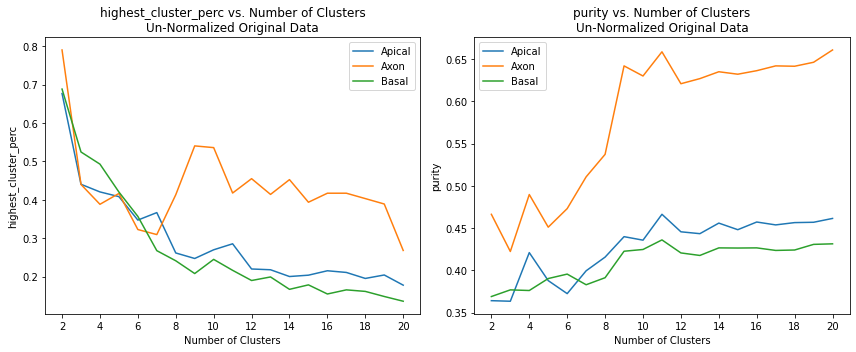

In [33]:
unscaled_columns_picked =[k for k in df_col_filtered.columns if "spine" not in k]


gmm.gmm_pipeline(df_col_filtered,
                 labeled_data_indices = labeled_data_indices,
                 title_suffix = "Un-Normalized Original Data",
                 columns_picked = unscaled_columns_picked,
                 possible_K = possible_K,
                 apply_normalization=False,
                 apply_pca=False,
                 classification_types = ["hard"]
                 
                )

# Part 3: GMM on Normalized Dataset (Original Basis)

# -------- Part 0: Preprocessing (Column restriction, Normalization, PCA) ----------- #
Applying Normalization
# -------- Part 1: GMM clustering with different Number of Clusters ----------- # 


------Working on clusters K=2-----
Using mixture model
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 5.512848377227783


------Working on clusters K=3-----
Using mixture model
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 12.099501848220825


------Working on clusters K=4-----
Using mixture model
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 34.93413591384888


------Working on clusters K=5-----
Using mixture model
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 42.2992639541626


------Working on clusters K=6-----
Using mixture model
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 50.700500

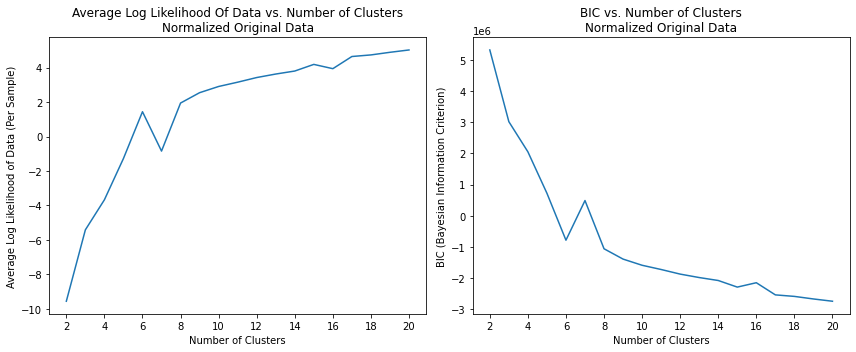

# --------- Part 2: computing the advanced statistics on the clustering ------- # 


----Working on Advanced Statistics for n_clusters = 2----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,328.877947,309.407953,12.000557,8.525600e+08,3.203156e+07,20160.450639,29835.720268,43.846738,86.907366,170.946271,170.942574,0.000901,6.464168e+04,3.123190e+03,3.977930,11171.922075,61.802160,91.297341
1,454.013731,437.483697,7.689772,5.626006e+08,4.669047e+07,22553.820058,18238.239957,38.567281,80.993106,373.605239,329.945347,26.524595,1.731996e+09,5.040211e+07,38678.156277,46871.311283,35.055111,73.951255




Clustering Numbers By Neuroscience Category for K = 2


,classification,category,n_clusters,cl_0,cl_1
2,hard,Apical,2,1323,6677
0,hard,Axon,2,6012,1988
1,hard,Basal,2,1791,6209




Clustering Advanced Statistics By Neuroscience Category for K = 2


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,2,1,0.834625,1,0.398641
0,Axon,hard,2,0,0.751500,2,0.528285
1,Basal,hard,2,1,0.776125,2,0.367922




----Working on Advanced Statistics for n_clusters = 3----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,468.788438,464.336084,2.087830,1.225896e+08,3.377053e+07,9926.398913,9949.539007,38.917240,82.374099,379.168603,341.756490,25.678992,1.686712e+09,5.183108e+07,35252.994545,47520.139307,37.758489,74.030230
1,426.188107,385.383058,18.823830,1.456476e+09,7.304065e+07,48819.490908,34641.562329,37.880221,78.303835,362.653499,306.824531,28.091985,1.814745e+09,4.738904e+07,45294.575961,45230.913764,29.807810,73.838366
2,327.360714,308.239447,11.952315,8.325657e+08,3.128386e+07,19043.152867,29839.894362,43.860586,86.895687,170.267068,170.267068,0.000037,6.034025e+01,6.034012e+01,0.015349,11355.205030,61.813992,91.317550




Clustering Numbers By Neuroscience Category for K = 3


,classification,category,n_clusters,cl_0,cl_1,cl_2
2,hard,Apical,3,5102,1596,1302
0,hard,Axon,3,1371,602,6027
1,hard,Basal,3,4115,2107,1778




Clustering Advanced Statistics By Neuroscience Category for K = 3


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,3,0,0.637750,2,0.404539
0,Axon,hard,3,2,0.753375,2,0.531296
1,Basal,hard,3,0,0.514375,3,0.372205




----Working on Advanced Statistics for n_clusters = 4----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,413.138842,368.633816,2.236665e+01,1.650130e+09,5.682948e+07,4.318472e+04,40920.899598,38.732364,77.893972,356.744657,302.725937,25.021047,1.551482e+09,4.873633e+07,45034.401942,44930.011516,28.294817,75.852560
1,376.060106,345.233798,1.900886e+01,1.351055e+09,5.048708e+07,3.187208e+04,41318.284357,40.008012,78.646575,171.083670,171.077944,0.001206,1.022253e+05,4.315171e+03,6.216707,7402.386174,68.255426,90.607232
2,465.566374,455.935256,3.666505e+00,2.610763e+08,6.125061e+07,2.180275e+04,12084.057131,38.095007,80.972715,379.926638,335.272161,29.354579,1.937688e+09,4.997754e+07,38657.173087,49037.984820,36.547614,71.770342
3,382.143703,382.143703,1.865175e-13,1.394749e-05,9.164214e-07,4.765752e-10,7838.327121,43.957828,91.367306,293.118193,276.092706,12.658055,8.546794e+08,3.147355e+07,18350.081588,33105.258546,44.190504,83.323238




Clustering Numbers By Neuroscience Category for K = 4


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3
2,hard,Apical,4,1097,955,3972,1976
0,hard,Axon,4,522,1437,818,5223
1,hard,Basal,4,1650,1460,3203,1687




Clustering Advanced Statistics By Neuroscience Category for K = 4


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,4,2,0.496500,3,0.377266
0,Axon,hard,4,3,0.652875,2,0.471639
1,Basal,hard,4,2,0.400375,3,0.373750




----Working on Advanced Statistics for n_clusters = 5----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,495.883421,487.780274,3.149834e+00,2.098290e+08,5.646020e+07,1.698374e+04,11640.386905,37.935999,82.123437,409.806721,378.061777,9.287170e+00,7.269868e+08,6.304633e+07,3.990137e+04,17492.707842,33.905983,77.012421
1,313.340963,292.631708,1.295354e+01,9.027322e+08,3.384504e+07,2.066524e+04,31544.993460,43.625049,86.198488,150.732626,150.732626,6.821210e-13,4.339218e-05,1.251698e-06,9.713403e-10,9498.858166,63.719869,91.951819
2,481.561077,428.545280,2.895333e+01,2.189772e+09,7.573392e+07,5.888585e+04,54710.582364,38.842668,81.685935,402.890758,357.381124,1.585123e+01,1.096372e+09,5.572003e+07,4.886528e+04,36945.799235,32.367210,82.275613
3,413.668816,389.496791,1.079138e+01,8.045646e+08,5.968207e+07,3.210071e+04,22310.963668,38.488772,78.368470,346.599209,288.630596,4.173731e+01,2.613253e+09,3.968528e+07,3.959803e+04,68453.863309,34.164051,69.126940
4,474.129493,474.129493,1.403322e-13,1.025200e-05,6.183982e-07,2.983143e-10,6375.667106,40.386169,85.936489,372.370097,347.006963,1.878401e+01,1.268224e+09,4.616671e+07,2.713428e+04,42415.985146,39.641215,77.823826




Clustering Numbers By Neuroscience Category for K = 5


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4
2,hard,Apical,5,2475,1025,469,2164,1867
0,hard,Axon,5,440,5512,271,643,1134
1,hard,Basal,5,1625,1671,411,2825,1468




Clustering Advanced Statistics By Neuroscience Category for K = 5


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,5,0,0.309375,3,0.409976
0,Axon,hard,5,1,0.689000,2,0.521142
1,Basal,hard,5,3,0.353125,4,0.370976




----Working on Advanced Statistics for n_clusters = 6----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,413.539203,389.920864,1.045508e+01,7.799694e+08,5.972849e+07,3.179099e+04,21823.825557,38.503084,78.395634,346.464150,288.566319,4.184405e+01,2.621159e+09,3.965081e+07,3.955160e+04,68659.512343,34.302818,68.976540
1,497.026847,489.020930,3.122813e+00,2.064723e+08,5.602127e+07,1.679450e+04,11602.974607,37.947742,82.160343,410.445188,378.965216,9.175927e+00,7.182491e+08,6.305003e+07,3.972818e+04,17335.274036,33.917876,77.076131
2,475.959964,475.959964,-4.121148e-13,-2.956390e-05,-1.944602e-06,-1.044100e-09,6207.984919,39.475539,84.628794,376.971684,347.773973,2.160822e+01,1.458830e+09,5.309825e+07,3.123159e+04,43685.563325,39.559005,76.849947
3,388.281365,355.461157,2.040528e+01,1.423230e+09,5.358711e+07,3.266347e+04,39773.660131,39.425952,77.892521,173.024103,173.024103,-1.172396e-12,-7.557869e-05,-2.250075e-06,-1.717126e-09,7199.088063,68.776838,89.625659
4,239.621041,239.621041,7.851497e-13,5.662441e-05,3.777444e-06,1.939043e-09,15234.473555,50.147019,99.723104,166.299862,166.299862,5.108802e-12,1.111031e-04,3.457069e-06,2.426532e-09,17172.291023,52.033402,93.767484
5,471.732202,419.014075,2.898259e+01,2.189649e+09,7.464642e+07,5.816909e+04,54572.018809,38.572872,81.026236,383.105746,335.824342,1.667784e+01,1.146482e+09,5.625914e+07,4.955133e+04,38061.540516,31.147632,81.933804




Clustering Numbers By Neuroscience Category for K = 6


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5
2,hard,Apical,6,2161,2453,1605,927,377,477
0,hard,Axon,6,639,432,610,950,5080,289
1,hard,Basal,6,2800,1605,1367,1423,360,445




Clustering Advanced Statistics By Neuroscience Category for K = 6


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,6,1,0.306625,4,0.420741
0,Axon,hard,6,4,0.635000,3,0.624649
1,Basal,hard,6,0,0.350000,4,0.411854




----Working on Advanced Statistics for n_clusters = 7----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,474.524612,474.524612,-9.414691e-14,-6.437302e-06,-3.948808e-07,-2.000888e-10,6325.589261,40.447179,86.004677,372.806416,347.604957,1.870425e+01,1.263002e+09,4.578913e+07,2.691722e+04,42408.380820,39.694551,77.861480
1,498.748976,475.256997,6.696316e+00,5.885543e+08,9.098252e+07,4.091580e+04,15784.477158,36.561671,81.513403,428.842864,385.851695,7.852728e+00,6.906482e+08,7.646849e+07,5.474327e+04,13022.363766,30.906913,79.084545
2,504.973822,501.780628,1.858831e+00,5.928785e+07,3.076420e+07,6.159130e+03,9986.743935,38.844964,82.937058,397.706875,371.488811,1.155193e+01,8.139137e+08,5.335121e+07,3.198877e+04,23938.315807,36.690176,76.732052
3,404.174232,350.173593,3.149355e+01,2.273731e+09,5.139311e+07,4.701082e+04,56328.382168,39.108991,77.682912,345.598522,297.192877,2.454216e+01,1.467377e+09,3.714132e+07,3.616401e+04,47080.500125,27.758411,79.033856
4,416.703169,399.856445,6.889659e+00,5.197150e+08,6.516850e+07,2.878191e+04,16732.676202,38.520749,78.779234,349.564187,289.568464,4.605000e+01,2.920554e+09,4.055093e+07,4.057454e+04,74573.435099,36.198695,66.512667
5,312.508602,291.742667,1.299152e+01,9.049844e+08,3.371109e+07,2.063316e+04,31677.259544,43.616504,86.172957,149.687292,149.687292,1.289635e-12,8.201599e-05,2.443790e-06,1.815351e-09,9471.271460,63.807136,91.989114
6,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497088e+04,40094.270000,58.480000,103.230000




Clustering Numbers By Neuroscience Category for K = 7


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6
2,hard,Apical,7,1871,1150,1605,522,1829,1023,0
0,hard,Axon,7,1142,195,335,390,435,5503,0
1,hard,Basal,7,1468,870,1030,784,2184,1664,0




Clustering Advanced Statistics By Neuroscience Category for K = 7


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,7,0,0.233875,4,0.410769
0,Axon,hard,7,5,0.687875,2,0.521972
1,Basal,hard,7,4,0.273000,5,0.369088




----Working on Advanced Statistics for n_clusters = 8----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,395.091345,345.564234,2.986257e+01,2.158236e+09,5.207937e+07,4.562130e+04,53869.424686,39.106588,76.983555,323.408422,275.168547,2.706168e+01,1.597197e+09,3.655706e+07,3.500090e+04,50576.863226,26.716758,77.248717
1,532.392559,505.318433,6.797244e+00,5.922085e+08,8.984843e+07,4.206740e+04,15476.568966,36.733062,83.124662,458.286817,415.763941,7.500763e+00,6.712982e+08,8.132635e+07,5.618224e+04,12651.572623,32.342653,80.891035
2,387.521459,354.589069,2.050280e+01,1.429741e+09,5.331243e+07,3.266550e+04,39993.166515,39.400747,77.833255,172.375752,172.375752,-4.547474e-13,-3.075600e-05,-8.493662e-07,-6.657501e-10,6968.315564,68.913415,89.657916
3,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497088e+04,40094.270000,58.480000,103.230000
4,487.233312,484.613067,1.700127e+00,4.360479e+07,2.522225e+07,4.788649e+03,9775.535849,38.931576,82.489236,379.219500,347.743543,2.113926e+01,1.372155e+09,4.821272e+07,3.181091e+04,43098.076678,38.510357,75.110153
5,416.001761,399.107056,6.657302e+00,5.174977e+08,7.287919e+07,3.083078e+04,16399.074055,38.261246,78.605843,356.123264,297.008534,4.061933e+01,2.629005e+09,4.327000e+07,4.224081e+04,63288.674751,34.985919,66.878160
6,475.932102,475.932102,-5.702105e-13,-4.005432e-05,-2.682209e-06,-1.371518e-09,6155.790116,39.463744,84.613168,376.549188,347.359969,2.165624e+01,1.462082e+09,5.284478e+07,3.114940e+04,43885.261831,39.576978,76.816735
7,239.603246,239.603246,7.069900e-13,5.149841e-05,3.419816e-06,1.746230e-09,15245.084686,50.138514,99.717645,166.293012,166.293012,1.506351e-12,9.703636e-05,2.875924e-06,2.277375e-09,17274.067622,52.029571,93.772862




Clustering Numbers By Neuroscience Category for K = 8


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7
2,hard,Apical,8,551,1203,916,0,1622,1729,1602,377
0,hard,Axon,8,404,168,932,0,407,402,603,5084
1,hard,Basal,8,913,720,1418,0,1166,2059,1364,360




Clustering Advanced Statistics By Neuroscience Category for K = 8


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,8,5,0.216125,5,0.423994
0,Axon,hard,8,7,0.635500,3,0.624930
1,Basal,hard,8,5,0.257375,5,0.411338




----Working on Advanced Statistics for n_clusters = 9----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,431.142647,425.469328,2.589853e+00,1.469965e+08,5.250709e+07,1.348591e+04,10771.981229,38.817158,80.230866,348.279957,293.751544,4.491995e+01,2.840607e+09,4.069754e+07,3.823602e+04,76998.670257,40.370968,68.804945
1,473.800994,473.800994,-4.369838e-13,-3.111362e-05,-1.996756e-06,-1.007720e-09,6129.592090,39.414156,84.540686,376.591506,347.306950,2.167848e+01,1.464248e+09,5.305753e+07,3.128346e+04,43581.959083,39.552221,76.765584
2,386.843007,353.968241,2.050391e+01,1.430810e+09,5.342074e+07,3.269204e+04,39774.358866,39.373908,77.779464,166.110667,166.110667,-8.206769e-13,-5.221367e-05,-1.497567e-06,-1.138687e-09,7043.062572,68.921701,89.662482
3,374.813326,334.532705,3.503652e+01,2.377651e+09,3.912558e+07,3.316864e+04,70268.754117,40.554403,77.972340,292.529292,264.300527,1.623407e+01,8.403054e+08,3.366032e+07,2.409039e+04,48791.549238,27.345099,81.084630
4,411.773139,376.938615,1.375290e+01,1.100381e+09,6.819014e+07,4.462570e+04,25082.758495,37.921570,77.431774,360.457678,295.754738,3.703065e+01,2.379784e+09,4.291155e+07,4.503631e+04,55348.968953,30.495454,68.882056
5,507.202726,499.772002,2.931722e+00,1.825542e+08,5.337591e+07,1.539618e+04,11431.323468,37.826568,82.498073,415.761289,390.645270,6.551728e+00,5.206175e+08,6.444591e+07,3.683695e+04,13559.820684,33.270715,77.944185
6,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497088e+04,40094.270000,58.480000,103.230000
7,604.817834,557.528772,8.671225e+00,8.326204e+08,1.151974e+08,6.972921e+04,15425.517583,37.133941,85.639627,516.659792,459.443249,1.686472e+01,1.453738e+09,8.281139e+07,7.197286e+04,25812.258454,37.482154,81.125359
8,239.731951,239.731951,7.833734e-13,5.686283e-05,3.777444e-06,1.902663e-09,15227.506434,50.151215,99.729118,166.759192,166.759192,1.659117e-12,1.075268e-04,3.188848e-06,2.404704e-09,17144.345364,52.048400,93.776575




Clustering Numbers By Neuroscience Category for K = 9


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8
2,hard,Apical,9,1315,1600,910,281,1100,1988,0,428,378
0,hard,Axon,9,339,594,931,373,273,341,0,69,5080
1,hard,Basal,9,1378,1365,1407,457,1607,1188,0,237,361




Clustering Advanced Statistics By Neuroscience Category for K = 9


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,9,5,0.248500,5,0.427443
0,Axon,hard,9,8,0.635000,3,0.628568
1,Basal,hard,9,4,0.200875,5,0.414262




----Working on Advanced Statistics for n_clusters = 10----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,473.738525,473.738525,-3.907985e-13,-2.777576e-05,-1.855195e-06,-9.604264e-10,6133.179693,39.411958,84.542136,376.600388,347.334215,2.167084e+01,1.463603e+09,5.308905e+07,3.128551e+04,43577.533195,39.549993,76.767381
1,429.028432,422.762984,2.770369e+00,1.672138e+08,5.587297e+07,1.501203e+04,11015.823799,38.620306,80.048019,346.417763,291.379261,4.639304e+01,2.930919e+09,4.036532e+07,3.816707e+04,79373.765742,40.310265,68.335519
2,467.273289,447.672523,6.479306e+00,5.404534e+08,8.035951e+07,3.376446e+04,16032.154366,36.818596,80.342666,414.241215,368.231682,9.807088e+00,8.330828e+08,6.890665e+07,5.170539e+04,15502.398331,30.297325,76.707525
3,525.779255,522.808586,1.770821e+00,4.933028e+07,2.742826e+07,5.316415e+03,9833.180104,38.740841,83.697827,413.036405,394.145685,6.724454e+00,4.801980e+08,5.721244e+07,2.878887e+04,15738.662531,35.514129,78.379350
4,386.339120,353.450073,2.050274e+01,1.431004e+09,5.350848e+07,3.272722e+04,39760.132631,39.363872,77.761350,165.857825,165.857825,-5.009326e-13,-3.027916e-05,-9.238720e-07,-7.057679e-10,7064.596743,68.920358,89.653183
5,376.542943,336.485552,3.493330e+01,2.374170e+09,3.912536e+07,3.313225e+04,70858.010873,40.257819,78.063509,296.796927,268.418799,1.404418e+01,7.327255e+08,3.457570e+07,2.517732e+04,45651.847637,27.394221,81.656193
6,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497088e+04,40094.270000,58.480000,103.230000
7,405.192491,367.776520,1.551059e+01,1.216207e+09,6.593546e+07,4.531268e+04,27252.656200,38.163643,77.072545,348.408702,283.268563,4.321865e+01,2.691098e+09,3.894955e+07,4.231331e+04,64985.053624,30.711823,67.409068
8,239.548187,239.548187,7.798207e-13,5.638599e-05,3.695488e-06,1.902663e-09,15224.292706,50.150992,99.729633,166.694011,166.694011,1.641354e-12,1.084805e-04,3.159046e-06,2.386514e-09,17142.876816,52.043237,93.771201
9,647.958042,594.215379,8.959036e+00,8.610051e+08,1.211927e+08,7.900462e+04,14894.219678,39.865279,87.249205,538.071190,481.818881,2.370940e+01,1.922896e+09,7.447609e+07,6.991728e+04,35348.729166,41.026488,81.142242




Clustering Numbers By Neuroscience Category for K = 10


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9
2,hard,Apical,10,1601,1289,1206,1245,909,256,0,810,378,306
0,hard,Axon,10,594,314,203,244,933,362,0,218,5080,52
1,hard,Basal,10,1366,1326,1037,686,1410,437,0,1224,361,153




Clustering Advanced Statistics By Neuroscience Category for K = 10


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,10,0,0.200125,6,0.426210
0,Axon,hard,10,8,0.635000,3,0.628763
1,Basal,hard,10,4,0.176250,6,0.413267




----Working on Advanced Statistics for n_clusters = 11----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,456.311482,452.973960,3.547690e+00,9.987488e+07,2.059804e+07,4.312058e+03,27156.778578,40.259281,84.624278,340.731958,338.326236,5.952405e+00,1.659006e+08,1.852087e+07,3.620356e+03,54631.693324,34.818542,77.397602
1,490.619394,478.536125,4.068833e+00,3.118731e+08,7.198192e+07,2.407587e+04,12918.397235,36.907231,81.577478,418.728252,384.615655,7.944924e+00,6.691196e+08,7.303761e+07,4.549607e+04,14292.913941,31.857594,77.299942
2,386.959080,353.886171,2.055372e+01,1.436274e+09,5.366857e+07,3.289807e+04,39638.461318,39.337535,77.697352,165.779308,165.779308,-9.343637e-13,-6.008148e-05,-1.713634e-06,-1.331500e-09,6721.879681,69.090336,89.676707
3,405.143526,355.060731,2.508128e+01,1.897470e+09,5.917972e+07,4.854491e+04,39561.963394,38.817626,76.762371,357.651823,293.279200,2.866875e+01,1.813441e+09,4.219911e+07,4.618854e+04,40729.227222,25.771608,75.575526
4,474.906286,474.906286,-5.027090e-13,-3.671646e-05,-2.466142e-06,-1.236913e-09,5986.893395,39.413105,84.483717,377.823450,348.206185,2.184861e+01,1.478734e+09,5.347346e+07,3.164101e+04,42684.282149,39.585550,76.677550
5,414.352260,398.556179,5.831585e+00,4.559085e+08,7.422010e+07,3.043375e+04,14936.215507,38.009640,78.676969,348.334853,286.764911,4.977721e+01,3.139049e+09,4.042833e+07,4.034549e+04,79369.983629,37.156845,64.948702
6,467.918039,465.897486,1.514361e+00,3.363664e+07,2.190384e+07,3.971154e+03,9012.982344,39.016200,81.395511,364.324917,321.910756,2.995742e+01,1.956696e+09,4.646484e+07,3.691927e+04,51923.920478,40.460749,73.348642
7,376.306701,338.122794,4.212108e+01,2.892418e+09,4.447521e+07,3.768595e+04,89263.902913,40.213173,77.514713,273.883531,256.603300,1.539677e+01,8.142695e+08,4.502934e+07,2.196754e+04,49771.290848,32.908338,81.590172
8,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497088e+04,40094.270000,58.480000,103.230000
9,239.637804,239.637804,6.981082e-13,5.114079e-05,3.382564e-06,1.735316e-09,15190.850305,50.155207,99.729030,166.717307,166.717307,1.506351e-12,9.703636e-05,2.846122e-06,2.190063e-09,16914.740490,52.051002,93.762110




Clustering Numbers By Neuroscience Category for K = 11


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10
2,hard,Apical,11,329,1563,906,679,1598,1192,941,96,0,378,318
0,hard,Axon,11,473,233,888,184,558,250,193,102,0,5073,46
1,hard,Basal,11,218,1068,1402,1072,1357,1379,814,167,0,361,162




Clustering Advanced Statistics By Neuroscience Category for K = 11


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,11,4,0.199750,6,0.422678
0,Axon,hard,11,9,0.634125,3,0.636615
1,Basal,hard,11,2,0.175250,6,0.417615




----Working on Advanced Statistics for n_clusters = 12----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,456.070324,435.049943,7.275316e+00,6.088565e+08,7.563326e+07,3.512223e+04,17193.980703,37.058834,79.781411,414.295312,361.848860,1.129866e+01,9.600987e+08,6.962709e+07,5.629672e+04,16763.627223,29.882597,76.247188
1,239.585895,239.585895,7.371881e-13,5.304813e-05,3.397465e-06,1.808075e-09,15187.124071,50.155255,99.729018,166.683291,166.683291,1.545430e-12,9.942055e-05,2.950430e-06,2.237357e-09,16907.369348,52.048631,93.760980
2,375.184383,370.986153,5.525536e+00,1.738470e+08,2.115669e+07,4.700406e+03,42243.990464,39.753223,82.441692,275.121323,272.164080,7.941837e+00,2.399021e+08,1.944190e+07,3.646721e+03,70794.412209,34.831060,74.479203
3,474.871910,474.871910,-5.506706e-13,-3.898144e-05,-2.644956e-06,-1.327862e-09,5996.973217,39.412390,84.497430,377.803427,348.233998,2.181568e+01,1.476710e+09,5.341647e+07,3.160306e+04,42675.263917,39.584953,76.693141
4,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497088e+04,40094.270000,58.480000,103.230000
5,395.550787,341.479674,3.130317e+01,2.287749e+09,5.475647e+07,4.816801e+04,48512.106016,39.613138,76.197667,337.511643,278.240204,3.076779e+01,1.861713e+09,3.864240e+07,4.190168e+04,45003.266922,25.087082,76.930631
6,411.025557,394.052691,6.489980e+00,5.144185e+08,7.501968e+07,3.200411e+04,16022.240820,38.174902,78.467464,346.263327,285.147292,4.930034e+01,3.107813e+09,4.008932e+07,3.982118e+04,79260.226843,36.684359,64.338111
7,535.012373,530.978687,1.951220e+00,8.419007e+07,4.286510e+07,8.836072e+03,9834.789063,38.214850,83.692795,420.965548,406.114704,4.971364e+00,3.537133e+08,6.031839e+07,2.714821e+04,12549.614146,34.501767,78.759687
8,453.084220,413.007498,3.263650e+01,2.592062e+09,5.426765e+07,4.566996e+04,64418.300659,40.681608,82.415078,537.014739,494.736511,7.986588e+00,5.885046e+08,9.196517e+07,7.668113e+04,24160.146750,42.264090,88.043942
9,386.862166,353.773405,2.058021e+01,1.438284e+09,5.362735e+07,3.289437e+04,39487.526531,39.358206,77.711393,165.667503,165.667503,-8.739676e-13,-5.459785e-05,-1.601875e-06,-1.171429e-09,6763.910769,69.097804,89.694424




Clustering Numbers By Neuroscience Category for K = 12


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11
2,hard,Apical,12,966,378,96,1599,0,504,1070,1333,105,907,721,321
0,hard,Axon,12,176,5072,475,561,0,145,227,197,54,886,156,51
1,hard,Basal,12,957,361,197,1356,0,873,1243,649,89,1402,734,139




Clustering Advanced Statistics By Neuroscience Category for K = 12


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,12,3,0.199875,6,0.433465
0,Axon,hard,12,1,0.634000,3,0.644324
1,Basal,hard,12,9,0.175250,6,0.419245




----Working on Advanced Statistics for n_clusters = 13----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,409.123301,381.199082,1.109346e+01,8.965544e+08,6.995448e+07,4.214213e+04,21991.845694,38.135012,77.796618,348.271019,283.366217,4.865194e+01,3.019080e+09,3.879093e+07,4.050998e+04,75552.776606,34.013085,63.048864
1,474.756364,474.756364,-4.742873e-13,-3.516674e-05,-2.183020e-06,-1.167791e-09,6001.658421,39.413087,84.496684,377.696106,348.130096,2.181521e+01,1.476439e+09,5.340535e+07,3.159296e+04,42702.914470,39.583397,76.693856
2,460.174749,439.962053,6.944195e+00,5.843209e+08,7.729635e+07,3.487940e+04,16783.078404,36.956341,80.021279,416.536841,366.047705,1.045401e+01,8.979505e+08,7.090570e+07,5.587592e+04,15765.242499,29.971588,76.534728
3,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497088e+04,40094.270000,58.480000,103.230000
4,239.588539,239.588539,7.123191e-13,5.090237e-05,3.322959e-06,1.731678e-09,15175.931655,50.155162,99.728405,166.691612,166.691612,1.467271e-12,9.679794e-05,2.868474e-06,2.200977e-09,16904.135181,52.048608,93.760745
5,386.757770,353.647759,2.059364e+01,1.439311e+09,5.364547e+07,3.291041e+04,39477.991392,39.353773,77.702203,165.608122,165.608122,-9.094947e-13,-6.031990e-05,-1.676381e-06,-1.313310e-09,6772.398427,69.095492,89.701344
6,462.896177,424.378735,2.962735e+01,2.455762e+09,5.586932e+07,4.655668e+04,60383.537902,40.469001,83.010899,567.345518,524.525366,8.167897e+00,6.173673e+08,9.532557e+07,8.167524e+04,25616.179298,44.442923,87.944810
7,669.603479,616.454485,4.070121e+00,4.703150e+08,1.443428e+08,8.432210e+04,6918.196731,36.315362,87.076839,432.401585,383.543254,3.221500e+01,2.468106e+09,5.170344e+07,4.509766e+04,49902.979296,39.734172,76.568229
8,542.654645,538.290991,1.996871e+00,8.069325e+07,4.124048e+07,8.531142e+03,9817.223987,38.207862,84.032088,427.938323,414.508996,4.624877e+00,3.283384e+08,6.131447e+07,2.613427e+04,12031.225167,34.013655,79.091254
9,463.066118,462.421604,1.329700e+00,2.231529e+07,1.720037e+07,2.630992e+03,9190.318148,39.468866,81.489744,360.873668,314.587147,3.368472e+01,2.186700e+09,4.474577e+07,3.830870e+04,59229.381587,41.695641,73.217357




Clustering Numbers By Neuroscience Category for K = 13


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12
2,hard,Apical,13,659,1599,955,0,378,907,97,304,1182,572,849,404,94
0,hard,Axon,13,148,563,166,0,5070,890,46,46,177,125,179,128,462
1,hard,Basal,13,894,1356,916,0,361,1402,79,138,549,502,942,673,188




Clustering Advanced Statistics By Neuroscience Category for K = 13


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,13,1,0.199875,7,0.432709
0,Axon,hard,13,4,0.633750,3,0.643649
1,Basal,hard,13,5,0.175250,7,0.418802




----Working on Advanced Statistics for n_clusters = 14----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,239.568250,239.568250,6.892265e-13,4.982948e-05,3.308058e-06,1.728040e-09,15167.537085,50.156220,99.731241,166.805372,166.805372,1.477929e-12,9.322166e-05,2.793968e-06,2.179149e-09,16906.665482,52.051790,93.764661
1,648.328482,596.987216,3.703254e+00,4.402399e+08,1.445711e+08,8.147752e+04,6245.168196,34.804218,86.277444,416.238723,371.238333,2.784601e+01,2.042722e+09,5.078414e+07,3.942236e+04,46501.076115,40.117610,76.015645
2,388.814465,330.791784,3.805973e+01,2.701453e+09,5.024531e+07,4.714159e+04,58246.372264,40.233015,75.838825,326.729142,272.672635,2.534451e+01,1.498007e+09,3.863003e+07,4.054639e+04,37634.452908,23.427365,81.165374
3,468.232691,467.627661,1.291467e+00,2.139002e+07,1.689008e+07,2.552203e+03,9125.605056,39.389741,81.687015,365.095402,322.559098,3.039854e+01,2.000598e+09,4.593879e+07,3.738574e+04,54313.798502,41.027176,73.823754
4,474.509828,474.509828,-5.204726e-13,-3.814697e-05,-2.525747e-06,-1.284207e-09,6001.212986,39.417161,84.496711,377.590770,348.027736,2.181492e+01,1.476867e+09,5.341783e+07,3.159001e+04,42687.076537,39.593172,76.695097
5,457.402589,449.224816,3.236570e+00,2.260159e+08,6.971673e+07,1.875598e+04,11986.588663,38.006750,80.651027,396.100799,348.565510,1.631289e+01,1.306206e+09,6.329006e+07,5.044065e+04,26050.721538,34.016862,74.036676
6,559.006170,553.874402,2.119954e+00,9.256852e+07,4.360155e+07,9.956818e+03,9830.100063,38.300434,84.600193,435.713652,426.923687,3.075126e+00,1.919310e+08,5.815369e+07,1.985650e+04,9675.574920,33.981524,79.844461
7,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497088e+04,40094.270000,58.480000,103.230000
8,493.951425,457.363015,2.791793e+01,2.441190e+09,5.782545e+07,5.133364e+04,56118.588337,39.830312,84.336545,598.239360,552.514536,2.663623e+01,2.105834e+09,8.342819e+07,8.543625e+04,53794.457283,44.811657,84.978616
9,454.901879,426.005108,1.015011e+01,8.507735e+08,7.166591e+07,4.107786e+04,20820.645724,36.825558,79.456172,421.696725,367.833838,7.901843e+00,6.733467e+08,7.378274e+07,5.949873e+04,11439.249485,28.350146,78.146667




Clustering Numbers By Neuroscience Category for K = 14


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13
2,hard,Apical,14,378,322,350,616,1598,799,953,0,88,571,904,660,86,675
0,hard,Axon,14,5070,50,111,140,562,130,149,0,36,107,890,150,455,150
1,hard,Basal,14,361,160,591,506,1353,659,420,0,62,602,1404,901,185,796




Clustering Advanced Statistics By Neuroscience Category for K = 14


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,14,4,0.19975,8,0.432500
0,Axon,hard,14,0,0.63375,3,0.643485
1,Basal,hard,14,10,0.17550,8,0.418574




----Working on Advanced Statistics for n_clusters = 15----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,654.136360,601.097656,3.713011e+00,4.422272e+08,1.447964e+08,8.439281e+04,5978.830857,34.537845,86.385680,420.924937,376.353644,2.748067e+01,1.998933e+09,5.022387e+07,3.891079e+04,45942.355065,40.151742,75.976151
1,238.963572,238.963572,2.007283e-13,1.585484e-05,9.760261e-07,5.020411e-10,15186.847317,50.139632,99.713518,166.004581,166.004581,4.156675e-13,2.813339e-05,8.419156e-07,6.075425e-10,16921.375357,52.030455,93.748274
2,372.222002,367.858123,5.940175e+00,1.872258e+08,2.094462e+07,4.592235e+03,45467.908701,39.627241,82.401117,274.479440,271.312887,8.592153e+00,2.645159e+08,2.018649e+07,3.786485e+03,74086.738658,34.306764,74.209581
3,445.427122,434.192191,4.251873e+00,3.228813e+08,7.367270e+07,2.383222e+04,13446.178920,38.185575,80.064595,388.533441,337.034554,1.877923e+01,1.478453e+09,5.913963e+07,5.013040e+04,29392.654328,33.645852,72.818856
4,390.207166,332.081372,3.836530e+01,2.721757e+09,5.038889e+07,4.719258e+04,58693.708695,39.964674,75.750498,329.579323,275.220923,2.329662e+01,1.395141e+09,3.973959e+07,4.122805e+04,34649.129781,23.363768,81.557436
5,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497088e+04,40094.270000,58.480000,103.230000
6,548.316289,543.682559,2.052393e+00,8.896167e+07,4.389631e+07,9.402928e+03,9844.646793,38.225198,84.223919,430.311875,419.707927,3.600387e+00,2.406986e+08,5.986939e+07,2.270484e+04,10402.179283,33.890953,79.431977
7,406.445137,375.007678,1.283804e+01,1.041555e+09,6.873579e+07,4.417832e+04,24250.406549,38.575655,77.542846,349.333488,283.217864,4.805911e+01,3.004707e+09,3.907052e+07,4.188938e+04,72968.827653,32.579484,64.266520
8,493.407050,456.978370,2.759044e+01,2.434014e+09,5.860565e+07,5.181051e+04,56108.613565,39.717166,84.466777,594.307803,548.146437,2.722872e+01,2.168495e+09,8.303198e+07,8.644399e+04,54811.840684,44.698448,84.810236
9,466.934268,466.063334,1.327612e+00,2.273943e+07,1.747001e+07,2.725887e+03,9082.910654,39.280159,81.587028,365.678959,321.487942,3.092268e+01,2.053018e+09,4.727233e+07,3.889715e+04,54458.351710,41.165606,73.789815




Clustering Numbers By Neuroscience Category for K = 15


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14
2,hard,Apical,15,302,376,86,772,345,0,1039,601,84,643,387,540,545,682,1598
0,hard,Axon,15,50,5071,419,137,109,0,159,137,38,136,390,540,98,155,561
1,hard,Basal,15,158,360,188,707,577,0,479,837,61,521,901,506,558,794,1353




Clustering Advanced Statistics By Neuroscience Category for K = 15


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,15,14,0.199750,8,0.432558
0,Axon,hard,15,1,0.633875,4,0.643201
1,Basal,hard,15,14,0.169125,9,0.422189




----Working on Advanced Statistics for n_clusters = 16----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,464.417796,457.993057,2.722901e+00,1.735710e+08,6.481219e+07,1.531615e+04,11277.757890,37.937164,80.991290,401.593077,354.755834,1.587175e+01,1.278312e+09,6.570620e+07,5.121014e+04,25483.892527,34.530328,74.675070
1,474.562283,474.562283,-3.534950e-13,-2.479553e-05,-1.624227e-06,-8.185452e-10,5995.015053,39.390767,84.454958,377.167157,347.576834,2.184787e+01,1.478882e+09,5.320647e+07,3.156926e+04,42703.953463,39.585831,76.648375
2,390.344226,331.175671,3.753041e+01,2.687319e+09,5.127639e+07,4.831475e+04,56824.562902,39.956485,75.812447,331.293890,274.252712,2.535310e+01,1.515315e+09,3.832790e+07,4.164994e+04,36662.233753,23.084576,80.504458
3,469.355912,468.898004,1.265310e+00,1.962885e+07,1.587376e+07,2.343314e+03,9143.527304,39.579012,81.763432,362.925773,320.211322,3.122362e+01,2.039886e+09,4.454786e+07,3.671313e+04,56045.193208,41.366499,73.709112
4,239.428124,239.428124,6.732392e-13,4.804134e-05,3.211200e-06,1.637090e-09,15179.088009,50.150329,99.719938,166.544519,166.544519,1.431744e-12,9.441376e-05,2.719462e-06,2.055458e-09,16892.050755,52.040473,93.752915
5,429.711744,392.637574,3.762707e+01,2.974136e+09,5.659943e+07,5.077053e+04,80047.581313,38.429348,81.146705,313.356800,279.034468,3.942752e+01,2.375747e+09,4.033141e+07,2.679819e+04,92242.749822,35.764830,80.688336
6,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497088e+04,40094.270000,58.480000,103.230000
7,365.852303,361.840773,5.586660e+00,1.708979e+08,2.058158e+07,4.308761e+03,44979.891839,39.647963,82.591711,269.002315,266.326756,7.453820e+00,2.160642e+08,1.861279e+07,3.233961e+03,71946.285766,34.786629,74.693116
8,386.499553,353.368154,2.059383e+01,1.439951e+09,5.366472e+07,3.293528e+04,39438.145088,39.349374,77.686537,165.100312,165.100312,-6.750156e-13,-4.482269e-05,-1.318753e-06,-9.640644e-10,6737.454886,69.145573,89.710818
9,416.815421,408.952218,3.170046e+00,1.829820e+08,5.643265e+07,1.600141e+04,11425.730247,38.678651,79.534645,339.811604,281.828338,5.366470e+01,3.203862e+09,3.668867e+07,3.615309e+04,89185.798575,40.448765,66.149878




Clustering Numbers By Neuroscience Category for K = 16


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15
2,hard,Apical,16,733,1595,329,561,377,85,0,85,904,591,570,568,935,169,275,223
0,hard,Axon,16,117,560,97,124,5068,52,0,447,883,136,111,129,139,31,69,37
1,hard,Basal,16,591,1352,578,451,360,64,0,172,1401,710,627,767,403,114,319,91




Clustering Advanced Statistics By Neuroscience Category for K = 16


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,16,1,0.199375,8,0.432573
0,Axon,hard,16,4,0.633500,3,0.643640
1,Basal,hard,16,8,0.175125,8,0.419680




----Working on Advanced Statistics for n_clusters = 17----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,386.859767,328.662702,3.791440e+01,2.687863e+09,5.034046e+07,4.730758e+04,57831.332522,40.092086,75.479403,323.553644,269.490020,2.659444e+01,1.559748e+09,3.733157e+07,3.982275e+04,39291.380720,23.192223,80.701846
1,440.630626,436.020705,1.863291e+00,4.800815e+07,2.486033e+07,5.520214e+03,9146.590283,38.736013,80.490915,344.227606,289.173430,4.911464e+01,2.984656e+09,3.760716e+07,3.664253e+04,82951.105562,42.853025,69.919656
2,423.586586,416.128735,3.319642e+00,2.209529e+08,5.659023e+07,1.664365e+04,13599.385961,38.875113,82.604345,238.421187,238.421187,-1.918465e-13,-1.263618e-05,-3.203750e-07,-2.364686e-10,7919.972834,60.086311,87.964480
3,509.499611,509.499611,-4.902745e-13,-3.612041e-05,-2.428889e-06,-1.175067e-09,5954.152801,39.281304,85.806565,406.160533,394.292636,4.708038e+00,3.572406e+08,6.168534e+07,2.468055e+04,13789.132807,36.142303,79.183340
4,503.080904,493.777087,3.116925e+00,2.166024e+08,7.314330e+07,1.998524e+04,11328.882243,36.736688,82.047580,410.624583,389.778631,5.163745e+00,3.967810e+08,6.512745e+07,3.480307e+04,11209.293507,32.483717,77.516664
5,470.989945,435.605111,3.393984e+01,2.972742e+09,6.385383e+07,5.693406e+04,73913.256765,37.066675,82.552638,355.678664,312.228687,4.344168e+01,3.270263e+09,4.977095e+07,5.087927e+04,89370.039915,38.787628,81.742453
6,440.008147,440.008147,-7.815970e-14,-5.125999e-06,-3.129244e-07,-2.000888e-10,6078.531570,39.581656,83.245375,348.704866,301.657155,3.901940e+01,2.596733e+09,4.464393e+07,3.805207e+04,72944.424243,43.087148,74.181243
7,668.490635,614.054237,3.604670e+00,4.264776e+08,1.424792e+08,8.637634e+04,5621.841704,34.703860,86.745116,428.395331,385.134782,2.625496e+01,1.891462e+09,4.935471e+07,3.780289e+04,44115.383042,39.814309,76.158272
8,532.169827,530.699902,1.413320e+00,2.354245e+07,1.760460e+07,2.787989e+03,9236.383534,39.060314,83.703613,421.054554,399.214453,7.550666e+00,5.683334e+08,5.878252e+07,3.133823e+04,16337.800910,36.010259,78.870274
9,415.630946,409.493468,3.163604e+00,2.599577e+08,8.631122e+07,2.288165e+04,11657.925581,38.556583,79.408639,357.632351,296.802549,4.343220e+01,3.029667e+09,4.780744e+07,4.558359e+04,67786.310617,38.207702,67.767516




Clustering Numbers By Neuroscience Category for K = 17


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16
2,hard,Apical,17,340,514,542,932,960,63,664,284,811,632,380,376,0,84,635,599,184
0,hard,Axon,17,113,116,534,292,148,37,281,49,143,119,396,5071,0,415,137,115,34
1,hard,Basal,17,583,572,513,645,570,39,712,143,432,672,894,360,0,181,809,685,190




Clustering Advanced Statistics By Neuroscience Category for K = 17


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,17,4,0.120000,10,0.433154
0,Axon,hard,17,11,0.633875,4,0.643565
1,Basal,hard,17,10,0.111750,10,0.422610




----Working on Advanced Statistics for n_clusters = 18----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,238.929658,238.929658,2.557954e-13,1.811981e-05,1.206994e-06,6.148184e-10,15187.257235,50.141357,99.714311,166.033571,166.033571,5.329071e-13,3.385544e-05,1.035631e-06,8.003553e-10,16900.655734,52.032764,93.748231
1,391.210945,332.085555,3.990921e+01,2.848322e+09,5.128843e+07,4.867266e+04,60141.999219,40.017577,75.693386,328.610061,271.947103,2.713843e+01,1.617279e+09,3.826015e+07,4.108791e+04,39361.199856,23.544614,80.473111
2,440.153983,440.153983,-2.149392e-13,-1.490116e-05,-8.940697e-07,-4.656613e-10,6064.972296,39.584674,83.234017,348.779806,301.691298,3.904248e+01,2.598262e+09,4.466767e+07,3.807405e+04,72836.104924,43.090522,74.160504
3,486.742372,479.683052,2.819628e+00,1.923949e+08,7.202601e+07,1.720244e+04,11431.498809,37.189679,81.571479,416.131798,383.149711,7.138791e+00,6.064030e+08,8.083090e+07,4.750172e+04,13070.378836,32.362014,76.909293
4,461.401678,425.957100,3.175968e+01,2.687661e+09,5.137606e+07,4.628396e+04,70208.421539,40.965472,83.662980,615.521160,581.037135,7.449099e+00,5.434038e+08,9.060576e+07,8.106781e+04,26645.556565,49.032218,88.699866
5,450.667882,412.949361,1.329321e+01,1.116132e+09,7.024348e+07,4.686558e+04,24275.199546,36.696363,79.071459,425.651181,365.090415,7.712082e+00,6.509056e+08,7.294524e+07,6.330633e+04,10481.337789,26.892824,79.406495
6,509.897817,509.897817,-3.215206e-13,-2.503395e-05,-1.616776e-06,-8.876668e-10,5952.657171,39.288670,85.821228,406.679281,394.798164,4.691150e+00,3.563400e+08,6.188726e+07,2.474078e+04,13755.452563,36.138284,79.206227
7,679.450721,624.857696,4.142422e+00,4.905644e+08,1.517690e+08,9.025315e+04,7372.554193,38.268885,87.994461,424.434141,376.394501,3.679785e+01,2.798890e+09,5.141376e+07,4.614923e+04,59995.341817,40.152897,76.839843
8,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497088e+04,40094.270000,58.480000,103.230000
9,370.976268,367.388732,5.570397e+00,1.632376e+08,1.961208e+07,3.709705e+03,46324.442533,39.439545,82.605843,274.097685,271.305059,7.774543e+00,2.250412e+08,1.942016e+07,3.350032e+03,72175.407031,34.336752,74.393024




Clustering Numbers By Neuroscience Category for K = 18


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17
2,hard,Apical,18,376,333,666,684,67,363,933,...,0,77,429,386,703,607,519,541,353,732
0,hard,Axon,18,5069,100,281,96,43,71,293,...,0,400,106,393,138,115,86,533,103,136
1,hard,Basal,18,360,531,710,472,48,470,646,...,0,165,605,900,415,593,210,507,482,775




Clustering Advanced Statistics By Neuroscience Category for K = 18


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,18,6,0.116625,11,0.433552
0,Axon,hard,18,0,0.633625,5,0.643259
1,Basal,hard,18,11,0.112500,11,0.423968




----Working on Advanced Statistics for n_clusters = 19----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,499.791795,488.871121,3.484115e+00,2.560868e+08,7.608392e+07,2.271250e+04,11842.498291,36.319329,81.804583,412.267891,391.911193,4.175063e+00,3.258106e+08,6.838508e+07,3.584314e+04,9242.912084,31.614727,77.670073
1,372.566333,367.977067,6.016129e+00,1.907170e+08,2.180848e+07,4.804324e+03,44268.214953,39.592027,82.218967,277.039948,273.918958,8.259190e+00,2.517164e+08,2.049611e+07,3.832547e+03,71589.725083,33.732145,73.980181
2,452.452605,420.426997,5.541787e+00,5.583016e+08,1.046483e+08,5.195012e+04,10991.913321,33.781162,78.352616,362.234298,296.823584,5.362579e+01,3.659906e+09,4.518936e+07,4.502294e+04,85794.327807,36.723625,66.173146
3,239.159176,239.159176,3.659295e-13,2.741814e-05,1.795590e-06,8.985808e-10,15206.149319,50.144827,99.718388,166.325721,166.325721,7.851497e-13,5.221367e-05,1.445413e-06,1.153239e-09,16918.738972,52.037089,93.755275
4,456.681372,456.009259,1.299798e+00,2.165018e+07,1.708011e+07,2.613237e+03,9033.360946,39.574519,81.454124,355.950475,304.807390,3.991822e+01,2.590459e+09,4.342781e+07,3.940595e+04,69518.513849,42.573458,72.432131
5,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497088e+04,40094.270000,58.480000,103.230000
6,450.595913,442.458447,3.097866e+00,2.092781e+08,6.843875e+07,1.813866e+04,11601.947151,38.121854,80.391495,390.405258,337.771857,2.004760e+01,1.575537e+09,5.945424e+07,5.007832e+04,31684.859740,35.217656,72.909044
7,415.697171,408.482743,3.013126e+00,1.718707e+08,5.686840e+07,1.550703e+04,11206.950317,38.652642,79.599976,342.553376,282.035754,5.541044e+01,3.338425e+09,3.708168e+07,3.740644e+04,89372.583486,40.622992,66.075912
8,500.328242,467.740464,2.998813e+01,2.788885e+09,6.198699e+07,6.155458e+04,70424.368828,38.199799,84.320761,394.363828,348.649942,3.966235e+01,3.129430e+09,7.525888e+07,8.331027e+04,77005.505463,38.730275,81.255141
9,390.635247,365.394928,1.271593e+01,9.580781e+08,6.003514e+07,3.678444e+04,25769.046839,40.099963,77.452393,338.062338,277.041545,4.672909e+01,2.797091e+09,3.678691e+07,3.839609e+04,73106.621301,32.570871,63.863331




Clustering Numbers By Neuroscience Category for K = 19


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17,cl_18
2,hard,Apical,19,745,87,311,376,441,0,603,...,491,321,141,228,602,421,872,723,296,768
0,hard,Axon,19,121,386,75,5072,102,0,103,...,106,540,30,43,405,82,280,293,97,128
1,hard,Basal,19,471,176,387,360,383,0,544,...,641,773,181,86,636,536,584,774,496,337




Clustering Advanced Statistics By Neuroscience Category for K = 19


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,19,15,0.10900,11,0.435069
0,Axon,hard,19,3,0.63400,4,0.641486
1,Basal,hard,19,16,0.09675,11,0.420521




----Working on Advanced Statistics for n_clusters = 20----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,614.564546,557.903702,3.836925e+00,4.589875e+08,1.461411e+08,8.989117e+04,5776.722962,33.435819,85.087497,405.167715,356.083304,3.094788e+01,2.238195e+09,5.071808e+07,4.162621e+04,50564.045521,39.451745,74.408957
1,417.092470,406.832777,3.689035e+00,2.784363e+08,7.863485e+07,2.413811e+04,11891.653788,37.863356,79.163931,344.014931,284.830590,5.416130e+01,3.369149e+09,3.893319e+07,3.782092e+04,90193.268004,39.164123,65.238794
2,438.423964,438.423964,-2.486900e-14,-1.192093e-06,-1.415610e-07,-1.091394e-11,5960.254417,39.805069,82.852158,343.473340,294.242711,4.452399e+01,2.922043e+09,4.236306e+07,3.777381e+04,81696.601617,44.149066,73.312302
3,448.011265,406.706001,1.556706e+01,1.307677e+09,6.962363e+07,4.871344e+04,27194.375151,37.078278,78.698384,428.310842,363.848987,7.826987e+00,6.665878e+08,7.453309e+07,6.725055e+04,10180.376311,27.161793,80.076035
4,513.471429,512.299718,1.381922e+00,2.243915e+07,1.716962e+07,2.626495e+03,9351.491904,38.871489,82.817943,408.212198,382.276048,9.130606e+00,7.002572e+08,6.590617e+07,3.654199e+04,18436.413102,36.664872,78.110119
5,405.521450,371.425753,1.397389e+01,1.125215e+09,6.662453e+07,4.505739e+04,25544.632766,38.733545,77.366206,347.149577,280.403846,5.118508e+01,3.131238e+09,3.764030e+07,4.116064e+04,76985.849064,32.184814,63.866427
6,517.814572,517.814572,-7.993606e-14,-6.079674e-06,-4.246831e-07,-1.891749e-10,8094.187798,41.966268,90.524852,405.050910,403.502609,1.829107e+00,5.069373e+07,2.632474e+07,4.473233e+03,15402.740375,36.244153,82.332506
7,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497088e+04,40094.270000,58.480000,103.230000
8,427.628290,410.441712,6.694162e+00,5.400431e+08,7.189116e+07,3.153626e+04,16957.069742,38.518234,79.336916,381.732621,322.926749,2.343958e+01,1.818820e+09,5.632463e+07,5.150687e+04,35099.575582,32.554160,71.547903
9,236.492737,236.492737,5.861978e-14,4.529953e-06,2.160668e-07,1.418812e-10,15258.082530,50.074171,99.652441,164.089805,164.089805,1.314504e-13,7.152557e-06,2.458692e-07,2.219167e-10,16968.600199,52.014993,93.746525




Clustering Numbers By Neuroscience Category for K = 20


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17,cl_18,cl_19
2,hard,Apical,20,242,607,559,308,560,471,336,...,554,296,320,520,304,716,604,79,483,81
0,hard,Axon,20,45,128,183,58,93,105,302,...,83,94,539,77,92,137,405,327,106,33
1,hard,Basal,20,148,678,605,411,339,671,184,...,310,473,774,386,103,578,636,173,498,51




Clustering Advanced Statistics By Neuroscience Category for K = 20


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,20,15,0.08950,13,0.432277
0,Axon,hard,20,9,0.63400,5,0.644144
1,Basal,hard,20,12,0.09675,12,0.421608


# -------- Part 3: Plotting the Advanced Cluster Statistics -------------- # 


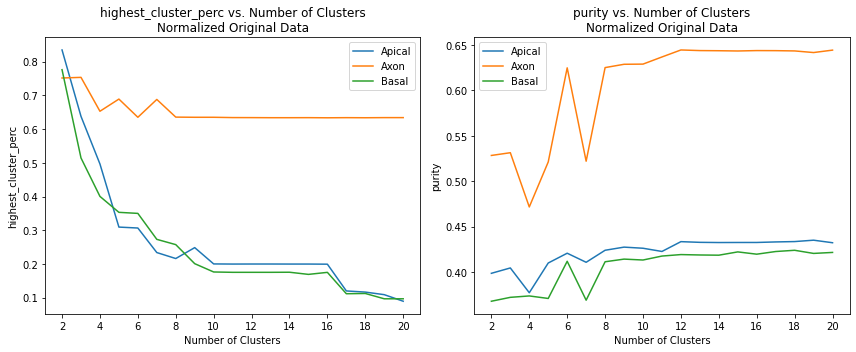

In [34]:
gmm.gmm_pipeline(df_col_filtered,
                 labeled_data_indices = labeled_data_indices,
                 title_suffix = "Normalized Original Data",
                 columns_picked = None,
                 possible_K = possible_K,
                 apply_normalization=True,
                 apply_pca=False,
                 
                )

# Part 4: GMM on PCA Dataset (Full Rank)

# -------- Part 0: Preprocessing (Column restriction, Normalization, PCA) ----------- #
Applying Normalization
Applying pca with 18 components
n_components = 18
whiten = True
---- Using sklearn method ----


<Figure size 432x288 with 0 Axes>

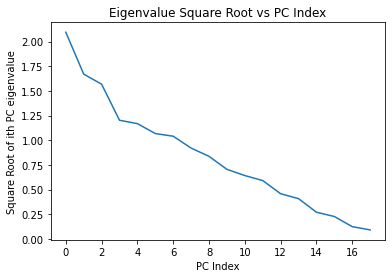

Explained Variance = [0.24358275 0.39851786 0.53504943 0.61538891 0.69121311 0.75457606
 0.81475647 0.86183718 0.90075796 0.92839675 0.95132215 0.97077071
 0.98244248 0.99170941 0.9957869  0.99866557 0.99953143 1.        ]


<Figure size 432x288 with 0 Axes>

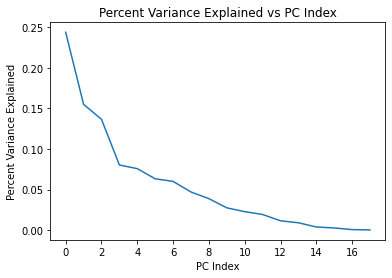

# -------- Part 1: GMM clustering with different Number of Clusters ----------- # 


------Working on clusters K=2-----
Using mixture model
reversing the pca transformation
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 7.422782897949219


------Working on clusters K=3-----
Using mixture model
reversing the pca transformation
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 17.46791958808899


------Working on clusters K=4-----
Using mixture model
reversing the pca transformation
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 12.273403406143188


------Working on clusters K=5-----
Using mixture model
reversing the pca transformation
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 36.09249758720398


------Working on clusters K=6-----
Using mixture model
reversing the pca transformation
reversing the normalizing transformation
C

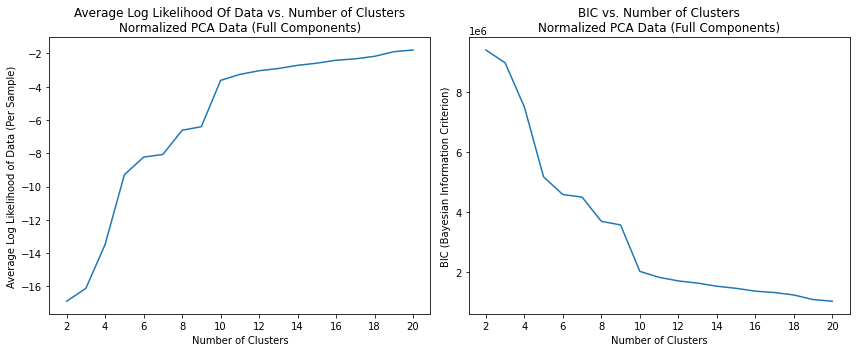

# --------- Part 2: computing the advanced statistics on the clustering ------- # 


----Working on Advanced Statistics for n_clusters = 2----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,454.321584,437.766859,7.694979,5.654787e+08,4.680473e+07,22674.61359,18244.142599,38.563196,80.984923,373.816569,330.137791,26.535408,1.732698e+09,5.042287e+07,38694.400434,46770.900586,35.053028,73.944407
1,328.246282,308.839781,11.983517,8.452114e+08,3.176570e+07,19866.42154,29809.769943,43.851541,86.921599,170.628098,170.627578,0.000596,5.418265e+04,2.013377e+03,2.357440,11453.600588,61.780827,91.296994




Clustering Numbers By Neuroscience Category for K = 2


,classification,category,n_clusters,cl_0,cl_1
2,hard,Apical,2,6681,1319
0,hard,Axon,2,1955,6045
1,hard,Basal,2,6210,1790




Clustering Advanced Statistics By Neuroscience Category for K = 2


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,2,0,0.835125,1,0.399580
0,Axon,hard,2,1,0.755625,2,0.531170
1,Basal,hard,2,0,0.776250,2,0.368454




----Working on Advanced Statistics for n_clusters = 3----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,454.513439,437.915683,7.694183,5.676729e+08,4.691964e+07,2.294376e+04,18235.710980,38.561976,80.987298,373.842442,330.184668,26.523472,1.731924e+09,5.040038e+07,38677.054137,46711.213362,35.062150,73.948674
1,327.631122,308.329609,11.988948,8.353748e+08,3.146597e+07,1.914498e+04,29842.152129,43.860786,86.922898,170.331826,170.331826,0.000012,2.394707e+01,2.394703e+01,0.000172,11560.805743,61.788269,91.305508
2,409.890000,292.370000,66.000000,1.923175e+11,4.892696e+07,2.306614e+06,83376.530000,31.540000,68.060000,349.780000,225.885000,4.500000,3.998375e+08,2.562157e+07,61492.870000,4072.455000,68.220000,111.000000




Clustering Numbers By Neuroscience Category for K = 3


,classification,category,n_clusters,cl_0,cl_1,cl_2
2,hard,Apical,3,6689,1311,0
0,hard,Axon,3,1945,6055,0
1,hard,Basal,3,6213,1787,0




Clustering Advanced Statistics By Neuroscience Category for K = 3


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,3,0,0.836125,1,0.400170
0,Axon,hard,3,1,0.756875,2,0.532547
1,Basal,hard,3,0,0.776625,2,0.368604




----Working on Advanced Statistics for n_clusters = 4----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,327.159941,307.836362,12.012499,8.370832e+08,3.132964e+07,1.916558e+04,29870.033294,43.858057,86.897412,170.142879,170.142879,0.000012,2.399085e+01,2.399076e+01,0.000173,11357.219289,61.816455,91.304223
1,418.962826,395.446428,11.130214,8.088924e+08,4.958048e+07,2.758606e+04,23608.464342,38.733099,79.372282,346.028386,290.958048,38.802566,2.464235e+09,4.078621e+07,39075.969957,66946.269770,35.231827,71.273775
2,509.736400,503.853620,2.365515,1.884081e+08,4.291588e+07,1.526245e+04,9921.219194,38.310158,83.521513,416.666056,390.738150,7.482666,5.960531e+08,6.517269e+07,37986.261297,15559.782135,34.821291,78.119829
3,622.250000,612.520000,5.000000,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,23.500000,2.181976e+09,8.015233e+07,94970.885000,40094.270000,58.480000,103.230000




Clustering Numbers By Neuroscience Category for K = 4


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3
2,hard,Apical,4,1304,3148,3548,0
0,hard,Axon,4,6035,1237,728,0
1,hard,Basal,4,1785,3887,2328,0




Clustering Advanced Statistics By Neuroscience Category for K = 4


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,4,2,0.443500,2,0.411317
0,Axon,hard,4,0,0.754375,2,0.532130
1,Basal,hard,4,1,0.485875,3,0.374545




----Working on Advanced Statistics for n_clusters = 5----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,383.943968,383.943968,3.339551e-13,2.384186e-05,1.639128e-06,7.894414e-10,7602.278546,44.001131,91.424495,295.384289,278.179663,12.803709,8.649456e+08,3.137851e+07,18437.248956,33288.806610,43.929778,83.100011
1,370.893225,340.723530,1.871939e+01,1.320117e+09,4.911696e+07,3.084613e+04,41263.136595,39.989533,78.661837,162.523728,162.522910,0.000918,8.520155e+04,3.129779e+03,3.708412,7859.040613,68.254288,90.794676
2,521.641006,512.039449,3.123101e+00,2.237844e+08,6.258106e+07,2.108281e+04,11338.950711,37.651013,82.966047,425.136416,398.297661,6.564504,5.460312e+08,6.919957e+07,41391.516252,13361.462350,33.357210,78.780360
3,421.060565,406.573239,6.039556e+00,4.429871e+08,5.987254e+07,2.515523e+04,15672.708308,38.625770,79.162521,350.781744,293.363482,42.216788,2.693752e+09,4.116864e+07,40099.659860,69507.382329,36.762906,67.512501
4,414.084586,360.844298,2.818681e+01,2.080950e+09,5.658687e+07,4.928038e+04,49765.507209,38.500398,77.788011,359.758027,305.889877,23.829434,1.477223e+09,4.278903e+07,41529.592339,43338.340150,27.690048,78.547140




Clustering Numbers By Neuroscience Category for K = 5


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4
2,hard,Apical,5,1970,936,2236,2183,675
0,hard,Axon,5,5092,1591,369,566,382
1,hard,Basal,5,1678,1459,1310,2538,1015




Clustering Advanced Statistics By Neuroscience Category for K = 5


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,5,2,0.27950,4,0.382769
0,Axon,hard,5,0,0.63650,2,0.470936
1,Basal,hard,5,3,0.31725,4,0.376263




----Working on Advanced Statistics for n_clusters = 6----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,313.566409,292.967299,1.293876e+01,9.013849e+08,3.361169e+07,2.051911e+04,31651.377178,43.666547,86.262423,152.415123,152.415123,5.471179e-13,3.528595e-05,9.983778e-07,7.566996e-10,9591.714009,63.558360,91.909500
1,454.486117,446.460067,3.398073e+00,2.221698e+08,5.501026e+07,1.722183e+04,12041.188978,38.088943,80.651748,375.361452,330.775501,2.876609e+01,1.891016e+09,4.940197e+07,3.866922e+04,48208.361859,36.533294,71.958135
2,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497089e+04,40094.270000,58.480000,103.230000
3,398.375071,357.139093,2.287131e+01,1.681341e+09,5.637611e+07,4.315769e+04,41928.450377,38.666884,77.107213,332.910180,280.771109,3.128125e+01,1.875228e+09,3.735294e+07,3.653218e+04,55489.613799,28.361516,72.874485
4,572.718322,534.514843,8.229568e+00,7.593738e+08,9.977911e+07,5.540206e+04,16250.549094,38.809463,85.002545,491.998493,441.160323,1.228636e+01,1.092699e+09,8.559336e+07,6.366133e+04,19150.460328,35.156417,80.994287
5,473.915838,473.915838,3.854694e-13,2.801418e-05,1.892447e-06,9.495125e-10,6362.541494,40.245776,85.790314,371.451518,345.811024,1.900856e+01,1.282695e+09,4.652278e+07,2.738264e+04,42949.419586,39.613284,77.716121




Clustering Numbers By Neuroscience Category for K = 6


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5
2,hard,Apical,6,1030,3438,0,931,745,1856
0,hard,Axon,6,5558,720,0,509,109,1104
1,hard,Basal,6,1677,2881,0,1545,435,1462




Clustering Advanced Statistics By Neuroscience Category for K = 6


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,6,1,0.429750,4,0.413439
0,Axon,hard,6,0,0.694750,2,0.522862
1,Basal,hard,6,1,0.360125,4,0.368660




----Working on Advanced Statistics for n_clusters = 7----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,385.847379,385.847379,3.286260e-13,2.419949e-05,1.564622e-06,7.930794e-10,7115.090121,43.943171,91.295112,297.633079,280.022453,13.047800,8.834858e+08,3.208350e+07,18899.732790,32362.490231,43.813429,82.796664
1,418.005304,404.525457,5.404172e+00,3.976102e+08,6.153340e+07,2.495883e+04,14463.177105,38.299097,79.005246,348.650948,287.846060,48.911908,3.087592e+09,4.039759e+07,40425.431354,78245.947530,38.001956,66.148476
2,500.084250,491.811755,3.138352e+00,2.081336e+08,5.652414e+07,1.701091e+04,11563.682535,37.337012,82.006657,415.982845,384.530591,8.398892,6.732524e+08,6.552351e+07,40959.463417,15575.554068,33.365287,77.423858
3,407.229566,354.580305,2.833510e+01,2.142902e+09,6.094930e+07,5.126263e+04,44307.789629,38.447291,76.654679,352.663067,292.113341,26.290885,1.668798e+09,4.421615e+07,45373.537954,38226.785687,25.856263,77.122179
4,623.255469,580.883708,8.028618e+00,7.574347e+08,1.137863e+08,6.627607e+04,15569.950995,41.327110,87.245430,514.533356,463.487209,24.138232,1.893796e+09,7.979827e+07,67510.828505,41096.076958,40.612813,81.104799
5,367.945490,338.096070,1.860886e+01,1.313992e+09,4.860956e+07,3.058069e+04,40565.143285,39.997634,78.811654,161.329272,161.328458,0.000913,8.481217e+04,3.115475e+03,3.691464,7622.025956,68.264233,90.977565
6,391.425749,387.632513,5.164871e+00,1.654288e+08,2.084051e+07,4.652394e+03,39076.278255,40.954542,83.065608,285.042748,281.444700,7.982192,2.630275e+08,2.086344e+07,4737.288370,64044.639556,35.507682,74.994526




Clustering Numbers By Neuroscience Category for K = 7


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6
2,hard,Apical,7,1956,1662,2190,701,404,930,157
0,hard,Axon,7,4851,360,325,194,60,1649,561
1,hard,Basal,7,1663,1874,1421,1119,217,1457,249




Clustering Advanced Statistics By Neuroscience Category for K = 7


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,7,2,0.273750,4,0.387834
0,Axon,hard,7,0,0.606375,2,0.482696
1,Basal,hard,7,1,0.234250,4,0.377739




----Working on Advanced Statistics for n_clusters = 8----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,419.191426,405.861379,5.144711e+00,3.831915e+08,6.709728e+07,2.586553e+04,14258.651936,38.313012,79.107020,346.971392,287.652097,4.819423e+01,3.017511e+09,3.975110e+07,3.906718e+04,79320.743073,38.104553,65.776084
1,384.909798,341.038734,2.790591e+01,1.967669e+09,4.939616e+07,4.056810e+04,49035.369627,39.894074,76.420859,322.383676,275.459946,2.561015e+01,1.481098e+09,3.629892e+07,3.491721e+04,43953.962220,26.048108,75.660110
2,312.954635,292.212661,1.297166e+01,9.041722e+08,3.387378e+07,2.069255e+04,31559.593131,43.629130,86.206457,150.417855,150.417855,8.526513e-13,5.507469e-05,1.586974e-06,1.215085e-09,9540.388297,63.720791,91.950413
3,606.899730,565.384296,1.824536e+01,1.720185e+09,1.037683e+08,8.042202e+04,53405.070345,41.919372,89.058510,498.370458,481.657327,1.100779e+01,6.600223e+08,5.649801e+07,2.685648e+04,54301.086367,46.127923,84.342796
4,473.482886,473.479338,1.399004e+00,3.139750e+07,2.303973e+07,3.506085e+03,9958.031776,39.485316,82.426430,374.507616,340.235655,2.429450e+01,1.570229e+09,4.612101e+07,3.224640e+04,48137.250836,38.763546,74.637087
5,473.616079,473.616079,-4.618528e-14,-2.980232e-06,-2.384186e-07,-1.309672e-10,6332.571611,40.348867,85.885175,372.805658,347.395575,1.883196e+01,1.270950e+09,4.620090e+07,2.716777e+04,42354.803726,39.611722,77.778204
6,501.530670,491.831704,3.387987e+00,2.301700e+08,6.470972e+07,1.922427e+04,11920.076691,37.503301,82.068729,413.059858,384.961336,7.615140e+00,6.026003e+08,6.584954e+07,3.886843e+04,14783.450067,33.040976,77.419674
7,479.536841,434.284317,1.058224e+01,9.981018e+08,8.644348e+07,5.821010e+04,18316.449044,35.139977,80.097580,435.291754,355.929185,2.727340e+01,2.166388e+09,6.800471e+07,7.122700e+04,35030.950322,30.695789,75.348788




Clustering Numbers By Neuroscience Category for K = 8


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7
2,hard,Apical,8,1322,590,1026,172,834,1863,1670,523
0,hard,Axon,8,305,323,5525,119,252,1120,273,83
1,hard,Basal,8,1495,1053,1672,98,648,1468,1035,531




Clustering Advanced Statistics By Neuroscience Category for K = 8


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,8,5,0.232875,5,0.412362
0,Axon,hard,8,2,0.690625,2,0.522628
1,Basal,hard,8,2,0.209000,5,0.372322




----Working on Advanced Statistics for n_clusters = 9----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,312.833917,292.020999,1.304445e+01,9.091555e+08,3.394296e+07,2.073760e+04,31470.033071,43.628108,86.188719,150.204914,150.204914,1.072920e-12,7.057190e-05,2.011657e-06,1.535227e-09,9468.862192,63.779330,91.969837
1,505.007183,491.515150,4.438064e+00,3.376830e+08,6.807702e+07,2.489297e+04,13204.795818,36.987102,82.066841,421.956787,394.109303,5.631764e+00,4.664725e+08,7.040891e+07,4.115485e+04,11193.388370,31.519993,78.129184
2,634.517895,580.986118,8.632894e+00,8.297565e+08,1.215575e+08,7.595133e+04,14833.972838,38.481446,87.180543,536.216488,479.560220,2.250891e+01,1.852317e+09,7.525852e+07,7.182541e+04,33382.374529,41.052153,81.222624
3,478.868414,478.864982,1.360907e+00,2.812612e+07,2.143635e+07,3.192080e+03,9767.237198,39.488818,82.621842,377.619582,344.221810,2.393686e+01,1.549459e+09,4.741386e+07,3.210971e+04,46799.136149,38.818582,74.970479
4,436.008844,428.796192,2.910157e+00,1.851401e+08,6.365781e+07,1.612559e+04,11410.984080,38.644914,80.149521,363.050689,312.979237,2.755410e+01,1.977616e+09,4.947620e+07,4.298227e+04,46441.974616,37.513395,70.860911
5,420.355578,400.140237,7.338852e+00,5.750934e+08,6.882142e+07,3.417190e+04,16722.801470,37.614989,78.504228,349.299851,285.656976,5.432999e+01,3.296453e+09,3.742957e+07,3.871444e+04,87327.664978,36.872480,64.144923
6,400.636026,349.974367,2.838087e+01,2.097646e+09,5.691736e+07,4.724616e+04,44861.415108,39.161736,76.470795,349.390422,289.823222,2.547634e+01,1.614539e+09,4.324158e+07,4.471404e+04,37409.744424,25.423225,77.528152
7,352.266256,344.258353,1.473979e+01,1.022455e+09,2.309766e+07,2.297774e+04,75987.824090,40.502486,82.005060,261.461195,257.991925,8.311554e+00,2.807479e+08,2.183077e+07,4.833020e+03,74146.371451,33.861275,76.969738
8,473.738145,473.738145,7.105427e-15,1.192093e-06,3.725290e-08,1.455192e-11,6274.448297,40.347206,85.870060,372.823908,347.397598,1.881908e+01,1.270737e+09,4.617870e+07,2.718297e+04,42033.762892,39.610811,77.744563




Clustering Numbers By Neuroscience Category for K = 9


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8
2,hard,Apical,9,1023,1445,309,813,880,963,634,70,1863
0,hard,Axon,9,5502,226,49,229,179,212,206,294,1103
1,hard,Basal,9,1669,891,156,604,871,1164,1068,109,1468




Clustering Advanced Statistics By Neuroscience Category for K = 9


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,9,8,0.232875,6,0.416444
0,Axon,hard,9,0,0.687750,2,0.533257
1,Basal,hard,9,0,0.208625,6,0.375012




----Working on Advanced Statistics for n_clusters = 10----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,672.339679,630.995068,4.894968e+00,4.996760e+08,1.320109e+08,6.963024e+04,10916.129658,43.468988,89.357143,503.203262,462.162595,3.271921e+01,2.451655e+09,5.392768e+07,4.280054e+04,59112.150849,43.412970,79.468613
1,510.256738,505.723306,2.120408e+00,1.062628e+08,4.760926e+07,1.051157e+04,10110.669609,37.751147,82.724480,411.009489,385.590812,8.447999e+00,6.437960e+08,6.005810e+07,3.482880e+04,16874.626636,34.914673,77.426828
2,398.943581,342.822693,3.267498e+01,2.419856e+09,5.718852e+07,5.165712e+04,49919.816626,38.994027,76.115057,334.451565,274.232722,3.433556e+01,2.076630e+09,3.796891e+07,4.147840e+04,50303.413699,25.846731,76.247231
3,474.519454,474.519454,-1.225686e-13,-8.583069e-06,-5.736947e-07,-2.983143e-10,6042.260781,39.422019,84.531480,377.439755,347.983758,2.175201e+01,1.471128e+09,5.340548e+07,3.148990e+04,42938.426924,39.571479,76.730986
4,417.039962,403.905767,5.247232e+00,3.878312e+08,6.232153e+07,2.497799e+04,14269.207931,38.242599,78.938460,349.897759,288.666871,4.847384e+01,3.076200e+09,4.093196e+07,4.092732e+04,77152.087887,37.882324,66.121961
5,387.236632,354.252650,2.055856e+01,1.435247e+09,5.361742e+07,3.280950e+04,39608.920146,39.371326,77.750812,166.491843,166.491843,-1.513456e-12,-9.942055e-05,-2.853572e-06,-2.211891e-09,7101.838851,68.883078,89.658295
6,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497089e+04,40094.270000,58.480000,103.230000
7,239.718159,239.718159,6.235013e-13,4.482269e-05,3.002584e-06,1.506123e-09,15190.622838,50.153650,99.730785,166.878553,166.878553,1.364242e-12,8.893013e-05,2.495944e-06,1.931767e-09,17063.422453,52.047482,93.768384
8,453.102799,422.224932,1.153530e+01,9.556997e+08,7.186981e+07,4.210982e+04,22473.249693,36.844728,79.368490,417.927763,362.735136,9.306251e+00,7.856018e+08,7.360332e+07,6.072588e+04,13446.205178,28.655856,78.249089
9,382.374118,377.931926,5.983350e+00,2.007064e+08,2.222222e+07,5.228053e+03,42494.115029,40.106013,82.099258,278.274217,274.445528,9.076523e+00,3.049511e+08,2.225917e+07,4.885937e+03,68102.703593,35.020704,73.754334




Clustering Numbers By Neuroscience Category for K = 10


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9
2,hard,Apical,10,350,1828,484,1599,1616,914,0,379,705,125
0,hard,Axon,10,53,287,140,576,340,923,0,5079,137,465
1,hard,Basal,10,151,1064,800,1360,1806,1411,0,362,812,234




Clustering Advanced Statistics By Neuroscience Category for K = 10


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,10,1,0.228500,5,0.431945
0,Axon,hard,10,7,0.634875,3,0.642215
1,Basal,hard,10,4,0.225750,5,0.417188




----Working on Advanced Statistics for n_clusters = 11----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,617.666157,562.308765,2.530178e+01,2.315437e+09,9.599116e+07,9.660400e+04,47102.973284,41.030728,87.093631,582.314440,541.172768,1.389506e+01,1.025654e+09,8.059650e+07,7.309153e+04,31066.174963,42.726035,85.716574
1,381.973916,377.836754,5.695380e+00,1.801633e+08,2.129969e+07,4.695765e+03,41777.601625,39.736943,82.290487,278.521713,275.035140,8.691766e+00,2.776816e+08,2.113985e+07,4.288005e+03,69881.073822,34.899013,73.877654
2,474.980043,474.980043,-1.083578e-13,-8.225441e-06,-4.470348e-07,-2.983143e-10,6035.046078,39.437644,84.542675,377.770536,348.283848,2.176204e+01,1.471781e+09,5.340529e+07,3.154728e+04,42907.779524,39.577336,76.739753
3,240.093732,240.093732,6.252776e-13,4.494190e-05,3.024936e-06,1.517037e-09,15211.551729,50.159056,99.730893,166.980939,166.980939,1.367795e-12,8.916855e-05,2.525747e-06,1.942681e-09,17039.031034,52.054208,93.773977
4,521.864529,518.335594,1.827369e+00,7.033259e+07,3.856177e+07,7.479697e+03,9656.722601,38.456301,83.221458,415.230013,393.383709,7.458796e+00,5.539511e+08,6.022606e+07,3.196918e+04,15873.599130,35.324241,78.043168
5,395.579952,346.097028,2.877207e+01,2.116980e+09,5.661035e+07,4.739727e+04,45347.668296,39.483107,76.292326,337.219331,276.802320,3.448681e+01,2.086531e+09,3.837443e+07,4.123609e+04,51301.568390,26.563895,73.996983
6,530.193344,497.283360,3.981274e+00,4.453095e+08,1.206117e+08,5.381639e+04,8701.359065,34.260785,82.212580,392.029407,336.580957,3.870805e+01,2.908078e+09,5.525138e+07,4.789744e+04,60189.043172,38.458651,72.717487
7,451.475756,428.929388,8.406010e+00,6.906693e+08,7.169551e+07,3.568934e+04,18933.650821,37.305697,79.667110,414.140083,362.303762,1.002452e+01,8.308558e+08,6.864294e+07,5.515838e+04,14907.035821,29.199287,76.683510
8,409.890000,292.370000,6.600000e+01,1.923175e+11,4.892696e+07,2.306614e+06,83376.530000,31.540000,68.060000,349.780000,225.885000,4.500000e+00,3.998375e+08,2.562157e+07,6.149287e+04,4072.455000,68.220000,111.000000
9,413.379780,404.223245,4.114409e+00,2.725209e+08,5.481144e+07,1.903391e+04,13103.103528,38.947608,79.200882,345.064158,285.726591,4.947482e+01,3.071164e+09,3.929324e+07,3.905427e+04,80534.914348,39.030669,66.346486




Clustering Numbers By Neuroscience Category for K = 11


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10
2,hard,Apical,11,145,105,1601,379,1475,623,530,906,0,1319,917
0,hard,Axon,11,41,453,575,5078,233,177,96,170,0,260,917
1,hard,Basal,11,85,207,1360,362,827,1009,379,932,0,1427,1412




Clustering Advanced Statistics By Neuroscience Category for K = 11


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,11,2,0.200125,6,0.430057
0,Axon,hard,11,3,0.634750,3,0.642894
1,Basal,hard,11,9,0.178375,6,0.415999




----Working on Advanced Statistics for n_clusters = 12----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,420.278159,405.580666,5.381403e+00,4.099473e+08,6.859622e+07,2.799701e+04,14259.749980,38.030665,78.970221,347.585924,286.361196,5.132200e+01,3.215319e+09,3.966921e+07,3.956618e+04,82258.160503,38.215741,65.332984
1,626.374910,572.126487,1.571028e+01,1.408953e+09,1.180828e+08,8.313914e+04,25902.980476,38.337542,86.688728,524.030687,475.613972,2.433534e+01,1.880692e+09,7.478449e+07,6.749914e+04,41930.304788,41.941559,82.011609
2,531.337817,524.019988,2.597108e+00,1.550969e+08,5.987926e+07,1.513811e+04,10531.188998,37.370686,83.296281,423.765515,405.242285,5.374737e+00,3.990574e+08,6.570946e+07,3.143292e+04,12373.997542,33.882246,78.427913
3,464.981258,464.977987,1.350451e+00,3.696327e+07,2.893526e+07,4.294574e+03,9407.742404,39.467976,81.892571,370.063598,332.290734,2.656386e+01,1.741162e+09,4.655849e+07,3.478957e+04,48335.340487,38.981165,73.813732
4,452.094613,427.331080,8.097151e+00,6.871547e+08,7.435207e+07,3.858458e+04,17872.460629,37.241810,79.623288,411.998644,351.913817,1.514716e+01,1.264714e+09,6.632644e+07,5.874828e+04,21666.784542,30.259563,75.422396
5,474.682334,474.682334,-2.895462e-13,-2.074242e-05,-1.348555e-06,-7.166818e-10,6051.085597,39.432098,84.542486,377.536861,348.090522,2.175306e+01,1.470637e+09,5.334914e+07,3.149469e+04,43041.021925,39.572566,76.742716
6,409.890000,292.370000,6.600000e+01,1.923175e+11,4.892696e+07,2.306614e+06,83376.530000,31.540000,68.060000,349.780000,225.885000,4.500000e+00,3.998375e+08,2.562157e+07,6.149287e+04,4072.455000,68.220000,111.000000
7,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497089e+04,40094.270000,58.480000,103.230000
8,240.078556,240.078556,6.199485e-13,4.434586e-05,3.017485e-06,1.509761e-09,15180.720162,50.158661,99.731239,166.989856,166.989856,1.353584e-12,8.845329e-05,2.525747e-06,1.942681e-09,17053.175383,52.051888,93.771507
9,395.961636,341.001955,3.153667e+01,2.295376e+09,5.464857e+07,4.842939e+04,48643.704522,39.515440,76.043321,334.956374,275.862763,3.197232e+01,1.913154e+09,3.811380e+07,4.115638e+04,46875.913264,25.455869,76.220010




Clustering Numbers By Neuroscience Category for K = 12


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11
2,hard,Apical,12,1246,250,1332,782,868,1601,0,0,379,515,917,110
0,hard,Axon,12,253,58,185,206,154,579,0,0,5077,145,912,431
1,hard,Basal,12,1394,140,655,659,930,1361,0,0,362,878,1413,208




Clustering Advanced Statistics By Neuroscience Category for K = 12


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,12,5,0.200125,6,0.430852
0,Axon,hard,12,8,0.634625,3,0.640824
1,Basal,hard,12,10,0.176625,6,0.417526




----Working on Advanced Statistics for n_clusters = 13----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,415.151069,401.360232,6.690287e+00,4.873213e+08,6.221083e+07,2.621135e+04,18263.857044,39.466099,79.120207,368.959973,318.336401,1.990903e+01,1.451607e+09,5.101851e+07,4.508391e+04,31956.816642,31.754354,71.444778
1,474.803117,474.803117,-1.829648e-13,-1.287460e-05,-8.493662e-07,-4.547474e-10,6036.606224,39.433384,84.536838,377.674541,348.202650,2.176030e+01,1.471701e+09,5.336940e+07,3.151336e+04,42921.235742,39.579424,76.732589
2,445.292083,409.148741,1.434765e+01,1.173097e+09,6.584483e+07,4.330383e+04,26217.352817,37.460184,79.093030,421.960998,362.706116,7.697496e+00,6.494945e+08,7.442517e+07,6.238321e+04,10524.345308,27.541064,79.764564
3,375.988653,371.773479,6.000615e+00,1.899146e+08,2.059800e+07,4.501084e+03,46276.221388,39.697451,82.441565,275.930485,272.871210,8.096677e+00,2.465735e+08,2.023984e+07,3.766770e+03,70109.689305,34.690032,74.274738
4,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497089e+04,40094.270000,58.480000,103.230000
5,657.530887,601.280230,1.504925e+01,1.345121e+09,1.087768e+08,8.943133e+04,26689.886803,39.872235,88.140393,567.032409,520.051851,3.012323e+01,2.277266e+09,6.980312e+07,6.864256e+04,54983.772867,44.209275,82.215378
6,435.217817,432.227588,1.856403e+00,8.014506e+07,4.342972e+07,8.495182e+03,9491.267933,39.202050,80.548174,348.812245,291.952060,4.848257e+01,3.064556e+09,4.058954e+07,3.940340e+04,80254.538599,41.863424,69.466942
7,240.075250,240.075250,6.235013e-13,4.458427e-05,3.002584e-06,1.506123e-09,15175.963977,50.158152,99.730218,166.991261,166.991261,1.353584e-12,8.773804e-05,2.510846e-06,1.928129e-09,17030.502747,52.053607,93.771362
8,414.874023,388.839985,9.839473e+00,7.923737e+08,7.032011e+07,3.974257e+04,19902.544933,37.784414,77.994462,351.897676,284.533710,5.451276e+01,3.347204e+09,3.779541e+07,4.039671e+04,84716.611796,35.028299,63.325899
9,388.232319,328.713279,4.042821e+01,2.899034e+09,5.104806e+07,4.843737e+04,61309.616254,40.243187,75.596879,320.749058,266.899350,2.832262e+01,1.667670e+09,3.733631e+07,3.979868e+04,41738.484313,23.368806,81.055248




Clustering Numbers By Neuroscience Category for K = 13


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12
2,hard,Apical,13,697,1600,439,96,0,168,805,379,763,316,601,1221,915
0,hard,Axon,13,152,574,81,446,0,37,167,5075,150,105,107,188,918
1,hard,Basal,13,689,1360,530,184,0,93,817,362,980,516,419,638,1412




Clustering Advanced Statistics By Neuroscience Category for K = 13


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,13,1,0.200000,7,0.429882
0,Axon,hard,13,7,0.634375,3,0.643482
1,Basal,hard,13,12,0.176500,7,0.416423




----Working on Advanced Statistics for n_clusters = 14----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,550.587669,547.732978,1.766499e+00,4.468041e+07,2.553938e+07,4.953398e+03,9581.286214,38.694866,84.422668,426.679958,415.315706,4.168997e+00,2.733180e+08,5.642787e+07,2.247308e+04,11820.975096,34.820949,79.507167
1,384.580871,324.251046,4.696838e+01,3.299676e+09,4.759585e+07,4.725059e+04,70676.476088,40.429301,75.137293,309.612556,261.148169,2.603989e+01,1.461985e+09,3.541666e+07,3.650813e+04,40031.703023,22.931722,83.279483
2,369.301324,364.491963,6.549181e+00,2.184854e+08,2.266144e+07,5.353582e+03,48257.478969,39.611274,82.197340,272.884126,269.742729,8.188232e+00,2.532811e+08,2.026043e+07,3.936596e+03,70532.213805,34.278810,74.245705
3,386.938046,353.924214,2.055214e+01,1.435389e+09,5.368206e+07,3.283301e+04,39556.278136,39.374803,77.741830,166.062577,166.062577,-1.620037e-12,-1.063347e-04,-3.062189e-06,-2.368324e-09,7076.723402,68.913341,89.670277
4,599.850842,546.357307,6.330207e+00,7.106188e+08,1.364564e+08,8.665921e+04,11115.695730,37.936841,85.485830,402.924632,351.459720,4.024604e+01,2.844384e+09,4.894725e+07,4.206104e+04,70130.974246,39.318131,74.256457
5,402.563354,371.875681,1.248455e+01,9.979765e+08,6.852795e+07,4.329962e+04,23796.215776,38.236116,77.398818,344.122715,280.294338,4.771592e+01,2.951255e+09,3.868412e+07,4.057675e+04,73024.359424,32.672500,64.118933
6,484.774908,473.342903,3.499681e+00,2.840400e+08,8.273023e+07,2.515597e+04,11789.174109,36.674010,81.133029,412.528191,377.056908,9.106763e+00,7.853734e+08,7.206860e+07,4.783814e+04,16029.712090,32.497670,76.486462
7,474.606999,474.606999,-3.286260e-13,-2.384186e-05,-1.519918e-06,-8.185452e-10,6046.774926,39.418486,84.519720,377.333203,347.853036,2.176564e+01,1.471592e+09,5.328343e+07,3.149824e+04,43012.734274,39.567578,76.721892
8,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497089e+04,40094.270000,58.480000,103.230000
9,590.886769,559.657969,1.835844e+01,1.414177e+09,5.602466e+07,3.597279e+04,36042.643289,42.362947,86.245330,652.611092,608.054064,4.883253e+00,6.992891e+08,1.143194e+08,9.970109e+04,8268.336253,45.067690,88.828081




Clustering Numbers By Neuroscience Category for K = 14


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13
2,hard,Apical,14,912,236,99,911,275,599,1062,1600,0,117,462,379,551,797
0,hard,Axon,14,157,82,426,916,40,153,173,576,0,27,90,5075,122,163
1,hard,Basal,14,398,359,186,1410,154,857,768,1362,0,63,664,361,507,911




Clustering Advanced Statistics By Neuroscience Category for K = 14


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,14,7,0.200000,7,0.431682
0,Axon,hard,14,11,0.634375,3,0.641753
1,Basal,hard,14,3,0.176250,7,0.419073




----Working on Advanced Statistics for n_clusters = 15----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,474.952307,474.952307,-1.474376e-13,-1.025200e-05,-6.780028e-07,-3.601599e-10,6023.280339,39.434507,84.529986,377.847411,348.326623,2.177728e+01,1.473090e+09,5.340136e+07,3.157039e+04,42865.106395,39.580423,76.720050
1,608.270430,558.325562,3.605901e+00,4.334911e+08,1.456684e+08,8.222749e+04,6102.396660,34.196842,84.962141,399.238650,352.189468,3.341027e+01,2.404279e+09,4.923510e+07,3.961479e+04,56455.544272,40.078002,74.222697
2,413.464417,396.385975,8.243874e+00,5.051615e+08,4.825417e+07,2.236787e+04,22059.552451,40.730606,79.339766,297.431101,273.488991,3.296171e+01,1.720575e+09,3.241557e+07,2.023255e+04,83844.664774,36.230006,65.869578
3,422.130474,418.197815,2.187811e+00,1.211336e+08,5.284151e+07,1.197598e+04,9951.863909,38.510156,79.924417,347.606298,285.675523,5.564945e+01,3.514021e+09,3.986952e+07,4.043424e+04,87222.707600,41.649961,67.773978
4,369.636257,366.653980,5.326372e+00,1.512650e+08,1.876641e+07,3.304433e+03,48291.419446,39.265844,83.016908,271.564663,269.302416,6.691415e+00,1.850404e+08,1.890075e+07,2.898565e+03,70320.839200,34.965012,75.077332
5,387.110532,354.085019,2.055725e+01,1.435751e+09,5.363736e+07,3.283661e+04,39522.455768,39.382601,77.748747,166.391648,166.391648,-1.548983e-12,-1.013279e-04,-2.920628e-06,-2.262823e-09,6961.190083,68.957713,89.668909
6,592.027888,555.963703,2.401562e+01,1.993557e+09,5.912713e+07,4.906478e+04,45389.499645,41.111850,86.579849,640.084543,590.564900,2.553881e+01,2.114248e+09,8.788616e+07,9.130591e+04,43633.086426,45.243731,86.547038
7,381.075902,322.534417,4.647272e+01,3.234740e+09,4.700573e+07,4.604017e+04,71090.456051,40.686407,74.974907,305.734186,259.375231,2.462839e+01,1.378197e+09,3.576125e+07,3.567665e+04,38512.326774,22.877044,83.194342
8,240.114375,240.114375,6.199485e-13,4.458427e-05,3.039837e-06,1.495209e-09,15164.235011,50.159963,99.729597,167.001542,167.001542,1.367795e-12,8.940697e-05,2.518296e-06,1.946319e-09,16953.957046,52.060177,93.772552
9,445.200831,434.608914,3.955153e+00,3.018340e+08,7.254497e+07,2.312145e+04,12842.150319,38.113227,79.996441,396.099921,338.230254,2.105740e+01,1.678400e+09,6.008317e+07,5.296580e+04,31561.768902,33.900473,72.914014




Clustering Numbers By Neuroscience Category for K = 15


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14
2,hard,Apical,15,1600,289,339,725,71,913,108,224,379,682,529,0,858,879,404
0,hard,Axon,15,567,54,101,140,424,904,28,76,5071,113,145,0,161,132,84
1,hard,Basal,15,1359,173,429,782,150,1406,60,352,362,622,778,0,439,520,568




Clustering Advanced Statistics By Neuroscience Category for K = 15


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,15,0,0.200000,8,0.431503
0,Axon,hard,15,8,0.633875,3,0.643677
1,Basal,hard,15,5,0.175750,8,0.418533




----Working on Advanced Statistics for n_clusters = 16----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,240.138053,240.138053,6.270540e-13,4.470348e-05,2.995133e-06,1.491571e-09,15163.288966,50.159751,99.729639,167.004773,167.004773,1.339373e-12,8.678436e-05,2.488494e-06,1.909939e-09,16949.850812,52.060513,93.772762
1,416.934478,410.978347,2.596364e+00,1.611177e+08,6.170774e+07,1.546847e+04,10380.029882,38.346910,79.506436,351.640998,285.994215,5.776152e+01,3.613702e+09,3.947442e+07,4.120544e+04,87758.450242,40.751445,66.851967
2,450.168908,440.317587,3.992792e+00,2.933245e+08,6.744341e+07,2.129981e+04,13222.457048,38.330242,80.322696,396.503970,343.371980,1.836395e+01,1.454886e+09,6.063878e+07,5.176238e+04,28219.217314,33.684696,73.572651
3,365.466462,362.134685,5.679323e+00,1.619115e+08,1.834425e+07,3.279643e+03,51139.465356,39.416812,82.979533,270.732181,268.497628,6.572518e+00,1.799739e+08,1.878950e+07,2.851874e+03,70538.195027,34.584593,75.420085
4,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497089e+04,40094.270000,58.480000,103.230000
5,409.890000,292.370000,6.600000e+01,1.923175e+11,4.892696e+07,2.306614e+06,83376.530000,31.540000,68.060000,349.780000,225.885000,4.500000e+00,3.998375e+08,2.562157e+07,6.149287e+04,4072.455000,68.220000,111.000000
6,541.149342,500.007563,3.920002e+00,4.369953e+08,1.237516e+08,6.330056e+04,7055.393834,32.638270,82.010062,383.902773,331.236663,3.626624e+01,2.624664e+09,5.101392e+07,4.379315e+04,58911.347138,38.198581,72.010897
7,480.391154,480.388391,1.300691e+00,2.558659e+07,2.027252e+07,2.980945e+03,9382.290890,39.529448,82.454248,378.781053,345.343656,2.175724e+01,1.469202e+09,4.917679e+07,3.403028e+04,41228.806707,38.921939,75.250904
8,651.768748,598.075198,2.150852e+01,1.874752e+09,1.049753e+08,8.917303e+04,38883.228662,41.683637,88.764041,615.952190,573.024711,2.280930e+01,1.882162e+09,7.720173e+07,7.671080e+04,40108.781556,44.691052,85.446925
9,387.622918,354.566252,2.054696e+01,1.434959e+09,5.367930e+07,3.286591e+04,39499.712459,39.381267,77.769171,166.660977,166.660977,-1.612932e-12,-1.058578e-04,-3.084540e-06,-2.382876e-09,6969.249424,68.938110,89.668983




Clustering Numbers By Neuroscience Category for K = 16


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15
2,hard,Apical,16,379,580,747,71,0,0,321,672,137,913,328,1021,299,447,485,1600
0,hard,Axon,16,5071,116,124,402,0,0,61,159,32,909,105,151,97,74,130,569
1,hard,Basal,16,362,666,635,137,0,0,263,506,70,1410,526,466,381,515,704,1359




Clustering Advanced Statistics By Neuroscience Category for K = 16


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,16,15,0.200000,8,0.430616
0,Axon,hard,16,0,0.633875,3,0.642687
1,Basal,hard,16,9,0.176250,9,0.418031




----Working on Advanced Statistics for n_clusters = 17----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,642.349554,613.694589,1.531413e+01,1.167933e+09,5.405267e+07,3.296598e+04,28353.952221,43.849073,88.233725,709.615994,666.038284,5.011926e+00,7.569887e+08,1.145909e+08,1.061392e+05,8133.560554,48.791712,89.396423
1,379.733833,320.298407,5.086694e+01,3.514589e+09,4.559184e+07,4.577794e+04,78614.705174,40.748439,74.956689,300.747287,256.954893,2.149888e+01,1.189874e+09,3.601608e+07,3.458847e+04,34518.713595,22.985497,84.788089
2,396.900401,385.056371,8.612634e+00,3.997216e+08,3.385656e+07,1.351282e+04,30705.628420,40.041214,78.958227,285.610265,274.835128,1.956182e+01,8.170205e+08,2.562892e+07,1.078940e+04,77326.031176,33.784969,68.293332
3,475.194766,475.194766,-2.842171e-13,-2.026558e-05,-1.281500e-06,-6.948540e-10,6006.677727,39.418892,84.491420,377.698007,348.157251,2.180137e+01,1.474395e+09,5.335536e+07,3.157050e+04,42944.496691,39.581357,76.665861
4,514.076281,505.478124,3.094738e+00,1.889999e+08,5.836554e+07,1.621842e+04,11534.313360,36.946883,82.551154,422.540779,402.820816,4.347444e+00,3.341306e+08,6.787340e+07,3.460382e+04,9846.736545,32.314369,78.304281
5,402.964625,364.548690,1.582411e+01,1.273789e+09,6.683513e+07,4.756128e+04,27329.709737,38.234146,77.026071,350.386051,280.727692,4.903573e+01,3.045638e+09,3.870264e+07,4.349084e+04,70705.752160,30.738621,65.470210
6,239.813211,239.813211,6.323830e-13,4.518032e-05,3.039837e-06,1.506123e-09,15147.077647,50.159807,99.732106,166.788715,166.788715,1.367795e-12,8.845329e-05,2.518296e-06,1.939043e-09,16915.023318,52.054193,93.764056
7,516.997332,516.994548,1.339608e+00,3.272610e+07,2.645473e+07,3.832068e+03,9473.089475,39.319606,83.482963,413.190540,391.818221,7.299230e+00,5.416200e+08,5.909309e+07,3.082956e+04,16238.636025,35.788862,78.309672
8,430.932749,388.218221,1.767521e+01,1.448508e+09,6.641659e+07,4.816095e+04,30062.830090,37.544481,78.111686,408.767139,342.920854,1.048675e+01,8.249129e+08,6.222741e+07,5.935679e+04,13819.916508,25.525325,79.026972
9,587.902224,523.483814,1.180447e+01,1.223249e+09,1.282896e+08,1.011370e+05,18090.995374,41.469313,85.817055,403.380137,339.384413,5.321151e+01,3.655427e+09,4.353742e+07,4.517888e+04,87296.746417,39.128475,74.736186




Clustering Numbers By Neuroscience Category for K = 17


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16
2,hard,Apical,17,113,178,150,1600,987,473,378,574,341,162,349,487,0,906,39,611,652
0,hard,Axon,17,24,72,142,563,144,110,5071,110,73,27,67,106,0,887,362,107,135
1,hard,Basal,17,58,276,227,1356,514,740,361,375,515,93,269,442,0,1408,96,545,725




Clustering Advanced Statistics By Neuroscience Category for K = 17


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,17,3,0.200000,9,0.431874
0,Axon,hard,17,6,0.633875,3,0.644652
1,Basal,hard,17,13,0.176000,9,0.418106




----Working on Advanced Statistics for n_clusters = 18----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,460.423873,456.948578,1.512071e+00,2.581824e+07,1.736562e+07,3.148174e+03,8790.784021,39.045312,81.282753,351.400094,299.202877,4.495945e+01,2.806595e+09,3.952751e+07,3.704553e+04,77247.310332,43.340239,71.687080
1,387.479001,337.341491,2.739672e+01,2.042076e+09,5.587291e+07,4.744717e+04,43122.238498,39.803622,76.145144,338.764956,276.325740,3.546699e+01,2.161199e+09,3.827057e+07,4.383142e+04,50408.646467,24.503005,75.388013
2,532.210588,523.015111,2.779601e+00,1.749427e+08,6.493554e+07,1.779137e+04,10394.592259,36.723638,83.131772,419.507021,405.567231,3.801318e+00,2.670447e+08,6.377141e+07,2.725106e+04,9874.332954,33.339097,78.487647
3,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497089e+04,40094.270000,58.480000,103.230000
4,383.036401,349.460371,2.086278e+01,1.458851e+09,5.435216e+07,3.337241e+04,39989.240667,39.199769,77.419909,161.725956,161.725956,-1.367795e-12,-9.012222e-05,-2.644956e-06,-2.033630e-09,6674.940713,69.426934,89.691952
5,408.053084,402.058133,3.001495e+00,2.045901e+08,7.186898e+07,1.868604e+04,11221.656066,38.718835,79.239482,340.341024,281.721620,5.450794e+01,3.400298e+09,3.919753e+07,3.861650e+04,89040.490529,39.328000,66.394036
6,385.510642,322.388130,5.572953e+01,3.931145e+09,4.699943e+07,4.787446e+04,84564.391217,40.526054,74.916305,305.617750,264.596402,1.129868e+01,6.744054e+08,4.553281e+07,3.729704e+04,19321.043202,24.685459,87.321550
7,443.555927,412.063571,1.172604e+01,9.753182e+08,6.919929e+07,4.231910e+04,23027.805290,37.172710,78.814961,420.045021,360.480788,8.735869e+00,7.301043e+08,6.974672e+07,6.103482e+04,12072.547729,26.832997,77.894181
8,605.153575,542.511141,1.695023e+01,1.641448e+09,1.401855e+08,1.038646e+05,27351.715971,44.622526,87.502986,402.119924,354.738846,4.442277e+01,2.901345e+09,3.878168e+07,3.539461e+04,85728.500856,39.789627,78.535102
9,515.231775,514.140218,1.421083e+00,2.511283e+07,1.439177e+07,2.202665e+03,19104.261022,43.335351,91.907993,382.566599,382.560124,1.225734e+00,2.137711e+07,1.351330e+07,1.451849e+03,35151.482755,37.632200,86.409759




Clustering Numbers By Neuroscience Category for K = 18


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17
2,hard,Apical,18,445,331,904,0,868,493,106,...,137,189,239,124,655,541,376,85,531,1583
0,hard,Axon,18,82,94,129,0,866,118,44,...,24,304,64,20,109,111,5066,246,100,544
1,hard,Basal,18,411,565,438,0,1402,601,177,...,63,67,295,59,525,377,360,183,633,1360




Clustering Advanced Statistics By Neuroscience Category for K = 18


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,18,17,0.197875,9,0.428785
0,Axon,hard,18,14,0.633250,3,0.640247
1,Basal,hard,18,4,0.175250,9,0.421736




----Working on Advanced Statistics for n_clusters = 19----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,570.010890,558.650651,2.771621e+00,1.795467e+08,7.295420e+07,2.112850e+04,9680.676800,37.108550,84.717361,427.837933,419.506954,2.995538e+00,1.482667e+08,4.330024e+07,1.489897e+04,9664.559640,35.198295,79.474476
1,325.645249,323.461276,5.461122e+00,1.891597e+08,2.227189e+07,4.154211e+03,58143.644378,40.263596,85.312406,232.489883,232.481149,1.301345e+00,2.181444e+07,1.174195e+07,8.062248e+02,48319.264814,38.970290,81.357867
2,510.940497,510.940497,-4.991563e-13,-3.516674e-05,-2.354383e-06,-1.196895e-09,5936.201279,39.297217,85.821601,406.722996,394.856268,4.698605e+00,3.569762e+08,6.189146e+07,2.474140e+04,13760.793272,36.148294,79.198466
3,442.159773,439.679892,1.607046e+00,3.997568e+07,2.451217e+07,4.756481e+03,8951.657302,38.963491,80.784270,345.871500,289.923988,4.949216e+01,3.089396e+09,3.944394e+07,3.830647e+04,82377.837153,43.410729,70.331424
4,472.271999,438.922088,3.803709e+00,4.025650e+08,1.119716e+08,5.370086e+04,7542.524619,32.442391,79.252166,370.039361,307.752933,4.370273e+01,3.133741e+09,4.982681e+07,4.736542e+04,67123.980141,36.971124,69.013439
5,239.843833,239.843833,7.531753e-13,5.435944e-05,3.650784e-06,1.840817e-09,15119.450267,50.163623,99.734001,166.786953,166.786953,1.659117e-12,1.075268e-04,3.084540e-06,2.368324e-09,16870.757240,52.054335,93.763530
6,384.526145,324.968714,5.135892e+01,3.650060e+09,4.738985e+07,4.646725e+04,80655.470933,40.493891,75.421338,307.367285,270.255034,9.281171e+00,5.685773e+08,4.771139e+07,3.610353e+04,16780.964533,25.481972,87.194835
7,421.176190,383.778743,1.493266e+01,1.248695e+09,6.924153e+07,4.689590e+04,26804.094593,37.945903,78.058449,390.575021,320.681252,2.173922e+01,1.650048e+09,5.267745e+07,5.460248e+04,29824.325541,28.167628,73.045564
8,388.187001,354.760696,2.070471e+01,1.449763e+09,5.386298e+07,3.320355e+04,39062.242758,39.347127,77.654650,166.006132,166.006132,-1.456613e-12,-9.512901e-05,-2.764165e-06,-2.113666e-09,6585.221574,69.252971,89.769917
9,440.153493,440.153493,-2.842171e-14,-1.430511e-06,-1.341105e-07,-7.275958e-11,6113.422002,39.568566,83.213388,348.658997,301.755463,3.890558e+01,2.587757e+09,4.461433e+07,3.794816e+04,73233.816168,43.055804,74.156837




Clustering Numbers By Neuroscience Category for K = 19


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17,cl_18
2,hard,Apical,19,579,27,934,495,277,379,126,...,668,745,303,104,0,674,692,492,92,150
0,hard,Axon,19,83,325,289,110,74,5066,55,...,283,152,79,11,0,112,116,81,189,30
1,hard,Basal,19,238,68,645,493,347,361,198,...,714,801,518,64,0,584,375,414,173,69




Clustering Advanced Statistics By Neuroscience Category for K = 19


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,19,2,0.11675,10,0.434841
0,Axon,hard,19,5,0.63325,4,0.646502
1,Basal,hard,19,8,0.17525,10,0.420301




----Working on Advanced Statistics for n_clusters = 20----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,513.796969,513.796969,-5.293543e-13,-3.755093e-05,-2.488494e-06,-1.284207e-09,5898.407642,39.404417,86.094846,406.980667,396.971826,4.113851e+00,2.945071e+08,6.027141e+07,2.167782e+04,13067.419902,36.112863,79.262304
1,374.890118,337.544534,2.250015e+01,1.600126e+09,5.222008e+07,4.006495e+04,38863.872320,40.971503,76.135308,311.556219,264.239140,3.890146e+01,2.170641e+09,3.375425e+07,3.472752e+04,62289.424877,26.705051,70.026905
2,558.255408,492.092941,2.638974e+01,2.260454e+09,1.161809e+08,1.103527e+05,49712.847612,36.874894,85.111397,370.883271,323.090899,4.605333e+01,2.984511e+09,3.690548e+07,3.353116e+04,88044.600237,39.524018,79.969433
3,622.250000,612.520000,5.000000e+00,3.845484e+11,6.296321e+07,2.070111e+07,18576.220000,31.040000,108.200000,486.705000,465.780000,2.350000e+01,2.181976e+09,8.015233e+07,9.497089e+04,40094.270000,58.480000,103.230000
4,397.600367,389.844349,7.245080e+00,2.514110e+08,2.498992e+07,7.437005e+03,38066.545376,40.142898,80.185679,288.845947,282.704345,1.294255e+01,4.457756e+08,2.317781e+07,6.611243e+03,74580.394820,33.658021,69.901212
5,388.028871,354.619975,2.072953e+01,1.449702e+09,5.384394e+07,3.314881e+04,39279.206847,39.341511,77.639075,166.001248,166.001248,-1.350031e-12,-8.893013e-05,-2.585351e-06,-1.986336e-09,6561.444643,69.245950,89.748379
6,548.970717,543.683357,2.098888e+00,9.060246e+07,4.539947e+07,9.570899e+03,9767.190864,37.765713,84.070535,432.120699,420.308137,3.763387e+00,2.597346e+08,6.433638e+07,2.465598e+04,10389.487233,33.972152,79.311560
7,581.987592,549.610757,2.557957e+00,2.979399e+08,1.320809e+08,5.553835e+04,5695.404321,32.900879,83.982074,403.396608,368.444676,1.992988e+01,1.525994e+09,5.657460e+07,3.818060e+04,36581.341481,38.433122,75.806120
8,383.035227,381.294388,3.730665e+00,1.129909e+08,2.129062e+07,3.776683e+03,44977.556167,40.408561,86.560091,280.697862,280.692582,1.244275e+00,2.035051e+07,1.245679e+07,1.043952e+03,41476.119325,37.833106,82.095817
9,409.890000,292.370000,6.600000e+01,1.923175e+11,4.892696e+07,2.306614e+06,83376.530000,31.540000,68.060000,349.780000,225.885000,4.500000e+00,3.998375e+08,2.562157e+07,6.149287e+04,4072.455000,68.220000,111.000000




Clustering Numbers By Neuroscience Category for K = 20


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17,cl_18,cl_19
2,hard,Apical,20,874,289,107,0,95,903,826,...,580,665,378,471,557,109,726,329,192,465
0,hard,Axon,20,276,84,35,0,183,859,110,...,150,103,5067,91,115,16,289,72,68,83
1,hard,Basal,20,589,422,59,0,175,1403,370,...,477,589,361,470,612,58,776,478,362,517




Clustering Advanced Statistics By Neuroscience Category for K = 20


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,20,5,0.112875,10,0.429849
0,Axon,hard,20,12,0.633375,4,0.642035
1,Basal,hard,20,5,0.175375,11,0.420486


# -------- Part 3: Plotting the Advanced Cluster Statistics -------------- # 


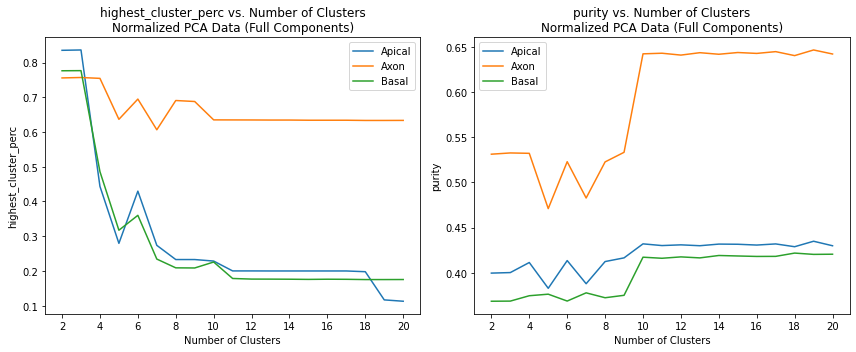

In [35]:
gmm = reload(gmm)
gmm.gmm_pipeline(df_col_filtered,
                 labeled_data_indices = labeled_data_indices,
                 title_suffix = "Normalized PCA Data (Full Components)",
                 columns_picked = None,
                 possible_K = possible_K,
                 apply_normalization=True,
                 apply_pca=True,
                 
                )

# Part 5: GMM on PCA Dataset (4 Components)

# -------- Part 0: Preprocessing (Column restriction, Normalization, PCA) ----------- #
Applying Normalization
Applying pca with 4 components
n_components = 4
whiten = True
---- Using sklearn method ----


<Figure size 432x288 with 0 Axes>

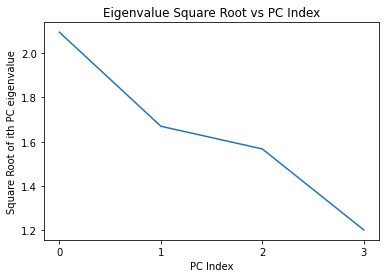

Explained Variance = [0.24358275 0.39851786 0.53504943 0.61538891]


<Figure size 432x288 with 0 Axes>

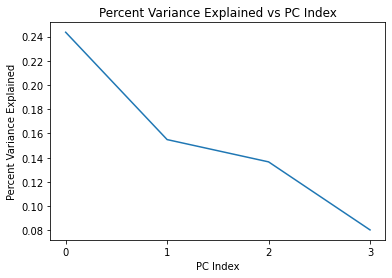

# -------- Part 1: GMM clustering with different Number of Clusters ----------- # 


------Working on clusters K=2-----
Using mixture model
reversing the pca transformation
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 2.6451103687286377


------Working on clusters K=3-----
Using mixture model
reversing the pca transformation
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 3.8386218547821045


------Working on clusters K=4-----
Using mixture model
reversing the pca transformation
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 3.122248888015747


------Working on clusters K=5-----
Using mixture model
reversing the pca transformation
reversing the normalizing transformation
Convergence status = True
Total time for GMM = 4.555091381072998


------Working on clusters K=6-----
Using mixture model
reversing the pca transformation
reversing the normalizing transformation


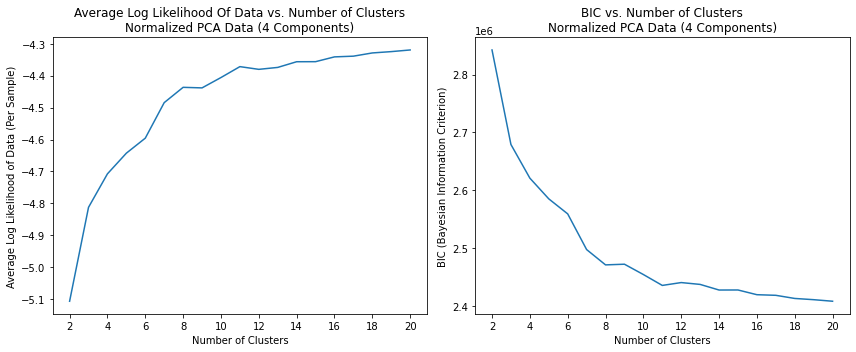

# --------- Part 2: computing the advanced statistics on the clustering ------- # 


----Working on Advanced Statistics for n_clusters = 2----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,445.085065,434.700433,3.785868,1.378709e+07,3.123918e+07,2272.186823,14844.442858,40.119094,85.608921,330.242878,312.310546,6.667772,4.237409e+08,3.454599e+07,20136.918701,20209.163311,44.195787,82.606845
1,388.369221,363.433472,14.499465,1.329760e+09,5.455809e+07,43017.594788,28881.031049,40.067713,79.566407,298.506976,253.327384,32.011703,2.102876e+09,3.720411e+07,35434.184878,54187.516537,41.275596,75.039582




Clustering Numbers By Neuroscience Category for K = 2


,classification,category,n_clusters,cl_0,cl_1
2,hard,Apical,2,4805,3195
0,hard,Axon,2,6943,1057
1,hard,Basal,2,3767,4233




Clustering Advanced Statistics By Neuroscience Category for K = 2


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,2,0,0.600625,2,0.336397
0,Axon,hard,2,0,0.867875,1,0.404835
1,Basal,hard,2,1,0.529125,2,0.378297




----Working on Advanced Statistics for n_clusters = 3----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,428.010714,409.218288,8.708915,7.380314e+08,5.353649e+07,30118.824365,19310.528606,38.175981,79.340004,356.801560,303.761714,37.565308,2.498484e+09,4.720927e+07,42820.032865,61326.664149,34.934060,70.313878
1,456.100944,447.731039,2.207407,-1.491183e+08,2.876411e+07,-2030.038782,12580.175447,41.375707,87.755565,337.691768,321.416089,5.455799,3.433891e+08,3.439230e+07,19081.948954,18774.235841,45.055431,83.893666
2,302.357678,268.046797,25.027681,2.230375e+09,4.413048e+07,54620.452687,48459.083598,42.303997,80.126185,150.347858,144.532137,-0.634551,-1.342937e+08,8.512038e+06,5630.110899,10806.027066,58.707653,90.905383




Clustering Numbers By Neuroscience Category for K = 3


,classification,category,n_clusters,cl_0,cl_1,cl_2
2,hard,Apical,3,3465,3946,589
0,hard,Axon,3,847,6063,1090
1,hard,Basal,3,4027,2648,1325




Clustering Advanced Statistics By Neuroscience Category for K = 3


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,3,1,0.493250,2,0.348185
0,Axon,hard,3,1,0.757875,2,0.423232
1,Basal,hard,3,0,0.503375,2,0.385389




----Working on Advanced Statistics for n_clusters = 4----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,421.484274,404.064451,7.627807,6.289628e+08,5.290489e+07,27597.383007,17773.438492,39.179542,80.377237,354.903123,299.579746,40.601808,2.696832e+09,4.725461e+07,43862.452855,66091.837505,34.887239,69.724443
1,251.636576,239.563974,8.874369,3.282572e+08,1.752291e+07,-688.502137,27685.423634,49.466132,91.331004,117.601568,120.834246,-0.018445,-1.356087e+08,1.215623e+06,-2951.504622,18179.765527,62.264882,92.535702
2,514.677287,504.699153,2.232874,-6.911974e+07,3.551156e+07,3811.469964,10770.716038,37.478447,84.392224,402.403444,378.584947,7.746384,5.337337e+08,4.517982e+07,27051.632986,19210.360303,38.899337,80.230952
3,361.048668,316.151395,31.650853,3.110983e+09,6.277768e+07,84397.717153,55230.973195,37.598490,73.647236,214.059396,192.231768,7.643839,4.609460e+08,2.096244e+07,18897.850757,17787.089906,51.910817,85.873949




Clustering Numbers By Neuroscience Category for K = 4


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3
2,hard,Apical,4,2981,375,4164,480
0,hard,Axon,4,708,5369,1655,268
1,hard,Basal,4,3483,970,2720,827




Clustering Advanced Statistics By Neuroscience Category for K = 4


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,4,2,0.520500,2,0.429602
0,Axon,hard,4,1,0.671125,2,0.591213
1,Basal,hard,4,0,0.435375,3,0.391536




----Working on Advanced Statistics for n_clusters = 5----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,407.170558,389.724187,7.716342,6.564046e+08,5.365017e+07,28820.657726,17976.336205,40.770181,81.508101,344.352991,285.814708,44.875984,2.973339e+09,4.617460e+07,44994.963094,72651.923055,35.616271,69.384932
1,491.508587,476.124467,6.034000,3.526257e+08,4.507342e+07,16665.707434,15601.608785,33.259927,77.524509,398.482400,363.966135,16.090999,1.096751e+09,4.947486e+07,34470.641221,29705.384300,33.920867,74.086427
2,508.965348,501.557076,0.712194,-2.547977e+08,2.997097e+07,-2680.662543,9308.635879,40.360167,88.206412,387.140601,369.435540,3.988956,2.704500e+08,4.059011e+07,22040.884484,15162.063317,42.615692,83.737320
3,255.636844,242.289283,9.826000,4.423232e+08,1.881651e+07,2572.641602,28938.716138,49.363557,91.079990,119.024566,122.232728,-0.435036,-1.615711e+08,1.277631e+06,-2854.961484,17254.443547,62.462536,92.871973
4,351.753424,305.078089,33.210457,3.275104e+09,6.379127e+07,88327.220508,57672.614039,37.726476,73.236096,201.904497,180.936422,7.062180,4.175184e+08,1.918399e+07,17898.430516,16989.496139,52.925676,86.484071




Clustering Numbers By Neuroscience Category for K = 5


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4
2,hard,Apical,5,2460,1882,2855,386,417
0,hard,Axon,5,610,474,1675,4975,266
1,hard,Basal,5,2841,1798,1638,969,754




Clustering Advanced Statistics By Neuroscience Category for K = 5


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,5,2,0.356875,3,0.417811
0,Axon,hard,5,3,0.621875,2,0.566399
1,Basal,hard,5,0,0.355125,4,0.390333




----Working on Advanced Statistics for n_clusters = 6----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,512.889500,505.469503,0.663537,-2.537881e+08,3.017570e+07,-2.444385e+03,9.146029e+03,40.368454,88.306499,390.681033,372.742698,4.017209,2.740123e+08,4.101607e+07,22310.690108,15082.274507,42.496168,83.762333
1,493.107953,477.683026,6.085664,3.518733e+08,4.479243e+07,1.642184e+04,1.570944e+04,32.968011,77.302598,398.941025,365.397836,14.996569,1.024731e+09,4.940756e+07,33977.044653,28099.522207,33.927388,74.270984
2,250.620408,238.622437,8.835615,3.191602e+08,1.733891e+07,-1.064642e+03,2.766763e+04,49.314525,91.170510,116.803964,120.313760,-0.273585,-1.527568e+08,1.148427e+06,-3108.739041,17847.038229,62.204538,92.479301
3,6891.202024,4058.537947,2101.577552,2.610106e+11,3.225052e+09,7.722952e+06,2.751255e+06,359.031507,-14.591268,2012.624422,788.134267,478.285379,3.401317e+10,3.888252e+07,731824.652995,49377.513726,675.257424,754.133973
4,404.697160,388.540321,6.698355,5.439921e+08,5.271343e+07,2.591043e+04,1.653853e+04,41.076606,81.972023,345.052538,285.663284,46.108266,3.054187e+09,4.646578e+07,45451.893164,74687.330732,35.318997,68.920188
5,370.733899,327.157643,30.362752,2.996406e+09,6.295875e+07,8.242404e+04,5.302077e+04,38.006844,74.438146,227.606423,202.871592,10.229693,6.376921e+08,2.310640e+07,21044.635064,21335.803179,50.905972,85.049252




Clustering Numbers By Neuroscience Category for K = 6


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5
2,hard,Apical,6,2834,1855,345,0,2353,613
0,hard,Axon,6,1556,456,5078,0,597,313
1,hard,Basal,6,1604,1770,897,0,2702,1027




Clustering Advanced Statistics By Neuroscience Category for K = 6


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,6,0,0.35425,3,0.421742
0,Axon,hard,6,2,0.63475,2,0.581022
1,Basal,hard,6,4,0.33775,4,0.394500




----Working on Advanced Statistics for n_clusters = 7----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,402.919521,389.352274,4.849806,2.972349e+08,4.879459e+07,18008.558132,14256.458715,40.290735,81.810033,343.908850,288.431855,42.703106,2.826811e+09,4.599266e+07,43250.552009,70375.700396,35.044944,69.049656
1,198.930793,195.971751,2.662858,-4.287266e+08,5.781680e+06,-23665.631724,20374.419571,53.754415,96.485047,75.636460,82.131982,2.714375,1.292137e+07,-5.357927e+06,-7611.497318,25794.990272,65.315157,93.227417
2,509.414310,500.786790,1.290904,-2.164813e+08,3.339647e+07,-1228.238380,9690.024903,35.884919,82.935022,400.136010,378.748034,5.340416,3.743459e+08,4.530812e+07,25915.575573,16024.373274,37.878732,79.461420
3,440.798899,376.312356,45.066311,4.820146e+09,9.071857e+07,138096.371426,71031.170203,33.623125,66.686795,280.856693,241.449414,15.192572,1.014238e+09,3.271198e+07,33050.386090,21733.610776,47.522847,83.601791
4,458.152689,430.813342,15.302831,1.439290e+09,5.956282e+07,47789.842717,28455.941665,33.391815,73.809031,365.859541,320.824250,25.456811,1.711605e+09,4.756526e+07,39592.431251,41545.184222,34.904402,72.571007
5,294.821862,265.442461,21.479487,1.804724e+09,3.765253e+07,41924.108520,43951.789976,43.631201,82.531124,144.236872,142.132924,-2.346284,-2.564523e+08,6.681289e+06,2809.378479,9750.332632,59.697508,91.778886
6,582.488582,569.386512,4.105453,3.801460e+08,4.011727e+07,21067.914881,12061.215303,48.044870,96.778803,437.471745,409.246023,12.323746,8.401701e+08,4.381218e+07,28254.403157,24737.373196,46.884697,88.890958




Clustering Numbers By Neuroscience Category for K = 7


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6
2,hard,Apical,7,2320,32,2856,92,1187,581,932
0,hard,Axon,7,632,4239,945,20,275,1408,481
1,hard,Basal,7,2792,147,1991,75,1467,1320,208




Clustering Advanced Statistics By Neuroscience Category for K = 7


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,7,2,0.357000,4,0.438716
0,Axon,hard,7,1,0.529875,3,0.632596
1,Basal,hard,7,0,0.349000,4,0.420562




----Working on Advanced Statistics for n_clusters = 8----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,197.934509,195.176977,2.527093,-4.445255e+08,5.507210e+06,-24139.989589,20215.178408,53.907980,96.668306,74.694010,81.283502,2.770459,1.581761e+07,-5.543504e+06,-7743.588679,25962.448461,65.438831,93.297801
1,465.093493,446.887099,8.796666,6.007785e+08,4.503777e+07,21108.042456,20358.663492,32.607401,75.841033,366.182981,336.610084,12.092532,8.186050e+08,4.477911e+07,30466.920224,24426.096332,35.988684,75.411625
2,669.894429,610.194777,37.342886,4.567999e+09,1.042862e+08,150123.271934,53449.050055,46.091873,85.310647,501.445874,427.771171,41.534459,2.847060e+09,5.877939e+07,58630.870529,53923.225688,43.747543,85.092739
3,292.076499,261.025959,22.874205,1.967071e+09,3.884683e+07,46239.730553,46012.587803,44.277476,82.850390,137.286727,135.557470,-2.568513,-2.744006e+08,5.302265e+06,2159.747203,9356.026570,60.901160,92.734354
4,513.565365,505.674550,0.718153,-2.815510e+08,3.238888e+07,-3090.420942,8885.657640,35.993774,83.368157,403.125740,382.737293,4.388011,3.118037e+08,4.536404e+07,25393.786627,14737.387239,37.991201,79.819002
5,411.659581,400.054744,3.288563,1.366019e+08,4.669662e+07,13884.284120,11989.412239,41.401545,83.676152,350.939925,296.256935,42.324289,2.801890e+09,4.611176e+07,42738.618901,70117.580577,35.575228,69.877048
6,410.018063,378.792052,18.471546,1.843156e+09,6.616694e+07,60325.723222,33055.595145,36.658007,74.587013,329.323309,272.827981,38.967760,2.589538e+09,4.471736e+07,44303.835633,61420.655785,36.376603,70.622229
7,599.071233,590.032151,1.383867,1.052796e+08,3.233223e+07,12767.691690,8741.788274,53.844501,104.773584,433.781134,413.914249,6.862965,4.635945e+08,3.834779e+07,21553.222526,18438.904936,53.086279,95.526773




Clustering Numbers By Neuroscience Category for K = 8


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7
2,hard,Apical,8,25,1521,92,529,2336,2058,762,677
0,hard,Axon,8,4120,581,17,1352,771,499,195,465
1,hard,Basal,8,141,1600,25,1200,1619,2213,1081,121




Clustering Advanced Statistics By Neuroscience Category for K = 8


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,8,4,0.292000,4,0.433678
0,Axon,hard,8,0,0.515000,4,0.626862
1,Basal,hard,8,5,0.276625,4,0.416813




----Working on Advanced Statistics for n_clusters = 9----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,608.184043,596.048873,3.073366,3.198208e+08,3.991356e+07,2.081913e+04,1.010255e+04,49.833622,99.550686,457.754646,428.708831,12.730204,8.733775e+08,4.526231e+07,29031.888260,24994.159230,47.565096,90.316348
1,507.946914,499.473343,1.193025,-2.268576e+08,3.320680e+07,-1.524072e+03,9.583309e+03,36.109031,83.163145,398.801391,377.352299,5.582208,3.893175e+08,4.508055e+07,25844.140003,16464.703954,38.041618,79.528025
2,298.644169,258.420372,29.843710,2.778489e+09,4.862365e+07,6.909958e+04,5.544612e+04,42.949475,79.671111,133.591020,129.481753,-2.720880,-2.778659e+08,5.248953e+06,3821.182846,7165.437763,61.511290,93.372330
3,399.446850,386.124692,4.541791,2.946032e+08,4.995661e+07,1.899205e+04,1.361833e+04,41.579185,82.915308,344.582805,285.068970,47.136008,3.119511e+09,4.650462e+07,45373.407053,76821.563437,35.015283,68.401800
4,6891.202024,4058.537947,2101.577552,2.610106e+11,3.225052e+09,7.722952e+06,2.751255e+06,359.031507,-14.591268,2012.624422,788.134267,478.285379,3.401317e+10,3.888252e+07,731824.652995,49377.513726,675.257424,754.133973
5,442.521158,400.792608,26.675786,2.810942e+09,7.418105e+07,8.671851e+04,4.438680e+04,37.483276,74.639926,329.094787,278.005401,31.084895,2.071549e+09,4.149482e+07,40837.080765,47996.177337,41.132414,76.606997
6,294.325627,279.655273,10.010589,4.724193e+08,2.332805e+07,5.036248e+03,2.801497e+04,43.856914,85.738897,165.116300,164.964464,-1.639902,-2.100570e+08,9.893871e+06,2321.502983,13267.028987,56.314092,88.950228
7,463.997014,442.136384,11.100561,9.060004e+08,5.284727e+07,3.179748e+04,2.278474e+04,31.093463,72.869696,376.933450,337.241041,20.230552,1.369430e+09,4.913538e+07,37371.278150,34737.014860,32.751810,71.574522
8,198.734860,196.260761,2.311993,-4.615068e+08,5.217619e+06,-2.447960e+04,1.990648e+04,54.460392,97.335362,74.823318,81.309731,3.096313,3.646772e+07,-5.774834e+06,-7821.452909,26528.344729,65.810713,93.614812




Clustering Numbers By Neuroscience Category for K = 9


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8
2,hard,Apical,9,828,2829,281,2042,0,472,365,1160,23
0,hard,Axon,9,419,944,202,515,0,100,1519,298,4003
1,hard,Basal,9,160,1963,654,2333,0,445,757,1559,129




Clustering Advanced Statistics By Neuroscience Category for K = 9


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,9,1,0.353625,4,0.440041
0,Axon,hard,9,8,0.500375,3,0.642470
1,Basal,hard,9,3,0.291625,4,0.425065




----Working on Advanced Statistics for n_clusters = 10----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,286.012339,271.246216,10.280649,4.974188e+08,2.258933e+07,5.250865e+03,2.867013e+04,44.842694,86.620686,154.471954,155.401081,-1.852045,-2.307202e+08,7.930554e+06,1017.482797,13379.534636,57.669875,89.871609
1,515.213122,507.294736,0.722373,-2.716047e+08,3.251866e+07,-2.610640e+03,8.847422e+03,36.468605,83.899946,403.944002,383.212159,4.812246,3.396571e+08,4.527796e+07,25507.227101,15346.606129,38.298387,80.092600
2,394.525667,373.963564,10.129838,8.926463e+08,5.722783e+07,3.476840e+04,2.142082e+04,37.832972,77.310007,336.719215,276.878192,44.982440,2.983544e+09,4.701445e+07,46270.639593,72143.971282,33.691565,67.228180
3,443.893999,402.170947,26.904328,2.767604e+09,7.173462e+07,8.344986e+04,4.514073e+04,34.688788,72.077893,325.919344,281.869584,23.426767,1.565530e+09,4.074959e+07,37203.350535,36974.447976,40.646136,77.108985
4,297.413876,256.350891,30.510935,2.853594e+09,4.941509e+07,7.112177e+04,5.639700e+04,42.877135,79.390195,131.469013,127.259165,-2.735054,-2.791273e+08,4.999258e+06,3823.541378,7028.222818,61.674303,93.462168
5,197.199049,194.830795,2.265296,-4.664025e+08,4.980315e+06,-2.466804e+04,1.988957e+04,54.750773,97.634849,72.942158,79.555459,3.187789,4.111849e+07,-6.154003e+06,-8043.783165,26767.880956,66.102107,93.807394
6,628.404557,617.512463,2.220641,2.620621e+08,3.690540e+07,1.933361e+04,8.948268e+03,53.259220,104.294161,463.190211,438.431437,9.416415,6.495133e+08,4.286996e+07,25750.258602,20643.218099,51.200301,94.556831
7,485.660522,467.881319,7.977735,5.296449e+08,4.678322e+07,2.049391e+04,1.850870e+04,30.676489,74.219579,392.386361,359.714677,13.243408,9.103338e+08,4.948177e+07,33811.219531,25125.840729,32.912513,73.304785
8,6891.202024,4058.537947,2101.577552,2.610106e+11,3.225052e+09,7.722952e+06,2.751255e+06,359.031507,-14.591268,2012.624422,788.134267,478.285379,3.401317e+10,3.888252e+07,731824.652995,49377.513726,675.257424,754.133973
9,421.913320,412.236070,1.815695,2.548593e+06,4.427452e+07,1.063407e+04,9.888878e+03,43.975635,87.176462,355.602163,302.062539,42.138865,2.786411e+09,4.507128e+07,41545.854608,70325.136286,37.502738,71.947624




Clustering Numbers By Neuroscience Category for K = 10


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9
2,hard,Apical,10,350,2507,981,439,264,18,640,1208,0,1593
0,hard,Axon,10,1575,855,257,109,197,3899,395,339,0,374
1,hard,Basal,10,732,1692,1418,464,626,118,114,1355,0,1481




Clustering Advanced Statistics By Neuroscience Category for K = 10


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,10,1,0.313375,5,0.437745
0,Axon,hard,10,5,0.487375,4,0.641765
1,Basal,hard,10,1,0.211500,5,0.422748




----Working on Advanced Statistics for n_clusters = 11----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,384.918920,369.927378,5.763130,3.946570e+08,5.272431e+07,21424.824394,15322.033793,38.359249,78.570071,340.166093,278.126164,48.575470,3.219279e+09,4.834600e+07,47577.625730,78394.542916,32.104070,65.191653
1,614.911084,603.181161,2.998638,3.200470e+08,3.747052e+07,20226.963242,10279.488903,52.093856,102.513800,452.866059,428.256266,9.316624,6.403674e+08,4.230797e+07,25583.634503,20569.315941,50.652315,93.624755
2,197.130901,194.821082,2.232934,-4.676665e+08,4.863075e+06,-24685.971577,19856.777985,55.003127,97.919410,72.389449,79.049130,3.260035,4.521798e+07,-6.357496e+06,-8158.287346,26922.342007,66.326087,93.992386
3,480.167959,464.138244,6.783184,3.735552e+08,4.410787e+07,15481.168706,17111.802529,30.808932,74.681862,387.342254,356.857152,11.835315,8.129395e+08,4.847905e+07,32267.693009,23679.758118,33.257680,73.606239
4,441.256771,402.576036,24.467797,2.477056e+09,6.931638e+07,75475.958838,41691.615044,33.810009,71.609960,331.632299,286.908887,24.308578,1.626138e+09,4.237362e+07,38045.831889,38627.432950,38.845922,75.397306
5,285.439257,270.094237,10.723578,5.462450e+08,2.322556e+07,6583.908386,29281.042954,44.608611,86.228322,153.800560,154.535486,-1.834910,-2.291339e+08,7.977549e+06,1171.898946,13281.786797,57.576832,89.761123
6,296.846045,254.895220,31.233781,2.938296e+09,5.011812e+07,73412.867194,57440.513844,43.126480,79.478411,128.813442,124.729943,-2.866924,-2.889373e+08,4.446538e+06,3585.269005,6756.848522,62.194303,93.897533
7,911.033111,837.573441,44.224277,5.862189e+09,1.325399e+08,201290.788480,56623.530889,49.736111,91.704550,705.392949,607.177403,51.795892,3.630056e+09,8.313249e+07,80065.358637,59037.968687,39.940073,88.540522
8,529.582986,521.969185,0.504734,-2.938907e+08,3.110391e+07,-3515.428370,8537.999989,36.778648,84.889163,410.706740,393.417089,1.140795,9.821116e+07,4.487934e+07,23600.100914,9985.618196,39.257710,81.836797
9,436.102785,414.651995,10.525235,1.095897e+09,5.887936e+07,43531.896652,21197.362798,45.630582,86.529192,357.145892,294.626820,48.466830,3.213177e+09,4.544562e+07,46607.256206,76863.390919,39.485476,73.255484




Clustering Numbers By Neuroscience Category for K = 11


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10
2,hard,Apical,11,922,617,18,1289,509,344,262,32,2034,888,1085
0,hard,Axon,11,287,384,3887,381,136,1546,189,6,696,123,365
1,hard,Basal,11,1546,117,115,1439,669,756,598,13,1162,497,1088




Clustering Advanced Statistics By Neuroscience Category for K = 11


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,11,8,0.254250,6,0.445090
0,Axon,hard,11,2,0.485875,4,0.638250
1,Basal,hard,11,0,0.193250,6,0.428386




----Working on Advanced Statistics for n_clusters = 12----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,386.122594,370.938302,5.887151,4.175688e+08,5.309876e+07,2.227737e+04,1.544140e+04,38.708566,78.910403,340.891084,278.308627,49.126175,3.255803e+09,4.835630e+07,47840.803627,79140.897942,32.294965,65.332291
1,632.992970,621.055510,2.897476,3.400864e+08,3.855215e+07,2.175523e+04,9.703336e+03,52.222689,103.041070,468.779317,443.063197,9.487466,6.592558e+08,4.416975e+07,26807.550465,20246.980737,50.217038,93.833545
2,477.381558,461.594850,6.613689,3.459904e+08,4.384587e+07,1.456185e+04,1.692282e+04,30.458698,74.279269,386.077068,355.662439,11.801329,8.104607e+08,4.855120e+07,32269.379923,23697.834048,32.940263,73.243670
3,282.236362,267.521632,10.284192,4.907184e+08,2.242874e+07,4.882468e+03,2.875239e+04,44.706225,86.386294,151.577655,152.608554,-1.812078,-2.292664e+08,7.684100e+06,884.375100,13533.066384,57.622932,89.699601
4,197.337129,195.027603,2.227864,-4.682181e+08,4.882122e+06,-2.469187e+04,1.984304e+04,54.971023,97.889224,72.657470,79.296251,3.256434,4.515700e+07,-6.306031e+06,-8127.356988,26905.729072,66.287907,93.966563
5,404.634517,349.990033,37.939566,3.908367e+09,7.899154e+07,1.104285e+05,6.206645e+04,32.371658,66.550408,263.041455,228.491598,13.548359,8.916485e+08,3.135494e+07,29770.057756,22019.908472,45.604234,81.043661
6,529.050343,521.412172,0.493375,-2.953496e+08,3.137358e+07,-3.467024e+03,8.484349e+03,36.556340,84.598582,411.458951,393.636663,1.561326,1.268821e+08,4.522678e+07,24007.394692,10535.828413,38.919714,81.476377
7,441.286579,423.153919,7.919589,8.477105e+08,5.597591e+07,3.770922e+04,1.743481e+04,48.999912,90.871811,361.905585,298.019073,51.375639,3.401151e+09,4.483852e+07,46722.390222,81838.672004,41.085435,74.535302
8,452.050575,420.114085,18.904571,1.869550e+09,6.448568e+07,6.002673e+04,3.347110e+04,34.205915,73.484461,354.906523,307.467139,27.539710,1.846682e+09,4.611312e+07,40431.737902,43945.115869,36.334189,73.303541
9,445.320132,437.153774,1.029047,-1.838197e+08,3.744698e+07,2.018797e+03,9.445502e+03,40.692166,85.493220,361.637071,323.817685,25.505456,1.688093e+09,4.330024e+07,33142.699993,46505.856386,38.316072,75.373719




Clustering Numbers By Neuroscience Category for K = 12


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11
2,hard,Apical,12,998,581,1178,332,18,104,2090,664,654,1112,269,0
0,hard,Axon,12,296,361,358,1550,3887,31,719,84,162,357,195,0
1,hard,Basal,12,1588,112,1357,713,116,120,1227,241,839,1052,635,0




Clustering Advanced Statistics By Neuroscience Category for K = 12


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,12,6,0.261250,6,0.446671
0,Axon,hard,12,4,0.485875,4,0.640204
1,Basal,hard,12,0,0.198500,6,0.430265




----Working on Advanced Statistics for n_clusters = 13----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,281.715196,267.096909,10.221547,4.839666e+08,2.229004e+07,4.683531e+03,2.868144e+04,44.830414,86.527165,150.992140,152.062428,-1.757481,-2.261799e+08,7.554772e+06,806.294477,13661.328242,57.726606,89.767285
1,298.259077,257.663735,30.162892,2.816235e+09,4.881672e+07,7.008812e+04,5.592705e+04,43.194630,79.866316,131.810034,127.929531,-2.873531,-2.889892e+08,4.820921e+06,3553.758634,6946.908275,61.908307,93.716713
2,435.911315,403.886630,19.126619,1.883318e+09,6.452212e+07,6.008829e+04,3.403101e+04,34.549772,73.339042,342.144403,293.712227,29.346570,1.960180e+09,4.486765e+07,40467.789920,46951.967325,36.637161,72.814149
3,532.178513,524.647834,0.401765,-3.009384e+08,3.115545e+07,-3.562690e+03,8.331163e+03,36.818228,85.009137,413.146415,395.690455,1.199035,1.031261e+08,4.516629e+07,23780.368449,10008.357818,39.180011,81.851287
4,6891.202024,4058.537947,2101.577552,2.610106e+11,3.225052e+09,7.722952e+06,2.751255e+06,359.031507,-14.591268,2012.624422,788.134267,478.285379,3.401317e+10,3.888252e+07,731824.652995,49377.513726,675.257424,754.133973
5,456.190342,446.932058,1.951668,-1.483454e+08,3.650109e+07,1.129909e+03,1.094170e+04,36.610323,81.581828,367.306897,336.425775,16.788229,1.118701e+09,4.408588e+07,30236.278460,33338.726307,36.806248,75.411836
6,429.290862,373.084228,38.806518,4.062157e+09,8.176557e+07,1.161928e+05,6.266762e+04,33.197965,67.688913,282.067248,245.438331,14.361017,9.545097e+08,3.326536e+07,31516.184253,22270.309989,45.789719,81.920865
7,472.029535,464.826921,0.257803,-9.919036e+07,3.659504e+07,7.408829e+03,7.952743e+03,51.573568,97.982952,366.723566,326.028485,31.429044,2.066361e+09,3.870236e+07,32220.892211,55861.723525,46.527853,82.748595
8,197.328127,195.009843,2.241735,-4.656730e+08,4.852450e+06,-2.462092e+04,1.986955e+04,55.079783,98.007322,72.342506,79.026829,3.257639,4.492155e+07,-6.412801e+06,-8194.906616,26924.890138,66.401114,94.064423
9,485.287095,467.765351,7.769907,4.880863e+08,4.642392e+07,1.901525e+04,1.824605e+04,29.526348,73.061842,393.846567,361.912513,12.160420,8.406967e+08,5.009546e+07,33720.504854,23497.800558,32.029469,72.652339




Clustering Numbers By Neuroscience Category for K = 13


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12
2,hard,Apical,13,329,268,598,2028,0,987,120,585,18,1042,734,869,422
0,hard,Axon,13,1550,196,143,698,0,313,29,344,3896,298,109,287,137
1,hard,Basal,13,708,639,839,1130,0,1085,109,210,117,1195,358,1537,73




Clustering Advanced Statistics By Neuroscience Category for K = 13


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,13,3,0.253500,7,0.450473
0,Axon,hard,13,8,0.487000,4,0.640220
1,Basal,hard,13,11,0.192125,6,0.434759




----Working on Advanced Statistics for n_clusters = 14----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,381.179997,364.196725,7.113565,5.583658e+08,5.640382e+07,26712.931362,16930.959158,37.340917,76.731121,342.003944,275.717506,51.917788,3.445238e+09,5.005619e+07,50476.714213,82576.617702,30.584715,63.332637
1,515.944053,508.197959,0.679157,-2.909543e+08,3.151845e+07,-3695.166352,8931.917758,36.203296,83.794621,402.269778,383.700547,2.712507,1.996248e+08,4.466727e+07,24209.734456,12429.158909,38.626997,80.646274
2,441.403589,426.305418,6.347273,2.730269e+08,4.339552e+07,11708.418855,17051.241004,29.771952,72.554547,362.254228,329.548852,15.455891,1.042549e+09,4.718617e+07,32946.272832,29788.797155,32.041517,70.839578
3,196.623531,194.316292,2.241243,-4.682316e+08,4.808845e+06,-24749.728823,19885.604348,54.979712,97.886868,71.874856,78.637679,3.180513,3.972311e+07,-6.426335e+06,-8233.463276,26824.967178,66.342377,93.998597
4,637.497764,627.044907,2.109435,2.281607e+08,3.401714e+07,17166.188487,9116.642987,53.549493,105.316178,461.650724,443.252829,3.331181,2.436424e+08,4.082199e+07,21779.794834,12150.674356,53.033756,97.161884
5,944.706191,875.527347,40.452918,5.439498e+09,1.291487e+08,190356.947049,50730.932327,47.665934,91.316798,742.393974,645.762559,48.589909,3.434975e+09,8.817227e+07,81014.988946,53999.431701,36.797031,87.372516
6,438.476792,406.066808,19.376171,1.931245e+09,6.526845e+07,61883.165816,34269.866646,35.382205,74.166153,343.501961,293.945813,30.530323,2.038447e+09,4.481529e+07,40979.231566,48575.897955,37.124907,73.183438
7,419.661860,410.237987,1.844150,-5.840770e+07,4.194753e+07,7084.618376,10351.524284,41.500014,84.838757,350.870945,303.199999,35.897968,2.373155e+09,4.434431e+07,38477.002953,61452.498391,36.950533,72.111056
8,384.851875,331.094536,37.590987,3.822348e+09,7.666767e+07,106615.611456,62151.361647,31.949902,65.881208,245.308691,213.364010,12.074293,7.852817e+08,2.912772e+07,27649.975086,20671.299192,46.046469,80.942786
9,535.703181,516.293683,8.628598,6.929219e+08,5.006109e+07,27417.342915,18346.887558,31.754745,76.330884,431.227501,396.830252,12.610344,8.862319e+08,5.319788e+07,36012.958317,22662.639745,33.039851,75.152438




Clustering Numbers By Neuroscience Category for K = 14


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13
2,hard,Apical,14,483,2217,411,17,520,43,562,1113,96,903,269,381,651,334
0,hard,Axon,14,175,766,233,3827,271,6,139,261,43,125,196,301,81,1576
1,hard,Basal,14,1040,1442,1041,111,88,14,724,1135,156,501,628,169,228,723




Clustering Advanced Statistics By Neuroscience Category for K = 14


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,14,1,0.277125,7,0.460745
0,Axon,hard,14,3,0.478375,4,0.639886
1,Basal,hard,14,1,0.180250,7,0.442510




----Working on Advanced Statistics for n_clusters = 15----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,193.058130,190.842858,2.239150,-4.729060e+08,4.442310e+06,-2.508093e+04,1.998782e+04,55.196827,98.063766,68.089885,75.227411,3.109492,3.279182e+07,-7.032936e+06,-8656.677165,26887.742333,66.676301,94.178148
1,430.551641,397.426973,19.994544,1.977676e+09,6.583445e+07,6.265308e+04,3.527309e+04,34.204170,72.552002,337.914802,288.572709,30.119755,2.010845e+09,4.474719e+07,40952.053100,47927.189701,36.460676,72.375497
2,495.480901,477.210454,8.166851,5.635423e+08,4.803716e+07,2.198851e+04,1.847970e+04,30.041977,73.643754,402.560913,368.808149,13.430701,9.289739e+08,5.113274e+07,35007.123996,24894.885504,32.013158,72.825509
3,440.659777,430.550542,2.180765,3.526571e+07,4.307920e+07,1.088215e+04,1.041713e+04,43.521192,87.414391,363.959500,315.516002,36.311367,2.404164e+09,4.471360e+07,38901.241268,61619.837050,38.395047,74.017904
4,539.264267,533.898056,-0.935082,-2.594993e+08,2.818807e+07,5.080537e+02,6.521724e+03,51.792250,101.589948,396.046997,375.324783,10.268568,6.725886e+08,3.624786e+07,21200.250785,25175.847357,50.917383,91.286043
5,6891.202024,4058.537947,2101.577552,2.610106e+11,3.225052e+09,7.722952e+06,2.751255e+06,359.031507,-14.591268,2012.624422,788.134267,478.285379,3.401317e+10,3.888252e+07,731824.652995,49377.513726,675.257424,754.133973
6,418.058883,360.777800,39.894662,4.168808e+09,8.166689e+07,1.183105e+05,6.456250e+04,33.712406,67.828812,267.458195,232.536594,13.363905,8.812090e+08,3.086342e+07,29812.236501,21147.148239,47.228245,82.891765
7,327.174672,306.408970,14.098284,9.835402e+08,3.194330e+07,2.102030e+04,3.270553e+04,41.320921,82.460900,193.532344,189.100694,-1.292943,-1.652383e+08,1.472870e+07,6629.575651,11285.012397,54.002024,87.920678
8,752.171350,729.376435,8.940018,1.262617e+09,5.982982e+07,5.577771e+04,1.431836e+04,48.765049,99.354926,583.131000,538.806573,17.722465,1.274004e+09,6.186675e+07,43193.023247,25519.078639,42.895973,90.387352
9,254.984038,245.776053,6.493557,3.021840e+07,1.528247e+07,-9.056929e+03,2.422362e+04,47.104644,89.446054,129.732951,133.210036,-0.893911,-1.862557e+08,4.050165e+06,-2037.118249,16957.988801,59.357591,90.262324




Clustering Numbers By Neuroscience Category for K = 15


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14
2,hard,Apical,15,11,499,1091,1167,421,0,105,213,208,175,673,263,812,1817,545
0,hard,Axon,15,3488,127,298,235,441,0,27,251,50,1822,246,189,392,337,97
1,hard,Basal,15,94,773,1212,749,130,0,91,482,34,360,1372,598,1322,508,275




Clustering Advanced Statistics By Neuroscience Category for K = 15


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,15,13,0.227125,7,0.474343
0,Axon,hard,15,0,0.436000,5,0.664315
1,Basal,hard,15,10,0.171500,7,0.455919




----Working on Advanced Statistics for n_clusters = 16----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,280.138652,265.274928,10.468604,5.133907e+08,2.226337e+07,5.397622e+03,2.909801e+04,45.267823,86.927775,147.890889,149.290721,-1.847547,-2.341642e+08,6.869821e+06,378.685707,13618.911344,58.308353,90.226729
1,541.227917,533.611178,0.652992,-2.533369e+08,2.952340e+07,-2.545375e+03,8.864256e+03,39.267589,88.096900,410.116161,396.294674,-1.592648,-8.762932e+07,4.246607e+07,20835.915625,6315.646287,42.306183,85.193509
2,415.987187,396.232623,9.425185,9.711312e+08,5.713344e+07,3.996069e+04,1.998673e+04,47.451348,88.188216,341.681122,277.694532,51.786084,3.422330e+09,4.344175e+07,46440.475574,82620.335610,40.532397,73.130915
3,645.474160,589.782301,34.076433,4.191158e+09,1.030986e+08,1.406185e+05,4.876748e+04,45.363272,84.220276,499.706963,418.955013,49.552438,3.377421e+09,6.145186e+07,63018.759784,66205.238080,40.301393,80.410668
4,6891.202024,4058.537947,2101.577552,2.610106e+11,3.225052e+09,7.722952e+06,2.751255e+06,359.031507,-14.591268,2012.624422,788.134267,478.285379,3.401317e+10,3.888252e+07,731824.652995,49377.513726,675.257424,754.133973
5,381.800298,366.028485,6.277637,4.540746e+08,5.435082e+07,2.337693e+04,1.592249e+04,37.668626,77.464820,340.738997,276.613021,50.233631,3.331366e+09,4.928083e+07,49038.941751,80510.630467,31.151672,64.057037
6,196.793094,194.550753,2.203150,-4.699248e+08,4.675822e+06,-2.477779e+04,1.984305e+04,55.241892,98.191772,71.460067,78.303005,3.215461,4.138997e+07,-6.629676e+06,-8365.782297,26923.929817,66.579307,94.207235
7,449.592243,429.521422,9.900498,7.158517e+08,5.022931e+07,2.527633e+04,2.149648e+04,29.304595,71.024333,368.580314,331.095075,18.458251,1.249250e+09,4.885565e+07,36194.631269,32735.533577,31.513390,70.240914
8,471.030699,463.219590,0.788647,-3.277441e+08,3.381693e+07,-4.952801e+03,9.341360e+03,33.553047,79.285895,380.627890,355.111486,10.152050,6.878848e+08,4.583226e+07,28290.522134,23512.609314,34.976644,75.103504
9,441.720805,409.800117,18.903320,1.886700e+09,6.530294e+07,6.103667e+04,3.346841e+04,35.399054,74.311270,348.355863,297.834533,31.347639,2.094711e+09,4.563584e+07,41736.100532,49684.901711,36.670190,72.810754




Clustering Numbers By Neuroscience Category for K = 16


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15
2,hard,Apical,16,322,1681,529,53,0,567,16,277,655,552,318,263,1130,96,1325,216
0,hard,Axon,16,1518,593,89,10,0,204,3790,100,274,113,424,191,252,51,311,80
1,hard,Basal,16,700,664,226,16,0,1101,108,514,993,707,115,613,1078,178,954,33




Clustering Advanced Statistics By Neuroscience Category for K = 16


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,16,1,0.210125,7,0.452858
0,Axon,hard,16,6,0.473750,5,0.640486
1,Basal,hard,16,5,0.137625,8,0.440415




----Working on Advanced Statistics for n_clusters = 17----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,435.359998,403.281956,19.023447,1.894467e+09,6.585702e+07,6.126363e+04,3.365611e+04,34.996901,73.602501,345.404221,293.687671,32.560419,2.174636e+09,4.586923e+07,42452.975729,51443.077009,36.109860,71.967692
1,475.580489,468.084893,0.707247,-3.451702e+08,3.196698e+07,-6.128616e+03,9.447805e+03,34.204797,80.395074,378.161666,356.380952,6.820041,4.640453e+08,4.420723e+07,25774.940995,18972.928077,36.480740,76.951394
2,731.880446,715.840460,4.974242,7.295916e+08,4.490975e+07,3.650426e+04,1.066557e+04,53.486122,106.256741,542.177718,515.612184,5.392219,4.229935e+08,5.082806e+07,29717.720905,11180.966059,50.682977,97.984575
3,435.704032,417.826324,7.786131,8.397385e+08,5.574771e+07,3.758290e+04,1.732894e+04,49.951652,91.753065,356.783609,292.168898,52.737100,3.487504e+09,4.401304e+07,46722.630923,84080.318655,41.743785,74.766924
4,424.007574,407.527887,7.532809,4.084499e+08,4.519596e+07,1.548236e+04,1.887514e+04,30.398626,72.335397,347.975877,312.701865,18.674331,1.249574e+09,4.591596e+07,33804.979373,34598.256167,32.526938,70.285984
5,6891.202024,4058.537947,2101.577552,2.610106e+11,3.225052e+09,7.722952e+06,2.751255e+06,359.031507,-14.591268,2012.624422,788.134267,478.285379,3.401317e+10,3.888252e+07,731824.652995,49377.513726,675.257424,754.133973
6,313.288456,291.772245,15.036132,1.078183e+09,3.106561e+07,2.269911e+04,3.451747e+04,42.911720,83.785878,174.215894,172.051753,-2.189635,-2.360305e+08,1.112282e+07,4131.416494,10619.570725,56.517504,89.731546
7,296.070518,249.720214,34.776213,3.357176e+09,5.377042e+07,8.488165e+04,6.249451e+04,44.317949,79.908087,117.810113,114.089093,-3.393522,-3.280205e+08,2.029152e+06,2655.008360,5517.182056,64.622616,95.980024
8,381.569755,365.222657,6.604693,5.134180e+08,5.599307e+07,2.578232e+04,1.617840e+04,38.158148,77.705273,342.714107,275.712014,52.989935,3.515097e+09,4.995056e+07,50720.073374,84283.531804,30.923073,63.526107
9,522.464478,503.847816,8.232393,6.227141e+08,4.843050e+07,2.466369e+04,1.815495e+04,31.820248,76.273762,419.537238,386.488081,12.159779,8.500609e+08,5.166647e+07,34747.968480,22588.556938,33.476352,75.148522




Clustering Numbers By Neuroscience Category for K = 17


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16
2,hard,Apical,17,556,949,223,469,224,0,285,211,559,1051,341,55,1171,9,1667,133,97
0,hard,Axon,17,121,465,87,70,154,0,380,128,182,182,369,10,275,3438,270,1821,48
1,hard,Basal,17,729,1336,36,148,613,0,677,428,1025,755,128,16,1151,91,393,279,195




Clustering Advanced Statistics By Neuroscience Category for K = 17


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,17,14,0.208375,7,0.480679
0,Axon,hard,17,13,0.429750,5,0.670388
1,Basal,hard,17,1,0.167000,8,0.456502




----Working on Advanced Statistics for n_clusters = 18----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,424.279531,391.818109,19.491332,1.954120e+09,6.589936e+07,6.280257e+04,3.453406e+04,36.537202,74.855328,333.180301,280.919509,34.150192,2.272285e+09,4.385523e+07,41926.303240,54156.122646,37.616850,72.716411
1,295.305098,252.097287,32.277352,3.058554e+09,5.100477e+07,7.658671e+04,5.897731e+04,43.495817,79.613114,124.109261,120.413776,-3.203827,-3.132839e+08,3.498642e+06,3082.506396,6191.656621,63.017484,94.581908
2,832.925978,808.675149,9.282716,1.388582e+09,6.194944e+07,6.146247e+04,1.345249e+04,48.483526,101.152201,643.600677,602.310615,10.731211,8.397308e+08,6.726739e+07,43680.411288,13210.195061,42.644953,93.673602
3,474.736874,467.094226,0.635226,-3.397912e+08,3.360482e+07,-5.186618e+03,9.081381e+03,33.760075,79.659535,383.140545,357.899410,9.833444,6.674698e+08,4.592030e+07,28163.240699,23028.555183,35.134962,75.405104
4,303.521388,284.906834,12.911619,8.172627e+08,2.781848e+07,1.502012e+04,3.178909e+04,43.049378,84.278292,169.587047,168.201588,-1.912282,-2.220292e+08,1.068874e+07,3449.155668,11809.234779,56.201916,89.137538
5,6891.202024,4058.537947,2101.577552,2.610106e+11,3.225052e+09,7.722952e+06,2.751255e+06,359.031507,-14.591268,2012.624422,788.134267,478.285379,3.401317e+10,3.888252e+07,731824.652995,49377.513726,675.257424,754.133973
6,189.888501,187.876154,2.170568,-4.775750e+08,3.882456e+06,-2.531615e+04,2.000738e+04,56.046437,98.954856,63.514057,71.013711,3.305005,4.212269e+07,-8.056129e+06,-9267.083154,27431.781993,67.535271,94.798567
7,511.434930,494.771595,5.976025,8.035707e+08,5.702826e+07,4.085758e+04,1.321489e+04,54.800290,99.103383,415.793447,348.013561,54.185646,3.603456e+09,4.846016e+07,49550.267988,84830.563449,43.615701,78.799742
8,418.419634,409.839676,1.053708,-1.105693e+08,4.254364e+07,6.824148e+03,9.005936e+03,43.097557,86.458044,353.668246,302.011455,40.399654,2.670538e+09,4.496039e+07,40566.010683,68080.386012,37.007489,71.614424
9,578.524287,508.265116,47.021127,5.448557e+09,1.084777e+08,1.675942e+05,6.941385e+04,40.809765,75.635322,405.298931,341.382814,33.089733,2.255607e+09,4.778913e+07,50578.927459,42391.055663,46.289943,85.039056




Clustering Numbers By Neuroscience Category for K = 18


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17
2,hard,Apical,18,440,230,135,780,297,0,6,...,1128,31,1482,104,475,310,1203,87,647,350
0,hard,Axon,18,104,165,28,325,655,0,3199,...,277,6,367,53,401,194,219,1709,114,144
1,hard,Basal,18,584,548,22,1033,671,0,72,...,1129,9,568,199,99,691,733,181,740,656




Clustering Advanced Statistics By Neuroscience Category for K = 18


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,18,10,0.185250,8,0.464681
0,Axon,hard,18,6,0.399875,6,0.662584
1,Basal,hard,18,8,0.141125,9,0.447016




----Working on Advanced Statistics for n_clusters = 19----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,597.835465,589.201742,0.710230,-1.553686e+08,3.257648e+07,2.815187e+03,7.709347e+03,39.762014,89.866419,456.878696,441.154634,-2.513484,-1.265781e+08,4.744807e+07,23589.562025,3264.015342,41.581165,86.563280
1,313.111947,291.833591,14.840989,1.053569e+09,3.089231e+07,2.200722e+04,3.423800e+04,42.723989,83.622380,174.918120,172.713492,-2.181450,-2.350202e+08,1.133894e+07,4230.511913,10644.115125,56.273230,89.515679
2,502.903311,497.704185,-0.933582,-2.615418e+08,2.965082e+07,8.045950e+02,6.765397e+03,52.645363,101.174833,373.696812,346.610247,18.219772,1.188837e+09,3.525851e+07,23987.413868,37346.253314,50.370853,88.674961
3,495.059889,472.877289,11.163180,9.232878e+08,5.238228e+07,3.234129e+04,2.255149e+04,30.342336,73.078528,397.899371,362.170899,14.752208,1.016794e+09,5.057785e+07,35954.314897,26107.782924,32.822601,73.307431
4,191.241565,189.085104,2.226762,-4.747707e+08,4.276981e+06,-2.519279e+04,2.001796e+04,55.409749,98.259629,66.138777,73.348645,3.225488,3.919305e+07,-7.366593e+06,-8828.377547,27148.027599,66.900311,94.299188
5,468.290592,450.921209,7.045892,8.323461e+08,5.616085e+07,3.921990e+04,1.564058e+04,52.465580,95.385572,380.987504,315.198498,53.358814,3.536062e+09,4.551205e+07,47670.422152,84472.173260,42.990544,76.885875
6,429.515877,413.329339,7.312269,2.934800e+08,4.352659e+07,1.034633e+04,1.874628e+04,24.782261,66.832414,356.176452,326.843193,10.732470,7.343732e+08,4.825674e+07,31992.629692,22626.139619,29.047974,68.362116
7,422.707895,390.135565,19.570833,1.954599e+09,6.607441e+07,6.268866e+04,3.465585e+04,35.933596,74.137962,332.994686,280.708424,33.986423,2.262341e+09,4.416529e+07,42092.697268,53856.094787,37.125416,72.253325
8,6891.202024,4058.537947,2101.577552,2.610106e+11,3.225052e+09,7.722952e+06,2.751255e+06,359.031507,-14.591268,2012.624422,788.134267,478.285379,3.401317e+10,3.888252e+07,731824.652995,49377.513726,675.257424,754.133973
9,510.894267,498.735067,3.876273,1.432048e+08,3.852787e+07,1.035726e+04,1.294519e+04,38.406838,84.687194,398.078033,371.221804,10.738033,7.305148e+08,4.481060e+07,28484.788212,23215.988562,39.527688,80.275281




Clustering Numbers By Neuroscience Category for K = 19


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17,cl_18
2,hard,Apical,19,1390,277,373,585,9,386,71,...,930,215,41,567,128,830,595,222,853,97
0,hard,Axon,19,196,379,359,143,3382,52,93,...,234,84,8,163,1856,180,156,142,424,49
1,hard,Basal,19,298,652,134,623,88,98,434,...,407,31,13,781,274,844,902,454,1209,180




Clustering Advanced Statistics By Neuroscience Category for K = 19


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,19,0,0.173750,9,0.482173
0,Axon,hard,19,4,0.422750,6,0.668418
1,Basal,hard,19,17,0.151125,9,0.460035




----Working on Advanced Statistics for n_clusters = 20----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,174.571108,171.091331,3.407290,-3.258266e+08,5.838820e+06,-2.087977e+04,2.185758e+04,57.215270,99.344304,50.080095,54.731193,6.886621,2.728897e+08,-9.471682e+06,-8349.747074,32755.484524,68.416176,94.616039
1,385.205753,370.499399,5.243693,4.122627e+08,5.529892e+07,2.428128e+04,1.406198e+04,41.213761,81.247693,346.322808,276.376603,57.021387,3.778775e+09,4.964305e+07,51828.436525,90506.169671,32.284302,64.393351
2,410.416501,359.923385,34.550070,3.513968e+09,7.557967e+07,9.977898e+04,5.715014e+04,31.308203,66.359927,277.188865,242.490414,13.651149,9.040392e+08,3.393806e+07,30654.835456,22507.941217,43.342718,79.320091
3,480.426604,473.033202,0.564229,-3.564903e+08,3.201947e+07,-6.265886e+03,9.147940e+03,34.087432,80.419898,382.598658,360.804867,6.569739,4.496441e+08,4.474757e+07,25977.797599,18481.174288,36.265560,76.957916
4,583.457020,575.092318,0.703699,-1.876393e+08,3.159002e+07,1.036412e+03,8.051422e+03,39.224296,89.012431,444.946613,430.352594,-3.038393,-1.664936e+08,4.622622e+07,22605.656254,2929.580578,41.580633,86.141967
5,255.673562,243.982296,8.256603,2.142799e+08,1.863717e+07,-3.935182e+03,2.649032e+04,44.528527,86.112977,133.705567,135.677783,-0.989966,-1.849731e+08,6.022202e+06,-304.718933,15940.934065,57.305876,88.477141
6,649.083665,582.716557,41.583950,5.164700e+09,1.199739e+08,1.717380e+05,5.794027e+04,45.874454,81.792676,508.262187,410.542435,63.434573,4.310565e+09,6.554983e+07,73455.498630,83408.632977,38.803865,77.485058
7,822.282789,799.071430,8.743704,1.324927e+09,5.979664e+07,5.917603e+04,1.307513e+04,50.365361,103.181604,630.485301,590.672613,10.812884,8.352186e+08,6.457260e+07,41809.583927,14142.381008,44.634202,95.049744
8,572.274841,563.862871,0.869228,-1.409727e+07,3.315724e+07,8.869298e+03,8.161521e+03,49.938726,99.751174,425.700355,402.476914,9.745257,6.569869e+08,4.069141e+07,24297.778656,22630.368481,48.866898,90.632902
9,6891.202024,4058.537947,2101.577552,2.610106e+11,3.225052e+09,7.722952e+06,2.751255e+06,359.031507,-14.591268,2012.624422,788.134267,478.285379,3.401317e+10,3.888252e+07,731824.652995,49377.513726,675.257424,754.133973




Clustering Numbers By Neuroscience Category for K = 20


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17,cl_18,cl_19
2,hard,Apical,20,0,540,131,941,1327,148,27,...,323,692,241,736,149,400,382,16,209,950
0,hard,Axon,20,779,137,50,505,214,1352,7,...,181,195,218,171,87,56,63,3360,127,203
1,hard,Basal,20,20,746,253,1206,311,354,11,...,698,787,560,631,522,113,407,107,418,708




Clustering Advanced Statistics By Neuroscience Category for K = 20


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,20,4,0.165875,9,0.483757
0,Axon,hard,20,17,0.420000,6,0.672383
1,Basal,hard,20,3,0.150750,10,0.456311


# -------- Part 3: Plotting the Advanced Cluster Statistics -------------- # 


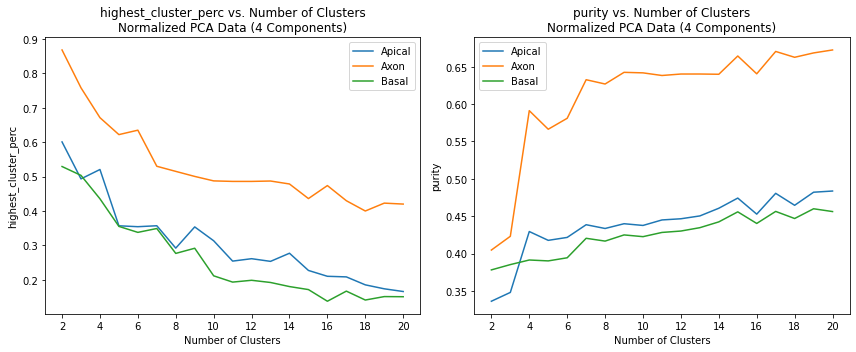

In [36]:
gmm = reload(gmm)
gmm.gmm_pipeline(df_col_filtered,
                 labeled_data_indices = labeled_data_indices,
                 title_suffix = "Normalized PCA Data (4 Components)",
                 columns_picked = None,
                 possible_K = possible_K,
                 apply_normalization=True,
                 apply_pca=True,
                 n_components_pca=4
                 
                )

# Part 6: Apply Variational Inference To Gaussian Mixture Model

# -------- Part 0: Preprocessing (Column restriction, Normalization, PCA) ----------- #
Applying Normalization
Applying pca with 4 components
n_components = 4
whiten = True
---- Using sklearn method ----


<Figure size 432x288 with 0 Axes>

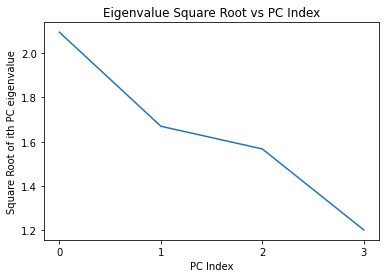

Explained Variance = [0.24358275 0.39851786 0.53504943 0.61538891]


<Figure size 432x288 with 0 Axes>

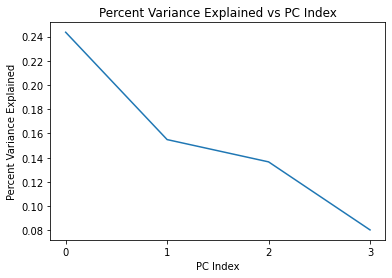

# -------- Part 1: GMM clustering with different Number of Clusters ----------- # 


------Working on clusters K=2-----
Using variational model
reversing the pca transformation
reversing the normalizing transformation
Total time for GMM = 17.360783100128174


------Working on clusters K=3-----
Using variational model
reversing the pca transformation
reversing the normalizing transformation
Total time for GMM = 27.39668893814087


------Working on clusters K=4-----
Using variational model
reversing the pca transformation
reversing the normalizing transformation
Total time for GMM = 35.05250835418701


------Working on clusters K=5-----
Using variational model
reversing the pca transformation
reversing the normalizing transformation
Total time for GMM = 42.04206204414368


------Working on clusters K=6-----
Using variational model
reversing the pca transformation
reversing the normalizing transformation
Total time for GMM = 49.794074296951294


------Working on clusters K=7-----
Using va

,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,388.526380,363.757672,14.403116,1.313633e+09,5.409765e+07,42377.337352,28800.345966,39.996119,79.571508,297.950621,253.543769,31.292867,2.054839e+09,3.698969e+07,34965.860309,53213.170981,41.385630,75.225399
1,446.662222,436.557439,3.553590,-1.051760e+07,3.098051e+07,1658.450205,14495.265587,40.191165,85.788417,331.759865,313.898616,6.601727,4.197705e+08,3.467597e+07,20130.974796,20131.066243,44.176603,82.654941




Clustering Numbers By Neuroscience Category for K = 2


,classification,category,n_clusters,cl_0,cl_1
2,hard,Apical,2,3262,4738
0,hard,Axon,2,1116,6884
1,hard,Basal,2,4338,3662




Clustering Advanced Statistics By Neuroscience Category for K = 2


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,2,1,0.59225,2,0.336198
0,Axon,hard,2,1,0.86050,1,0.405436
1,Basal,hard,2,0,0.54225,2,0.379556




----Working on Advanced Statistics for n_clusters = 3----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,415.249644,393.293809,11.190989,1.038022e+09,5.753842e+07,38885.595828,22780.225429,38.998477,79.043126,344.649527,287.873165,41.425109,2.750064e+09,4.616864e+07,44413.904262,66607.711601,35.686274,70.049458
1,493.453264,482.434316,3.214577,2.392519e+07,3.662511e+07,5945.890680,12435.246111,37.366116,83.394345,385.681918,360.261582,10.016235,6.774858e+08,4.383639e+07,27429.145174,22764.812165,38.967911,79.299516
2,266.044847,243.257139,16.941909,1.270509e+09,2.900730e+07,25976.975801,38489.550544,47.575052,87.457241,119.003917,119.840771,-1.008329,-1.903456e+08,1.826986e+06,-941.765947,14246.718640,62.676946,93.339863




Clustering Numbers By Neuroscience Category for K = 3


,classification,category,n_clusters,cl_0,cl_1,cl_2
2,hard,Apical,3,2599,4830,571
0,hard,Axon,3,629,2123,5248
1,hard,Basal,3,3117,3520,1363




Clustering Advanced Statistics By Neuroscience Category for K = 3


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,3,1,0.60375,2,0.417189
0,Axon,hard,3,2,0.65600,2,0.540938
1,Basal,hard,3,1,0.44000,2,0.371623




----Working on Advanced Statistics for n_clusters = 4----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,501.368943,489.871118,3.378785,6.043101e+07,3.816448e+07,7704.397684,12344.552649,36.976468,82.978871,395.120875,367.698769,11.240798,7.643095e+08,4.553412e+07,29089.124806,24057.600830,38.047998,78.619330
1,414.493143,392.292974,11.342660,1.063575e+09,5.818210e+07,39873.409547,22926.581507,39.225539,79.152743,344.786772,286.870464,42.560046,2.825359e+09,4.634696e+07,45047.679686,68184.255210,35.640494,69.850459
2,197.897935,195.104475,2.584389,-4.316016e+08,5.408135e+06,-23731.560454,20320.180367,54.511966,97.316153,73.242741,79.901109,2.947503,2.596185e+07,-6.052640e+06,-7996.719226,26304.178088,66.010383,93.772684
3,296.087078,266.390572,21.726654,1.838698e+09,3.792891e+07,42946.173679,44282.368505,43.957335,82.854502,144.104821,141.977180,-2.304376,-2.540251e+08,6.456052e+06,2734.100785,9772.130800,60.052145,92.120544




Clustering Numbers By Neuroscience Category for K = 4


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3
2,hard,Apical,4,4921,2459,29,591
0,hard,Axon,4,1816,571,4164,1449
1,hard,Basal,4,3640,2920,142,1298




Clustering Advanced Statistics By Neuroscience Category for K = 4


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,4,0,0.615125,2,0.431841
0,Axon,hard,4,2,0.520500,3,0.625168
1,Basal,hard,4,0,0.455000,2,0.402402




----Working on Advanced Statistics for n_clusters = 5----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,590.180409,544.624243,28.427230,3.245118e+09,7.847041e+07,103673.021228,44499.857087,43.116975,84.279796,426.205219,379.740009,21.448618,1.471319e+09,4.668417e+07,40182.195006,30665.522560,46.241024,87.078944
1,286.778365,257.541337,21.494622,1.796054e+09,3.709824e+07,41302.211228,44171.016426,43.874805,82.627722,136.694157,135.026159,-2.240841,-2.535273e+08,5.659539e+06,2202.912385,10202.789693,60.130165,91.873739
2,410.053555,389.966616,9.746882,8.745831e+08,5.603462e+07,34519.118228,20791.361044,39.402265,79.643861,344.027893,286.287775,43.024207,2.854104e+09,4.636825e+07,44863.445698,69342.930567,35.323176,69.401889
3,479.548624,466.903498,4.218030,1.288820e+08,4.089779e+07,9605.610635,13537.586963,34.763932,79.511245,386.188742,354.341902,15.263712,1.031653e+09,4.694050e+07,32007.066001,29654.021848,35.457638,75.153367
4,425.165340,419.618282,0.953404,-3.367623e+08,2.119921e+07,-9960.409915,12198.781113,45.484833,92.389332,296.158637,288.282301,1.341685,4.175778e+07,2.579050e+07,11397.384819,15249.347670,50.864515,88.413428




Clustering Numbers By Neuroscience Category for K = 5


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4
2,hard,Apical,5,321,546,2377,2750,2006
0,hard,Axon,5,115,1572,590,887,4836
1,hard,Basal,5,138,1287,2916,2540,1119




Clustering Advanced Statistics By Neuroscience Category for K = 5


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,5,3,0.34375,3,0.369656
0,Axon,hard,5,4,0.60450,2,0.484127
1,Basal,hard,5,2,0.36450,3,0.395842




----Working on Advanced Statistics for n_clusters = 6----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,771.438658,728.413817,24.185408,3.113554e+09,8.271332e+07,109672.318158,34628.929059,49.771141,96.457265,577.150163,523.114357,22.847032,1.624064e+09,6.103711e+07,48601.029999,28708.880525,46.395594,93.202158
1,517.156489,508.818066,1.094903,-2.120016e+08,3.265267e+07,-787.565748,9387.086953,37.811604,85.330592,401.794735,381.234033,5.037666,3.517885e+08,4.421267e+07,24974.150793,15757.253865,39.638328,81.291274
2,294.403727,265.096140,21.442396,1.802918e+09,3.750750e+07,41883.323262,43920.419344,43.925001,82.853432,143.331504,141.273517,-2.238009,-2.502016e+08,6.419939e+06,2671.197720,9974.119283,59.960288,91.981869
3,443.902667,428.865063,5.982703,3.862000e+08,4.698983e+07,18797.719390,15822.086028,37.397446,80.176888,365.290104,320.939710,29.122525,1.940129e+09,4.653021e+07,38090.299045,49775.488618,35.439003,72.311078
4,406.990128,378.626633,16.056023,1.611425e+09,6.536835e+07,55452.147135,29370.828541,38.513591,76.752826,335.340490,273.569498,45.170336,2.999685e+09,4.612056e+07,47219.269795,70821.099167,35.748677,69.303740
5,197.100323,194.336419,2.585497,-4.305150e+08,5.278555e+06,-23729.753832,20352.427401,54.744820,97.557493,71.997785,78.759576,2.989638,2.778061e+07,-6.336338e+06,-8166.148725,26431.028476,66.253245,93.952531




Clustering Numbers By Neuroscience Category for K = 6


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5
2,hard,Apical,6,193,3148,585,3034,1014,26
0,hard,Axon,6,46,1236,1508,824,251,4135
1,hard,Basal,6,40,1962,1306,3219,1333,140




Clustering Advanced Statistics By Neuroscience Category for K = 6


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,6,1,0.393500,3,0.436553
0,Axon,hard,6,5,0.516875,3,0.626619
1,Basal,hard,6,3,0.402375,3,0.408351




----Working on Advanced Statistics for n_clusters = 7----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,197.326377,194.671028,2.494071,-4.424789e+08,5.189433e+06,-24075.040763,20218.881619,54.613051,97.445095,72.580071,79.384174,2.904278,2.251868e+07,-6.201994e+06,-8135.841497,26302.916629,66.113203,93.849743
1,477.896459,464.201437,5.486026,2.930540e+08,3.911033e+07,13335.340167,15848.402046,38.988909,84.101455,367.380168,340.291217,12.513830,8.340133e+08,4.119321e+07,27337.768517,26482.564634,40.942766,80.167067
2,902.277883,862.038014,20.154616,2.965171e+09,8.699805e+07,114316.546274,25753.612342,56.775142,107.460986,691.621405,626.221905,30.317686,2.162187e+09,7.250839e+07,57863.883167,36696.980076,46.497980,96.886754
3,527.458832,519.363452,0.744076,-2.668450e+08,3.265699e+07,-2376.358116,8700.534072,35.766635,83.505394,413.686944,394.023175,2.934331,2.207455e+08,4.635747e+07,25407.911064,12252.761821,37.833714,80.314438
4,401.616122,387.129237,5.441434,3.732433e+08,5.072753e+07,20621.886581,14904.920342,39.856893,80.979397,345.822011,287.835874,44.744323,2.964684e+09,4.702574e+07,44949.883790,72983.008900,34.210319,68.032722
5,441.342544,406.612474,21.291835,2.142825e+09,6.647920e+07,67177.570261,37085.880453,35.398510,73.948472,338.580668,291.365542,27.874925,1.861217e+09,4.337039e+07,39384.476233,44458.216084,38.428022,74.684408
6,292.121735,261.420438,22.583138,1.930268e+09,3.860086e+07,45208.545276,45589.790747,43.960811,82.575224,138.634168,136.859826,-2.600813,-2.756468e+08,5.671121e+06,2319.028020,9315.085209,60.505060,92.400200




Clustering Numbers By Neuroscience Category for K = 7


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6
2,hard,Apical,7,25,2119,114,2382,2100,732,528
0,hard,Axon,7,4069,1059,31,737,532,175,1397
1,hard,Basal,7,138,1556,23,1553,2658,863,1209




Clustering Advanced Statistics By Neuroscience Category for K = 7


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,7,3,0.297750,3,0.433222
0,Axon,hard,7,0,0.508625,3,0.620585
1,Basal,hard,7,4,0.332250,4,0.407251




----Working on Advanced Statistics for n_clusters = 8----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,459.835371,443.206902,7.918438,5.819224e+08,4.230859e+07,21449.746467,19436.618887,40.398144,84.388705,348.762052,318.801350,16.107436,1.063736e+09,3.894217e+07,28016.625466,31697.962731,42.490566,80.449455
1,919.964125,876.061214,22.425856,3.254947e+09,9.364437e+07,124059.615337,28071.724446,54.211015,104.123339,713.805022,642.623616,33.150386,2.367579e+09,7.741797e+07,62850.117926,38986.685280,43.279936,94.307876
2,425.225688,388.165415,23.226188,2.357544e+09,6.897181e+07,72940.634114,39975.022991,35.584810,73.144110,323.721944,274.611622,30.082124,2.002114e+09,4.198524e+07,39932.163824,47605.982363,38.962030,74.318593
3,496.835338,486.111947,2.671090,-6.710344e+07,3.796891e+07,3619.795356,11325.647865,33.388570,79.131338,400.231762,372.763841,10.173165,7.009169e+08,4.815902e+07,30242.407110,22243.666148,34.675277,75.667578
4,291.046851,260.221870,22.698128,1.941705e+09,3.864886e+07,45459.086435,45779.299594,43.969716,82.536595,137.394161,135.707878,-2.646777,-2.792216e+08,5.498644e+06,2217.831273,9264.934122,60.590687,92.441898
5,539.649269,532.634855,0.191834,-2.986312e+08,2.907510e+07,-3621.559050,8220.815022,39.864124,88.780545,409.409299,395.007910,-0.645916,-2.640813e+07,4.229429e+07,21002.603278,7866.044437,42.527255,85.232519
6,196.882535,194.301270,2.481239,-4.388343e+08,4.891780e+06,-23979.924438,20249.586935,55.257471,98.158256,70.612635,77.679104,2.957335,2.403969e+07,-6.828273e+06,-8535.545170,26512.513530,66.752423,94.385521
7,398.949440,384.397673,5.438081,3.828659e+08,5.145676e+07,21290.259399,14815.792539,40.115408,81.063116,345.658311,285.809649,46.675642,3.092583e+09,4.737849e+07,45999.823778,75744.765459,33.963116,67.505401




Clustering Numbers By Neuroscience Category for K = 8


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7
2,hard,Apical,8,1389,98,558,1782,517,1702,22,1932
0,hard,Axon,8,796,17,147,531,1369,678,3985,477
1,hard,Basal,8,979,20,733,1637,1199,834,125,2473




Clustering Advanced Statistics By Neuroscience Category for K = 8


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,8,7,0.241500,4,0.431751
0,Axon,hard,8,6,0.498125,4,0.616147
1,Basal,hard,8,7,0.309125,5,0.412106




----Working on Advanced Statistics for n_clusters = 9----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,398.260621,383.151719,5.875684,4.388879e+08,5.208161e+07,22952.974882,15418.998887,40.459672,81.280555,344.095727,283.792124,47.175201,3.124877e+09,4.708752e+07,46127.317999,76415.221716,34.308119,67.716848
1,282.389654,267.744598,10.253123,4.899120e+08,2.221870e+07,4852.164015,28733.334009,45.048691,86.786578,150.787541,152.038676,-1.871732,-2.341945e+08,7.358683e+06,632.641962,13517.440981,57.971263,90.015468
2,886.779451,811.989860,45.356162,6.013421e+09,1.350959e+08,206128.102063,58324.630491,51.681397,92.562670,686.906382,583.264059,58.507462,4.065074e+09,8.149953e+07,82147.242116,69078.809585,40.873116,87.744923
3,298.297090,257.691807,30.138093,2.812393e+09,4.903858e+07,70047.892210,55852.479137,42.904063,79.528966,132.992335,128.723294,-2.637823,-2.722980e+08,5.212195e+06,3907.880567,7217.237653,61.537743,93.368631
4,436.308912,400.293554,22.356174,2.254012e+09,6.752758e+07,69941.955281,38679.133878,35.035727,73.178301,332.815266,285.751670,27.621091,1.843056e+09,4.278188e+07,39176.369131,43981.077596,38.590875,74.666936
5,196.622588,194.368815,2.208005,-4.678237e+08,4.742911e+06,-24673.952754,19841.858010,55.311410,98.249687,71.405478,78.074772,3.409271,5.413909e+07,-6.626715e+06,-8281.244407,27204.812923,66.597202,94.194652
6,521.471251,513.705611,0.654290,-2.853150e+08,3.151558e+07,-3372.800456,8818.468897,36.451343,84.225831,405.882187,387.591208,2.290368,1.729222e+08,4.482361e+07,24111.060189,11723.595741,38.846987,81.072088
7,613.856263,599.487530,4.662304,5.578787e+08,4.331139e+07,28788.729569,11997.260513,52.107362,101.499643,459.461869,426.600624,16.520155,1.124000e+09,4.498226e+07,30806.252373,30032.812591,49.036683,91.320394
8,476.149004,462.789574,4.794497,1.859170e+08,4.159516e+07,11001.320860,14389.840810,34.266339,78.736168,383.380085,351.427180,15.206331,1.027775e+09,4.687194e+07,32098.182268,29470.744252,35.237593,74.843741




Clustering Numbers By Neuroscience Category for K = 9


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8
2,hard,Apical,9,1962,328,28,287,648,17,2239,617,1874
0,hard,Axon,9,480,1537,6,212,160,3884,810,331,580
1,hard,Basal,9,2383,710,12,655,811,112,1335,127,1855




Clustering Advanced Statistics By Neuroscience Category for K = 9


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,9,6,0.279875,4,0.437511
0,Axon,hard,9,5,0.485500,4,0.638689
1,Basal,hard,9,0,0.297875,5,0.422135




----Working on Advanced Statistics for n_clusters = 10----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,591.332939,582.955057,1.034026,4.850365e+07,3.091593e+07,10586.184190,8515.634204,54.013238,104.956084,426.110124,407.652163,6.114323,4.094578e+08,3.714293e+07,20373.719198,17786.197089,53.582219,95.792346
1,461.021774,446.893476,5.843657,2.387649e+08,3.957679e+07,10177.343746,16592.460331,33.070948,77.241955,363.324410,337.454023,9.736214,6.571163e+08,4.366749e+07,27999.528101,22089.066508,36.388446,75.950599
2,526.959348,519.373612,0.476712,-3.086273e+08,3.118320e+07,-4086.846473,8518.782510,36.011460,83.989375,410.328988,392.942627,1.049015,9.312263e+07,4.529652e+07,23844.881344,9811.338574,38.576660,81.167102
3,887.914214,823.875756,37.416096,5.040344e+09,1.209268e+08,176947.486566,47959.997335,51.748137,95.370440,690.680301,597.426706,50.684949,3.539526e+09,8.020632e+07,75984.817041,60153.697816,40.884768,88.844670
4,197.226853,194.529287,2.501864,-4.470237e+08,5.353997e+06,-24242.947302,20208.338505,54.089712,96.863799,73.658156,80.366888,2.778005,1.549527e+07,-5.778028e+06,-7901.527993,26035.515584,65.630459,93.440543
5,421.601857,414.086815,0.385828,-2.187209e+08,3.983547e+07,2710.066364,8342.023574,42.314751,86.181327,353.008737,305.997581,35.838560,2.367626e+09,4.415223e+07,37942.073088,61776.684972,37.300556,72.514984
6,395.941024,378.749454,7.380472,6.024655e+08,5.498325e+07,27619.114151,17383.212459,38.879875,78.996325,344.711490,282.528615,48.034576,3.186203e+09,4.831026e+07,47700.092268,77038.109479,32.974894,66.351024
7,482.816545,458.017752,13.347812,1.262958e+09,5.570131e+07,43362.607936,25625.998989,36.791979,78.868149,377.939140,336.668661,22.610269,1.521105e+09,4.617305e+07,36876.500816,37916.977183,37.927693,76.394315
8,413.533526,370.163373,28.180902,2.934417e+09,7.572804e+07,89091.735617,46924.257326,35.836185,71.682582,307.535934,255.279941,32.607516,2.166166e+09,4.031048e+07,41174.782463,50393.344602,40.246616,74.661055
9,291.320401,260.494218,22.722666,1.948567e+09,3.850982e+07,45662.328868,45835.347983,44.390038,83.008088,136.478581,134.973528,-2.656352,-2.809559e+08,5.119618e+06,1964.747403,9315.739819,61.015554,92.821605




Clustering Numbers By Neuroscience Category for K = 10


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9
2,hard,Apical,10,655,1512,1802,41,25,1088,1245,767,343,522
0,hard,Axon,10,475,651,588,7,4068,304,315,172,85,1335
1,hard,Basal,10,120,1585,1112,14,138,1144,1657,607,447,1176




Clustering Advanced Statistics By Neuroscience Category for K = 10


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,10,2,0.225250,5,0.432638
0,Axon,hard,10,4,0.508500,4,0.623333
1,Basal,hard,10,6,0.207125,5,0.416845




----Working on Advanced Statistics for n_clusters = 11----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,422.948858,415.994728,-0.112570,-2.515579e+08,3.987852e+07,2444.853097,7518.487668,43.480560,87.484004,355.102678,306.372779,37.914735,2.504368e+09,4.426808e+07,38750.817381,64878.722922,37.666423,72.648412
1,418.535866,392.458946,14.317506,1.432411e+09,6.225787e+07,50605.493504,26945.133680,40.297067,79.579143,341.509850,282.137711,43.508894,2.887837e+09,4.536607e+07,45531.040809,68890.766072,37.209824,71.186859
2,912.419154,834.585384,47.059583,6.297720e+09,1.418036e+08,217012.645201,59608.914496,52.349186,92.912911,713.303303,601.548607,64.507834,4.477459e+09,8.577516e+07,87849.787977,76134.062962,39.571957,86.746444
3,464.139118,446.544767,8.141102,5.397067e+08,4.589914e+07,20216.919612,19189.581389,32.317536,75.424782,371.832004,338.925684,15.180319,1.026527e+09,4.652893e+07,32761.721700,28742.446471,34.605506,73.831426
4,540.462086,533.641379,0.078576,-3.326388e+08,2.834839e+07,-5104.611793,8152.018831,38.809189,87.807354,410.030708,397.415729,-2.720195,-1.624242e+08,4.246750e+07,20223.426225,4848.736871,42.032411,85.070389
5,615.458850,603.183270,3.536589,4.232965e+08,3.761512e+07,23605.368894,11090.139629,55.464164,106.031122,446.061452,420.969863,11.007938,7.445766e+08,3.980275e+07,24742.212072,23359.530821,53.676292,96.070615
6,289.917351,260.950497,21.291934,1.780157e+09,3.663882e+07,40931.722369,43878.621931,44.414985,83.376971,137.923686,136.731087,-2.564825,-2.755068e+08,5.385641e+06,1820.120792,9803.016376,60.625096,92.450953
7,383.089446,368.633323,5.416104,3.505820e+08,5.180381e+07,19978.123341,14941.457794,38.628674,78.962845,337.817298,276.588168,48.114219,3.186712e+09,4.778905e+07,46930.158821,77954.281908,32.458073,65.498324
8,447.945680,399.672417,32.012644,3.359176e+09,7.781752e+07,99709.818716,52236.953829,34.471781,70.686198,318.611962,274.674633,21.980864,1.470823e+09,3.931530e+07,36932.664073,33721.970833,42.271780,78.731015
9,498.605211,489.215795,1.953228,-1.557966e+08,3.425879e+07,162.795151,10750.677295,35.341263,81.856644,392.251580,370.045857,6.263847,4.333309e+08,4.493286e+07,26259.961049,17392.667363,37.543039,78.688171




Clustering Numbers By Neuroscience Category for K = 11


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10
2,hard,Apical,11,923,826,23,1261,1119,494,527,733,321,1751,22
0,hard,Axon,11,223,163,5,387,405,358,1417,235,75,681,4051
1,hard,Basal,11,933,819,9,1456,539,103,1211,1192,334,1279,125




Clustering Advanced Statistics By Neuroscience Category for K = 11


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,11,9,0.218875,6,0.435056
0,Axon,hard,11,10,0.506375,4,0.625632
1,Basal,hard,11,3,0.182000,6,0.418347




----Working on Advanced Statistics for n_clusters = 12----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,416.097251,392.234901,12.457113,1.236122e+09,6.139997e+07,45977.938563,24152.718560,40.650805,80.143883,346.896516,284.447281,46.952278,3.117142e+09,4.684721e+07,47490.524349,74121.851745,36.047823,69.731090
1,283.087713,268.045666,10.563462,5.266106e+08,2.255840e+07,5865.207622,29163.048273,45.088136,86.775760,150.500484,151.833295,-2.028417,-2.445316e+08,7.237757e+06,563.113079,13221.088699,58.131351,90.190482
2,471.971119,451.398083,10.165892,8.229961e+08,5.081916e+07,29670.451578,21509.602006,33.209762,75.719041,378.868948,340.826609,19.399872,1.310935e+09,4.785007e+07,35892.549015,33941.035494,34.633557,73.593267
3,196.808558,194.536343,2.220572,-4.670515e+08,4.753120e+06,-24665.563448,19858.006261,55.254407,98.192611,71.575217,78.294493,3.328453,4.895209e+07,-6.593619e+06,-8290.173793,27075.469810,66.562882,94.180091
4,429.097675,383.381017,30.263427,3.132932e+09,7.471836e+07,92714.302614,50201.581488,34.802791,71.059264,305.816961,262.440763,22.913834,1.524428e+09,3.794850e+07,36028.983965,36058.331807,42.308900,78.057267
5,296.085356,254.570385,30.898128,2.897739e+09,4.970070e+07,72262.353554,56983.996508,43.064789,79.477322,129.007387,124.948125,-2.807194,-2.850799e+08,4.545101e+06,3593.197470,6924.901339,62.034992,93.732762
6,654.101214,643.282995,2.118410,2.959895e+08,3.581366e+07,20794.702703,8610.183060,55.808476,107.934845,474.963144,453.148259,6.530175,4.592662e+08,4.185934e+07,23744.646278,16364.706927,53.904742,98.106954
7,383.269017,370.550587,4.120121,2.023117e+08,4.971146e+07,15757.869928,13211.585601,39.214939,79.996012,338.238855,277.983979,47.730004,3.159259e+09,4.743810e+07,46201.937932,77817.686147,32.771123,65.845537
8,492.585977,480.629799,3.732970,4.420281e+07,3.864912e+07,6277.327136,12962.818875,33.322154,78.753372,393.585170,366.960209,9.375523,6.456954e+08,4.712749e+07,29507.042307,21057.245715,35.276479,76.120806
9,529.707536,522.214332,0.447994,-3.095934e+08,3.062410e+07,-4237.382166,8525.056936,36.464664,84.637126,410.200245,393.927259,0.094011,2.882186e+07,4.473103e+07,23049.955390,8513.003883,39.235018,81.943062




Clustering Numbers By Neuroscience Category for K = 12


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11
2,hard,Apical,12,835,324,892,17,280,267,468,897,1445,1738,802,35
0,hard,Axon,12,162,1539,223,3853,78,198,298,279,445,604,313,8
1,hard,Basal,12,829,718,895,111,376,613,85,1437,1335,981,607,13




Clustering Advanced Statistics By Neuroscience Category for K = 12


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,12,9,0.217250,6,0.438566
0,Axon,hard,12,3,0.481625,4,0.636741
1,Basal,hard,12,7,0.179625,7,0.422110




----Working on Advanced Statistics for n_clusters = 13----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,916.333660,850.128297,38.549363,5.213401e+09,1.253220e+08,183475.904544,48682.963889,50.371804,94.032429,718.477927,621.708147,51.648126,3.620461e+09,8.457937e+07,79499.555706,60015.593914,38.792356,87.842334
1,392.256719,373.810385,8.310252,7.073501e+08,5.677051e+07,30665.263387,18625.693314,38.326311,77.964408,342.924800,279.219611,49.180768,3.263255e+09,4.871143e+07,48698.910334,78412.357069,32.451761,65.622478
2,296.216303,254.140867,31.343046,2.948984e+09,5.017930e+07,73648.939990,57613.106212,43.083931,79.397285,128.021394,124.043702,-2.971408,-2.961062e+08,4.343954e+06,3503.410682,6604.056165,62.232149,93.919400
3,494.502009,479.667090,5.697366,3.056887e+08,4.361138e+07,14901.412236,15261.836087,33.411501,78.018668,398.080885,365.973080,13.887300,9.495041e+08,4.873989e+07,32962.487967,26713.080426,34.551310,74.996156
4,413.334687,406.247132,0.004453,-2.708987e+08,4.024955e+07,1402.710976,7781.058112,41.497131,85.033582,351.610227,302.514929,37.885123,2.503948e+09,4.509417e+07,39360.261261,64763.046740,35.975717,70.855672
5,411.257462,367.735463,28.377727,2.955713e+09,7.547791e+07,89488.048740,47306.190794,36.291116,72.117742,303.572169,251.926163,32.315639,2.144267e+09,3.945900e+07,40541.299702,50114.134986,40.910014,75.192390
6,197.245931,194.971630,2.220243,-4.681439e+08,4.726795e+06,-24721.066407,19856.312183,55.172957,98.123702,71.920859,78.766444,3.158318,3.794091e+07,-6.548160e+06,-8332.262354,26814.667978,66.520146,94.177169
7,484.483057,457.660557,15.051998,1.411135e+09,5.616321e+07,46083.764096,28252.755738,34.489358,76.291247,374.473214,337.549433,17.280595,1.170306e+09,4.564024e+07,34731.332259,29819.602976,37.670722,76.809415
8,473.503486,463.392919,2.555555,-1.583099e+08,3.569117e+07,-970.784689,11829.726685,31.057037,76.312796,381.585319,357.771725,7.088236,4.902657e+08,4.657205e+07,27955.131467,18417.746392,33.845575,74.521956
9,523.265296,516.227256,0.327970,-3.297314e+08,2.894469e+07,-5412.673126,8685.223941,37.745324,86.056452,399.912649,385.755522,-0.948984,-4.772781e+07,4.241601e+07,21056.918443,7574.248442,40.969040,83.359601




Clustering Numbers By Neuroscience Category for K = 13


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12
2,hard,Apical,13,37,983,261,1289,835,336,17,568,597,1514,632,327,604
0,hard,Axon,13,6,257,189,297,235,82,3787,154,238,625,132,1510,488
1,hard,Basal,13,14,1491,599,1116,1005,401,107,525,808,801,289,728,116




Clustering Advanced Statistics By Neuroscience Category for K = 13


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,13,9,0.189250,7,0.438743
0,Axon,hard,13,6,0.473375,4,0.635281
1,Basal,hard,13,1,0.186375,7,0.430020




----Working on Advanced Statistics for n_clusters = 14----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,587.201029,579.723965,0.330797,-3.894668e+07,3.027274e+07,8134.424902,7556.390124,53.662798,104.608783,425.708506,406.714359,6.808044,4.552951e+08,3.755126e+07,20772.266245,18954.020766,52.924339,95.014342
1,404.091438,361.046994,27.968933,2.898375e+09,7.566452e+07,87944.088186,46723.979503,35.429003,70.992293,302.513402,249.300517,33.824859,2.245080e+09,4.032204e+07,41671.616541,52331.456777,39.663457,73.700628
2,479.825569,465.686584,5.484440,2.215985e+08,4.106218e+07,10791.210891,15535.944047,32.005888,76.487675,383.910819,356.064847,10.219475,7.007396e+08,4.694231e+07,30232.624227,22001.239158,34.565024,74.943798
3,1314.407319,1188.160086,79.775634,1.071930e+10,2.020819e+08,357200.177662,96608.308662,54.844190,96.261238,981.231564,854.194284,52.509271,3.837499e+09,1.107493e+08,106431.669940,39817.627820,44.647260,105.398631
4,507.429104,487.259551,9.310364,8.792518e+08,5.330440e+07,35101.683596,19248.791118,39.216019,82.826962,406.569776,361.394808,26.750596,1.802891e+09,4.942614e+07,39651.558519,44056.367250,37.265081,76.239710
5,294.468248,252.269690,31.467904,2.960016e+09,5.018658e+07,73843.123274,57833.945122,43.068168,79.317649,126.182753,122.359082,-3.055676,-3.024736e+08,4.104790e+06,3346.681433,6517.469987,62.325390,93.949416
6,407.224068,399.235718,0.598921,-1.536219e+08,4.281199e+07,6043.933875,8383.656107,43.792365,86.847459,348.113730,293.577361,43.954797,2.902630e+09,4.487376e+07,41914.423035,73511.439270,36.806892,70.663142
7,523.559658,516.389959,0.510020,-3.065468e+08,2.852514e+07,-4946.199965,9035.949682,38.431658,86.840204,397.016233,383.889004,-1.652197,-9.682979e+07,4.143154e+07,20149.217527,6697.034097,41.914555,84.270381
8,282.215059,267.173604,10.572062,5.263725e+08,2.254362e+07,5827.336823,29190.749848,45.075034,86.737160,149.826338,151.146544,-1.980385,-2.416413e+08,7.178800e+06,549.148190,13311.025353,58.129737,90.154147
9,197.521031,195.286917,2.190101,-4.702831e+08,4.674272e+06,-24761.436579,19812.748088,55.267938,98.242453,71.994232,78.855455,3.175767,3.895819e+07,-6.592967e+06,-8363.863115,26853.490437,66.593973,94.249210




Clustering Numbers By Neuroscience Category for K = 14


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13
2,hard,Apical,14,632,294,1213,5,883,257,907,1461,317,17,657,1054,141,162
0,hard,Axon,14,514,71,413,1,136,195,234,566,1478,3776,233,268,15,100
1,hard,Basal,14,115,414,1287,1,368,598,973,698,704,108,848,1434,31,421




Clustering Advanced Statistics By Neuroscience Category for K = 14


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,14,7,0.182625,7,0.446295
0,Axon,hard,14,9,0.472000,5,0.633748
1,Basal,hard,14,11,0.179250,7,0.436244




----Working on Advanced Statistics for n_clusters = 15----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,460.234183,446.976386,4.810433,1.557588e+08,4.162192e+07,9589.677505,14627.704154,32.935417,76.844115,374.189243,341.541449,16.082132,1.083613e+09,4.686517e+07,32524.224072,30938.109871,34.069893,73.192755
1,388.319825,365.021993,13.599996,9.527251e+08,4.748623e+07,26029.747216,28659.145094,25.464359,65.257078,304.006458,278.028647,8.742568,5.810822e+08,4.070403e+07,27868.874443,20047.652150,33.299658,70.795726
2,407.783935,363.391133,29.000640,3.028779e+09,7.696752e+07,91746.417943,48104.592147,35.933209,71.365981,302.472919,249.110149,33.771665,2.241663e+09,3.992203e+07,41631.102226,52005.666601,40.393815,74.446946
3,531.852292,524.825407,0.255572,-3.387643e+08,2.876300e+07,-5682.968314,8487.846641,37.242220,85.816454,406.453449,393.419531,-2.591899,-1.529965e+08,4.306003e+07,20753.325058,4978.739081,40.703653,83.607063
4,773.062091,745.683192,10.991289,1.771619e+09,7.620679e+07,78997.890689,14629.797879,55.099087,104.076068,623.362988,548.630042,46.461822,3.196179e+09,7.048395e+07,61379.107011,64609.542228,40.720139,85.837955
5,390.690672,374.334700,6.634269,5.385708e+08,5.543119e+07,26672.726130,16188.698409,39.680069,79.670954,345.193224,279.480012,51.985491,3.447142e+09,4.900086e+07,49636.860221,82892.623971,32.516183,65.333927
6,469.388954,459.776313,2.736658,-1.266562e+08,3.167101e+07,-1306.546970,12801.755517,35.758590,81.746253,360.009138,342.564819,3.420204,2.284738e+08,4.000401e+07,22084.073207,14405.937347,39.826008,80.010753
7,695.500531,513.449030,132.622351,1.567564e+10,2.231711e+08,458341.801034,185573.524088,45.826905,61.029329,340.312545,251.664998,34.124037,2.362592e+09,3.210688e+07,61969.469357,22198.542296,73.358751,110.798217
8,591.047076,572.347479,7.380295,6.906059e+08,5.177481e+07,30962.618387,15330.799230,35.825274,82.137602,475.381023,436.988234,15.398046,1.085657e+09,5.671144e+07,38994.936674,25642.397279,34.442652,77.928997
9,428.476454,421.360347,-0.021107,-2.589468e+08,3.969882e+07,1852.618847,7626.228211,42.080225,86.191185,359.902911,312.849995,35.518422,2.349736e+09,4.505488e+07,38283.420209,61158.350571,36.855849,72.402617




Clustering Numbers By Neuroscience Category for K = 15


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14
2,hard,Apical,15,885,45,283,1127,126,1065,1117,10,669,937,22,664,299,461,290
0,hard,Axon,15,304,95,72,406,19,286,575,2,50,228,3906,165,246,491,1155
1,hard,Basal,15,1262,200,377,604,24,1461,843,1,152,950,125,605,694,99,603




Clustering Advanced Statistics By Neuroscience Category for K = 15


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,15,3,0.140875,7,0.447301
0,Axon,hard,15,10,0.488250,5,0.631349
1,Basal,hard,15,5,0.182625,7,0.432895




----Working on Advanced Statistics for n_clusters = 16----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,1327.778557,1162.991081,108.099091,1.422234e+10,2.529395e+08,462858.878030,133294.725911,55.558095,87.730241,979.396017,815.615371,79.647147,5.665470e+09,1.159279e+08,128406.657737,70212.420476,45.324709,102.773444
1,685.178300,671.193346,3.565448,5.624875e+08,4.481686e+07,32253.298143,9050.708186,54.744305,106.293715,515.310301,481.191871,15.398093,1.071675e+09,4.969919e+07,32945.151215,26869.329004,49.786150,94.511562
2,408.499138,361.332331,31.320637,3.271210e+09,7.825491e+07,97477.751130,51583.445035,35.279031,70.333781,295.045107,244.974802,30.000634,1.990470e+09,3.827061e+07,39545.518429,46230.549446,41.534886,75.855958
3,428.478867,406.444974,11.228462,1.045445e+09,5.687718e+07,38943.487585,22771.554306,39.004485,79.545082,351.776689,297.534024,38.457159,2.556283e+09,4.618585e+07,43148.383543,62128.372715,36.236533,71.313348
4,521.268589,514.445748,0.368590,-3.354513e+08,2.732483e+07,-6296.153849,9034.721463,38.558950,87.095725,392.666564,381.460215,-3.198589,-2.021064e+08,4.041377e+07,18795.470282,4726.337474,42.523597,84.904992
5,469.258486,439.178654,17.844127,1.682218e+09,5.811067e+07,52150.719274,32592.044437,32.864918,73.619170,356.653554,321.945840,14.787935,1.000966e+09,4.369563e+07,33164.158049,26027.470293,38.022318,76.840889
6,481.787796,473.844846,0.727026,-3.202489e+08,3.447924e+07,-4231.772424,8994.754810,33.302564,79.251148,390.611744,364.542828,10.023007,6.845632e+08,4.714451e+07,29059.610810,22946.835829,34.457740,75.028035
7,498.754686,486.499641,4.215458,8.757286e+07,3.664898e+07,6430.689286,13968.580197,34.261104,80.196208,388.404139,367.195976,4.439496,3.139419e+08,4.451981e+07,25802.819527,14214.835027,37.672688,78.974122
8,197.146670,194.895382,2.211859,-4.689004e+08,4.647530e+06,-24760.954308,19856.733265,55.254662,98.219540,71.562222,78.507923,3.107931,3.427689e+07,-6.655975e+06,-8427.334990,26766.533621,66.617396,94.264485
9,378.785534,364.399596,5.264758,3.513346e+08,5.289896e+07,20717.224237,14578.168857,39.119160,79.198300,338.004458,273.552924,51.487905,3.410169e+09,4.844542e+07,48752.515399,82805.769717,32.012553,64.579853




Clustering Numbers By Neuroscience Category for K = 16


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15
2,hard,Apical,16,1,240,205,844,1013,331,659,1218,17,651,95,551,253,809,808,305
0,hard,Axon,16,1,126,50,167,416,99,236,378,3757,205,10,526,185,215,200,1429
1,hard,Basal,16,2,35,265,810,480,439,927,727,108,1026,20,115,583,944,815,704




Clustering Advanced Statistics By Neuroscience Category for K = 16


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,16,7,0.152250,8,0.437523
0,Axon,hard,16,8,0.469625,5,0.632722
1,Basal,hard,16,9,0.128250,8,0.433878




----Working on Advanced Statistics for n_clusters = 17----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,656.423843,646.515920,1.464758,2.271352e+08,3.444799e+07,18834.809457,7755.811771,56.663074,109.160457,475.079810,454.330496,5.934293,4.177505e+08,4.120547e+07,22881.354635,15779.349602,54.684259,98.944432
1,408.957906,393.051175,6.674816,4.913235e+08,5.045873e+07,22892.843859,16818.119101,39.114360,80.366380,344.600845,291.094666,39.750395,2.634394e+09,4.589262e+07,42398.851208,65546.366591,35.127594,69.630314
2,293.919900,247.922191,34.479767,3.320774e+09,5.370557e+07,83935.052821,62062.717713,44.050920,79.592361,118.097946,113.741321,-2.758228,-2.854909e+08,2.426221e+06,3118.213326,6466.717139,64.133993,95.414846
3,398.962332,391.544863,0.095813,-2.274741e+08,4.307511e+07,4009.352589,7655.678759,42.429034,85.154680,347.712785,291.360160,45.557609,3.010701e+09,4.616389e+07,43350.353603,75819.564649,35.030365,68.664248
4,477.509571,452.446322,13.793515,1.216906e+09,5.364894e+07,39570.182326,26758.158088,32.278938,74.213415,372.464580,338.179258,14.582029,9.922884e+08,4.612753e+07,33639.944916,26246.945137,36.069726,75.516991
5,586.026986,560.830542,11.449179,1.523229e+09,6.914581e+07,64095.563693,18994.844773,51.543866,95.697994,476.498237,404.172989,52.096762,3.504628e+09,5.682832e+07,55407.805344,77716.369068,40.604166,78.814292
6,408.687884,363.719933,29.774412,3.072041e+09,7.472643e+07,91113.162008,49690.073719,35.258229,70.959097,293.664507,247.235993,26.996127,1.788671e+09,3.737808e+07,37299.306641,42474.609063,41.946649,76.596469
7,465.530447,451.668430,5.191752,2.029039e+08,4.248957e+07,11082.924438,15026.393152,32.464781,76.348744,378.893096,345.998309,15.767684,1.066120e+09,4.761205e+07,32971.598355,30164.258603,33.663145,73.045133
8,239.152480,230.314131,6.432731,2.833016e+06,1.425085e+07,-10507.053085,24501.839459,47.451243,89.493493,115.722874,119.774616,-0.465463,-1.652719e+08,2.289171e+06,-2994.296290,18143.721554,59.982788,90.228136
9,463.827499,457.985763,-0.482172,-2.655931e+08,3.277791e+07,479.811646,7513.306929,48.769647,95.398089,358.290888,324.381849,24.676668,1.617099e+09,3.764734e+07,28545.316751,46597.941381,45.729337,82.571731




Clustering Numbers By Neuroscience Category for K = 17


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,cl_7,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16
2,hard,Apical,17,378,945,232,672,482,216,289,821,118,334,695,486,242,994,1074,9,13
0,hard,Axon,17,209,228,153,165,151,21,85,275,1694,303,278,118,334,369,188,3425,4
1,hard,Basal,17,65,1038,435,865,580,47,391,1019,249,128,903,725,639,450,370,89,7




Clustering Advanced Statistics By Neuroscience Category for K = 17


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,17,14,0.134250,9,0.454063
0,Axon,hard,17,15,0.428125,6,0.660451
1,Basal,hard,17,1,0.129750,9,0.444708




----Working on Advanced Statistics for n_clusters = 18----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,531.627871,517.030067,5.637252,3.478631e+08,4.042057e+07,15973.538805,15172.729801,37.349598,83.783423,409.775261,385.386436,6.659948,4.684497e+08,4.563383e+07,27710.582216,16405.569315,39.654229,81.517357
1,400.112010,370.713264,16.744726,1.697960e+09,6.775100e+07,58438.061970,30174.921730,38.088592,75.688814,334.106174,268.669782,48.524095,3.223344e+09,4.713253e+07,49497.267603,75377.579009,34.708692,67.768038
2,382.437888,367.570802,5.621711,3.933389e+08,5.324303e+07,21864.679869,15042.911243,39.011350,79.116967,339.734851,275.773517,50.741899,3.361923e+09,4.849113e+07,48549.981222,81572.949199,32.135753,64.888818
3,196.914258,194.670894,2.210187,-4.686909e+08,4.629249e+06,-24754.137626,19859.848601,55.312558,98.276571,71.278233,78.213085,3.153697,3.708597e+07,-6.713574e+06,-8446.460050,26847.582394,66.667569,94.295134
4,397.489163,390.617419,-0.258459,-2.773818e+08,4.206162e+07,2290.139023,7275.295422,42.386778,85.243281,345.826452,290.631264,44.636681,2.948293e+09,4.573217e+07,42592.378397,74686.408772,35.197093,68.872981
5,294.703029,252.263046,31.649141,2.982247e+09,5.046655e+07,74496.531262,58073.996007,43.089359,79.291942,126.124800,122.165403,-2.972829,-2.968626e+08,4.096725e+06,3421.280684,6586.713641,62.369556,93.982772
6,832.177154,804.305866,11.908470,1.727481e+09,6.725505e+07,72076.812293,16781.404879,49.189558,100.889002,642.801767,596.421427,15.139088,1.133644e+09,6.779240e+07,46542.862766,18784.036939,42.838032,93.258745
7,549.584478,544.084385,-0.460986,-1.876594e+08,2.521258e+07,1643.893394,7604.691415,55.443009,106.170676,387.289151,373.104050,5.229692,3.279063e+08,3.147005e+07,15978.743181,18562.439774,55.953588,96.588881
8,489.005760,481.129589,0.666821,-3.240841e+08,3.399532e+07,-4400.691572,8880.963413,33.434231,79.685043,394.410177,369.726953,8.470319,5.829435e+08,4.708515e+07,28330.068887,20634.908686,34.842963,75.785447
9,527.015815,520.440032,0.137221,-3.518821e+08,2.705660e+07,-6554.089596,8631.887207,38.942573,87.731703,396.609399,385.690705,-3.541833,-2.238084e+08,4.055763e+07,18667.453186,4190.876842,42.788819,85.372327




Clustering Numbers By Neuroscience Category for K = 18


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_8,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17
2,hard,Apical,18,747,322,682,16,626,254,103,...,713,874,710,327,688,616,195,297,13,399
0,hard,Axon,18,168,73,208,3772,151,188,21,...,264,371,250,127,194,137,58,1396,3,111
1,hard,Basal,18,224,464,1011,111,820,583,22,...,906,417,1055,75,286,471,267,675,4,510




Clustering Advanced Statistics By Neuroscience Category for K = 18


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,18,9,0.109250,10,0.447360
0,Axon,hard,18,3,0.471500,6,0.634663
1,Basal,hard,18,10,0.131875,9,0.442646




----Working on Advanced Statistics for n_clusters = 19----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,462.842116,439.234439,12.646909,1.095362e+09,5.346384e+07,36773.973541,25153.759703,32.983394,74.626737,366.930163,328.750496,19.378481,1.306267e+09,4.642249e+07,35597.205537,33632.546321,35.394921,73.906319
1,293.664644,252.372713,30.776044,2.879067e+09,4.924797e+07,71566.046336,56894.537272,43.152863,79.574082,126.599134,122.954223,-3.000239,-2.993502e+08,4.156993e+06,3230.594416,6785.966953,62.209507,93.828195
2,280.827818,265.059014,11.166802,5.930334e+08,2.313493e+07,7579.285992,30060.213458,45.106912,86.596923,147.281087,148.682867,-2.094005,-2.499544e+08,6.789551e+06,398.518583,13079.082540,58.409734,90.353414
3,498.064969,489.711797,1.344905,-5.363511e+07,3.372253e+07,5987.892437,9820.450381,47.729922,95.057601,376.338344,348.115560,16.993999,1.118555e+09,3.820995e+07,26060.487698,34429.883430,46.609084,85.336513
4,543.109346,536.043244,0.195915,-3.374942e+08,2.871868e+07,-5472.915555,8251.508019,37.106458,86.023744,414.647253,402.528988,-4.031288,-2.444952e+08,4.372346e+07,20540.300827,2636.723416,40.678677,84.129531
5,533.238151,512.695787,8.599143,1.146502e+09,6.245560e+07,51750.539205,16226.529441,54.299695,98.227639,432.675322,361.907202,55.056832,3.672863e+09,5.086836e+07,52115.926700,84625.604003,43.050230,78.887895
6,396.525766,384.087673,3.965648,1.939398e+08,4.816197e+07,15277.485149,13035.988177,40.255723,81.739452,342.495871,285.696672,44.391045,2.937578e+09,4.636761e+07,44002.890073,73067.742046,34.413348,68.107459
7,482.614949,467.044330,6.525348,3.404910e+08,4.276300e+07,14185.575180,16884.165099,31.319431,75.515533,385.964574,357.627686,10.027258,6.910157e+08,4.750592e+07,30786.713898,21292.873877,34.168335,74.694498
8,401.720774,382.804203,9.106419,7.325434e+08,5.288676e+07,28658.054097,20401.787782,37.061352,77.436833,336.187212,283.856849,37.698094,2.499309e+09,4.548006e+07,41919.377354,62086.096847,34.596477,69.116726
9,640.809235,634.063783,-0.241271,3.077357e+07,2.722736e+07,11735.907843,6389.626510,62.209798,115.757387,445.543597,431.960138,2.857761,1.882957e+08,3.343274e+07,16009.290510,13521.634371,61.082574,104.379059




Clustering Numbers By Neuroscience Category for K = 19


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_9,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17,cl_18
2,hard,Apical,19,603,243,300,410,843,223,711,...,213,82,1239,130,265,17,8,259,679,474
0,hard,Axon,19,156,189,1411,365,282,29,192,...,169,29,533,24,66,3761,2,53,151,175
1,hard,Basal,19,691,596,678,109,417,54,862,...,46,107,500,24,350,104,4,475,768,784




Clustering Advanced Statistics By Neuroscience Category for K = 19


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,19,11,0.154875,10,0.441269
0,Axon,hard,19,14,0.470125,6,0.631711
1,Basal,hard,19,7,0.126750,10,0.439409




----Working on Advanced Statistics for n_clusters = 20----

Recovered Means From Clustering


,n0_width_median_mesh_center,n0_width_no_spine_median_mesh_center,n0_n_spines,n0_total_spine_volume,n0_spine_volume_median,n0_spine_volume_density,n0_skeletal_length,n0_parent_angle,n0_sibling_angle,n1_width_median_mesh_center,n1_width_no_spine_median_mesh_center,n1_n_spines,n1_total_spine_volume,n1_spine_volume_median,n1_spine_volume_density,n1_skeletal_length,n1_parent_angle,n1_sibling_angle
0,402.541760,354.331083,32.440603,3.357450e+09,7.711675e+07,98283.379700,53632.394264,34.647975,69.575697,282.631795,237.460295,25.363184,1.678092e+09,3.584323e+07,36297.175036,39765.426686,42.779433,77.254082
1,529.755068,523.042392,0.212507,-3.368674e+08,2.728070e+07,-5983.552206,8678.448154,39.111781,87.954126,398.493619,387.433394,-3.496408,-2.200624e+08,4.068240e+07,18778.691788,4176.729576,42.894294,85.549241
2,271.829152,259.278729,8.822091,2.904777e+08,1.917075e+07,-1666.275382,27090.778903,44.418086,86.362606,143.523124,147.103330,-3.421462,-3.410973e+08,6.550199e+06,-880.346220,11956.671094,57.657772,89.594529
3,193.174319,191.069695,2.165515,-4.826445e+08,4.225998e+06,-25410.622233,19903.952087,55.212748,98.121884,67.940622,75.353241,2.875741,1.708371e+07,-7.121221e+06,-8832.525408,26585.242101,66.737117,94.263343
4,222.849764,219.618585,2.566925,-3.521305e+08,7.415516e+06,-19433.168721,19625.457323,57.103966,100.509076,92.608764,95.867031,5.855449,2.246646e+08,-4.586356e+06,-5904.476696,29913.267979,67.071600,95.197041
5,438.364486,423.417995,5.801049,4.586180e+08,4.903876e+07,23113.393909,15251.631731,42.561674,85.173685,360.909585,309.053192,38.382119,2.545162e+09,4.531879e+07,41105.836590,63542.599616,37.951411,73.247929
6,397.602715,390.602059,-0.221473,-2.697466e+08,4.265369e+07,2735.988666,7237.971828,42.148596,84.903595,347.687350,291.462854,45.458973,3.004288e+09,4.632991e+07,43344.684852,75747.597758,34.720220,68.366027
7,499.685663,493.378796,-0.618158,-2.099213e+08,3.490569e+07,4062.346209,6473.290463,49.719996,97.175905,388.484140,352.258658,25.400370,1.678425e+09,4.084032e+07,30814.290057,46597.015152,45.468028,83.464178
8,581.243444,547.468424,19.309016,2.017588e+09,6.536058e+07,66257.540786,32266.811060,33.112886,76.068058,446.313403,408.924333,11.404324,8.210707e+08,5.316199e+07,38046.761749,17437.721961,36.723801,79.823739
9,430.738214,402.571937,15.647555,1.656383e+09,6.623603e+07,58764.819545,28247.441792,42.543035,81.627836,350.785865,286.297311,48.193614,3.201479e+09,4.626608e+07,48377.774233,74979.652724,38.134539,71.835085




Clustering Numbers By Neuroscience Category for K = 20


,classification,category,n_clusters,cl_0,cl_1,cl_2,cl_3,cl_4,cl_5,cl_6,...,cl_10,cl_11,cl_12,cl_13,cl_14,cl_15,cl_16,cl_17,cl_18,cl_19
2,hard,Apical,20,199,985,148,10,18,570,564,...,597,666,245,576,177,4,609,959,647,68
0,hard,Axon,20,64,430,1097,3156,919,108,125,...,187,188,384,240,131,2,195,310,200,9
1,hard,Basal,20,272,457,360,81,52,283,767,...,87,870,520,588,425,0,1054,849,765,20




Clustering Advanced Statistics By Neuroscience Category for K = 20


,category,classification,n_clusters,highest_cluster,highest_cluster_perc,n_clusters_80.0,purity
2,Apical,hard,20,1,0.123125,10,0.453576
0,Axon,hard,20,3,0.394500,7,0.650525
1,Basal,hard,20,16,0.131750,10,0.436949


# -------- Part 3: Plotting the Advanced Cluster Statistics -------------- # 


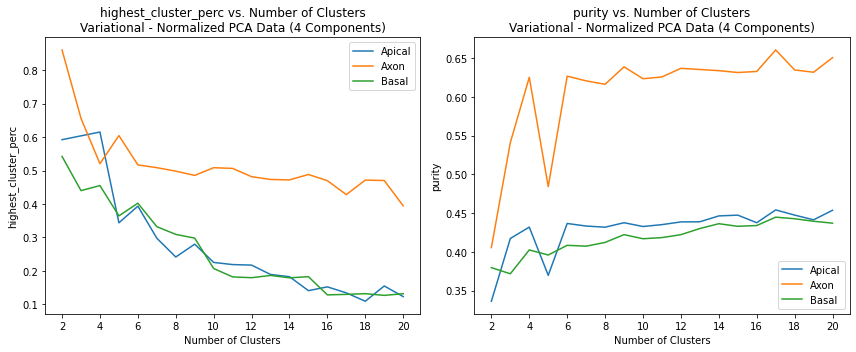

In [37]:
gmm = reload(gmm)
gmm.gmm_pipeline(df_col_filtered,
                 labeled_data_indices = labeled_data_indices,
                 title_suffix = "Variational - Normalized PCA Data (4 Components)",
                 columns_picked = None,
                 possible_K = possible_K,
                 apply_normalization=True,
                 apply_pca=True,
                  n_components_pca=4,
                 model_type = "variational"
                
                )